In [412]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split
from collections import defaultdict

from surprise import SVD

# 1. Read and explore the given dataset. ( Rename column/add headers, plothistograms, find data characteristics) 

In [413]:

electronics_data=pd.read_csv('Electronic_dataset.csv')

In [414]:
electronics_data.head()

,user_id,prod_id,ratings,timestamp
0,A3L1GVWVJKWZZS,B0058UUR6E,5.0,1364774400
1,A08831071BVKZMKNCPI5S,B009ID0VVS,5.0,1357257600
2,A1SINU2I4IOPNU,B000GBO9IM,4.0,1358121600
3,A3P3P31EEOX2BD,B00CDCIOHO,3.0,1404950400
4,A3DBLJ3MPBJQMN,B000MS3VGA,5.0,1294444800


In [415]:
#Removing Timestamp column as stated in problem 
electronics_data=electronics_data[['user_id','prod_id','ratings']]

In [416]:
electronics_data.shape

(500000, 3)

In [417]:
electronics_data.dtypes

user_id     object
prod_id     object
ratings    float64
dtype: object

In [418]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  500000 non-null  object 
 1   prod_id  500000 non-null  object 
 2   ratings  500000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 11.4+ MB


In [419]:
electronics_data.isnull().sum()

user_id    0
prod_id    0
ratings    0
dtype: int64

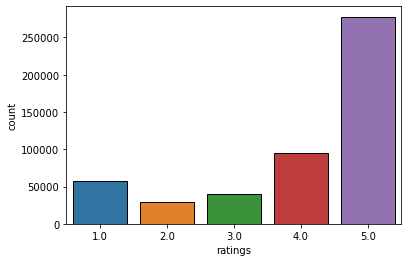

In [420]:
#Plotting count of products 
dist=sns.countplot(x='ratings',data=electronics_data)


In [421]:
print("Total number of unique Users:", len(electronics_data.user_id.unique()))

Total number of unique Users: 448368


In [422]:
print("Total number of unique Products:", len(electronics_data.prod_id.unique()))

Total number of unique Products: 130138


In [423]:
electronics_data.ratings.describe()

count    500000.000000
mean          4.013172
std           1.379996
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: ratings, dtype: float64

In [424]:
no_of_rated_products_per_user = electronics_data.groupby(by='user_id')['ratings'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

user_id
A680RUE1FDO8B     36
A3OXHLG6DIBRW8    34
ADLVFFE4VBT8      30
A5JLAU2ARJ0BO     29
A2NOW4U7W3F7RI    28
Name: ratings, dtype: int64

In [425]:
no_of_rated_products_per_user.describe()

count    448368.000000
mean          1.115155
std           0.500946
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          36.000000
Name: ratings, dtype: float64

In [428]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 10)) )


 No of rated product more than 50 per user : 136



# 2. Build Popularity Recommender model. 

In [429]:
#Taken products which have been rated by users more than 20 times
new_df=electronics_data.groupby("prod_id").filter(lambda x:x['ratings'].count() >=20)

In [24]:
new_df.shape  #Size of the dataset is reduced and have got all the products which can be considered for popularity

(189593, 3)

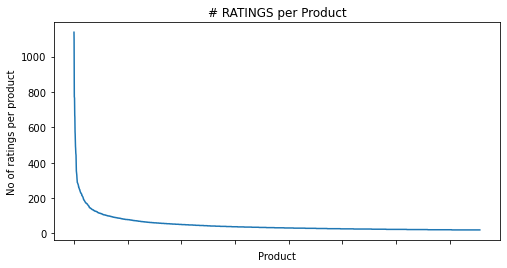

In [430]:
no_of_ratings_per_product = new_df.groupby(by='prod_id')['ratings'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [431]:
#Average rating of the product 

new_df.groupby('prod_id')['ratings'].mean().head()

prod_id
0972683275    4.741379
1400501466    3.681818
1400532655    4.272727
140053271X    3.535714
9573212919    3.545455
Name: ratings, dtype: float64

In [432]:
new_df.groupby('prod_id')['ratings'].mean().sort_values(ascending=False).head()

prod_id
B001342KM8    4.966667
B0043XZEEC    4.965517
B0041OYTJE    4.964286
B001MSVPM6    4.960000
B005KWHJES    4.956522
Name: ratings, dtype: float64

In [433]:
#Total no of rating for product

new_df.groupby('prod_id')['ratings'].count().sort_values(ascending=False).head()

prod_id
B0074BW614    1138
B00DR0PDNE    1094
B007WTAJTO     883
B0019EHU8G     774
B006GWO5WK     770
Name: ratings, dtype: int64

In [437]:
ratings_mean_count = pd.DataFrame(new_df.groupby('prod_id')['ratings'].mean()) 
#Taking avearage of all the ratings given by diffrent users to a particular product and creating a new dataframe

In [438]:
ratings_mean_count['ratings_counts'] = pd.DataFrame(new_df.groupby('prod_id')['ratings'].count())  
#Added a new column ratings_counts 

In [439]:
ratings_mean_count.head() 

,ratings,ratings_counts
prod_id,,
0972683275,4.741379,58
1400501466,3.681818,22
1400532655,4.272727,33
140053271X,3.535714,28
9573212919,3.545455,22


In [443]:
max=ratings_mean_count['ratings_counts'].max()
ratings_mean_count[ratings_mean_count['ratings_counts']==max]
#below product is rated by most of the users

,ratings,ratings_counts
prod_id,,
B0074BW614,4.465729,1138


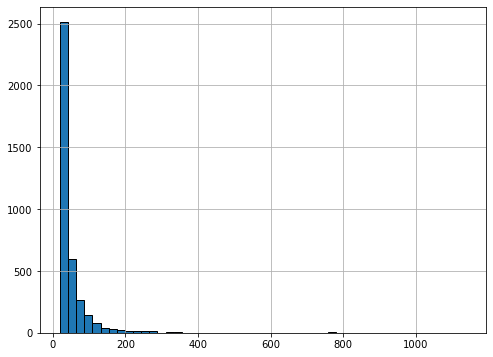

In [444]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['ratings_counts'].hist(bins=50)

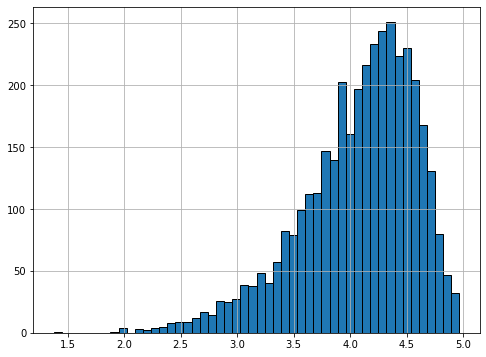

In [445]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['ratings'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

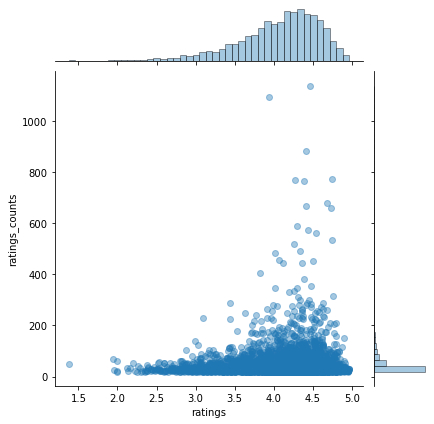

In [446]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='ratings', y='ratings_counts', data=ratings_mean_count, alpha=0.4)
#Plot describes roughly that products which have higher ratings have been rateed by more number of users

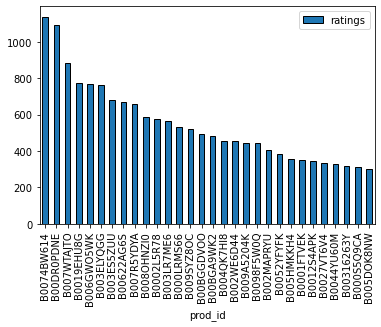

In [447]:
popular_products = pd.DataFrame(new_df.groupby('prod_id')['ratings'].count())
most_popular = popular_products.sort_values('ratings', ascending=False)
most_popular.head(30).plot(kind = "bar")

In [448]:
most_popular.head()

,ratings
prod_id,
B0074BW614,1138
B00DR0PDNE,1094
B007WTAJTO,883
B0019EHU8G,774
B006GWO5WK,770


In [449]:
ratings_mean_count=ratings_mean_count.sort_values('ratings_counts',ascending=False)


In [450]:
import plotly.express as px

In [453]:

df = px.data.gapminder()

fig = px.scatter(ratings_mean_count[0:10], x=ratings_mean_count.index[:10], y="ratings_counts", 
                 size='ratings', color='ratings',
                 hover_name="ratings_counts", size_max=60)
fig.show()

In [85]:
#bubble Chart shows the Top 10 products which have been rated by maximum number of users and have maximum ratings.

# 3. Split the data randomly into a train and test dataset. ( For example, split it in 70/30 ratio)

In [458]:
new_df=electronics_data.groupby("user_id").filter(lambda x:x['ratings'].count()>3)
#As the number of records are 500000 so filtering users on the basis of ratings provided ..
#This helps in reducing the size to calculate and take into account which have provided more ratings 

In [459]:
new_df

,user_id,prod_id,ratings
26,A2HX3D3MPPASNS,B004I3VZM2,4.0
64,A3PAYT2SQY7J3H,B002WR7VSS,5.0
67,A3MLSY6VS7AB8O,B001IBHF5S,5.0
125,A23M8B84K9TSBJ,B0017KMI66,5.0
214,AZNUHQSHZHSUE,B000FJEYZI,1.0
...,...,...,...
499873,AR74YY08IP2WE,B0088CJT4U,5.0
499890,A1HGXLP6WATS4B,B004N625BO,1.0
499916,A18S2VGUH9SCV5,B00064C53K,5.0
499935,A3MV1KKHX51FYT,B000BYD0ES,5.0


In [460]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [461]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=42)

# 4. Build Collaborative Filtering model.

In [462]:
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [463]:
# item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [464]:
predictions = algo.test(testset)

In [465]:
predictions

[Prediction(uid='A1VHDGG2CXBQ6T', iid='B003BYRGJ0', r_ui=4.0, est=4.245134656968744, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AS68424YO3OL6', iid='B002P32990', r_ui=4.0, est=4.245134656968744, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2NOIWPJDD7WIQ', iid='B000HJPK2C', r_ui=4.0, est=3.5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3VTSGMHNA7CA6', iid='B002MYQTEI', r_ui=5.0, est=4.245134656968744, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A12DLJESJKM1OQ', iid='B00006IIU1', r_ui=4.0, est=4.245134656968744, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A3BKK86IOLQD7A', iid='B003COAHKE', r_ui=4.0, est=4.245134656968744, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2OT3PDH1AWLTG', iid='B000WHMFHC', r_ui=5.0, est=4.2

In [466]:
#Accuracy 
print("Item-based Model : Test Set")
accuracy.rmse(predictions, verbose=True)
accuracy.fcp(predictions, verbose=True)
accuracy.mse(predictions, verbose=True)
accuracy.mae(predictions, verbose=True)

Item-based Model : Test Set
RMSE: 1.1847
FCP:  0.4689
MSE: 1.4034
MAE:  0.8706


0.8705580686140413

In [467]:
top_n=get_top_n(test_pred, n=5)

In [468]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A21IBMN32YHKUF ['B00000JMO3', 'B000MXNIJA', 'B000HGSL9Y']
A26LD9FQHTM8ZH ['B001OMH1JQ', 'B00BCGRX9M']
A21VM9WVF8EOSJ ['B0075Z2SMG', 'B001207YMY']
A19XMHRB3G4DIR ['B002SZEOLG', 'B000N99BBC', 'B000WU2FAQ', 'B004OHX6P6', 'B004XC6GJ0']
A3OXHLG6DIBRW8 ['B002EPF6YO', 'B002ALV9VQ', 'B0034XJNHQ', 'B000EM35N8', 'B000JKUOIY']
A1ZTR0FR5AW9B4 ['B001696CTW', 'B001FR8PQS', 'B001J6N11E', 'B000PO3CTM']
A328GLDSDNFYII ['B001G4NBSC', 'B002RM08RE']
AOEAD7DPLZE53 ['B004MKMH3M', 'B0018L8V92', 'B001D06BZY', 'B00DYH6HEY', 'B000QJ6KXQ']
A2V1J3JT5OOZFO ['B00426C57O', 'B000652SOK', 'B000CO9NTI', 'B001L5SN70', 'B000Q6WEFW']
A2EYVLDGH8OJZB ['B00FOILCZK', 'B009SYZ8OC', 'B0023ZK2TY']
A3AYSYSLHU26U9 ['B00BB72WX4', 'B003EWNXFU', 'B00AVWKUXE', 'B007VL8Y5E', 'B0091UX3QI']
A25C2M3QF9G7OQ ['B002MAPRYU', 'B006GWO5WK', 'B00IL7B2YM', 'B00FSA8VQ2', 'B00F9Q5E5G']
A2X3L31KCXBHCL ['B005IHAIJ8', 'B004FPZ3GM']
A25PKF8V3Q4IOL ['B004UHWZDY', 'B00GQDCROC', 'B007BY3PBE']
A1WJ3P43SZUNDM ['B00E4MQO8C', 'B003S68Q0Y']
A2QDOJFFLFGF18 ['B0

#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df[0:10000],reader)

#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=42)

In [469]:
# user-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [470]:
predictions = algo.test(testset)


In [471]:
predictions

[Prediction(uid='A1VHDGG2CXBQ6T', iid='B003BYRGJ0', r_ui=4.0, est=4.245134656968744, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AS68424YO3OL6', iid='B002P32990', r_ui=4.0, est=4.245134656968744, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2NOIWPJDD7WIQ', iid='B000HJPK2C', r_ui=4.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3VTSGMHNA7CA6', iid='B002MYQTEI', r_ui=5.0, est=4.245134656968744, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A12DLJESJKM1OQ', iid='B00006IIU1', r_ui=4.0, est=4.245134656968744, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A3BKK86IOLQD7A', iid='B003COAHKE', r_ui=4.0, est=4.245134656968744, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2OT3PDH1AWLTG', iid='B000WHMFHC', r_ui=5.0, est=4.245

In [472]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(predictions, verbose=True)
accuracy.mse(predictions, verbose=True)
accuracy.mae(predictions, verbose=True)

User-based Model : Test Set
RMSE: 1.1541
MSE: 1.3319
MAE:  0.8631


0.8631290386368689

In [473]:
top_n=get_top_n(test_pred, n=5)

In [474]:
top_n

defaultdict(list,
            {'A21IBMN32YHKUF': [('B00000JMO3', 4.2667955534074435),
              ('B000MXNIJA', 4.2667955534074435),
              ('B000HGSL9Y', 4.2667955534074435)],
             'A26LD9FQHTM8ZH': [('B001OMH1JQ', 4.2667955534074435),
              ('B00BCGRX9M', 4.2667955534074435)],
             'A21VM9WVF8EOSJ': [('B0075Z2SMG', 4.2667955534074435),
              ('B001207YMY', 4.2667955534074435)],
             'A19XMHRB3G4DIR': [('B002SZEOLG', 4.625),
              ('B000N99BBC', 4.625),
              ('B000WU2FAQ', 4.2667955534074435),
              ('B004OHX6P6', 4.2667955534074435),
              ('B004XC6GJ0', 4.2667955534074435)],
             'A3OXHLG6DIBRW8': [('B002EPF6YO', 4.2667955534074435),
              ('B002ALV9VQ', 4.2667955534074435),
              ('B0034XJNHQ', 4.2667955534074435),
              ('B000EM35N8', 4.2667955534074435),
              ('B000JKUOIY', 4.2667955534074435)],
             'A1ZTR0FR5AW9B4': [('B001696CTW', 4.26679555340744

In [475]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A21IBMN32YHKUF ['B00000JMO3', 'B000MXNIJA', 'B000HGSL9Y']
A26LD9FQHTM8ZH ['B001OMH1JQ', 'B00BCGRX9M']
A21VM9WVF8EOSJ ['B0075Z2SMG', 'B001207YMY']
A19XMHRB3G4DIR ['B002SZEOLG', 'B000N99BBC', 'B000WU2FAQ', 'B004OHX6P6', 'B004XC6GJ0']
A3OXHLG6DIBRW8 ['B002EPF6YO', 'B002ALV9VQ', 'B0034XJNHQ', 'B000EM35N8', 'B000JKUOIY']
A1ZTR0FR5AW9B4 ['B001696CTW', 'B001FR8PQS', 'B001J6N11E', 'B000PO3CTM']
A328GLDSDNFYII ['B001G4NBSC', 'B002RM08RE']
AOEAD7DPLZE53 ['B004MKMH3M', 'B0018L8V92', 'B001D06BZY', 'B00DYH6HEY', 'B000QJ6KXQ']
A2V1J3JT5OOZFO ['B00426C57O', 'B000652SOK', 'B000CO9NTI', 'B001L5SN70', 'B000Q6WEFW']
A2EYVLDGH8OJZB ['B00FOILCZK', 'B009SYZ8OC', 'B0023ZK2TY']
A3AYSYSLHU26U9 ['B00BB72WX4', 'B003EWNXFU', 'B00AVWKUXE', 'B007VL8Y5E', 'B0091UX3QI']
A25C2M3QF9G7OQ ['B002MAPRYU', 'B006GWO5WK', 'B00IL7B2YM', 'B00FSA8VQ2', 'B00F9Q5E5G']
A2X3L31KCXBHCL ['B005IHAIJ8', 'B004FPZ3GM']
A25PKF8V3Q4IOL ['B004UHWZDY', 'B00GQDCROC', 'B007BY3PBE']
A1WJ3P43SZUNDM ['B00E4MQO8C', 'B003S68Q0Y']
A2QDOJFFLFGF18 ['B0

In [476]:
#Using suprice SVD model

In [477]:
algo = SVD()
algo.fit(trainset)

In [478]:
predictions = algo.test(testset)

In [479]:
predictions

[Prediction(uid='A1VHDGG2CXBQ6T', iid='B003BYRGJ0', r_ui=4.0, est=4.342597162223799, details={'was_impossible': False}),
 Prediction(uid='AS68424YO3OL6', iid='B002P32990', r_ui=4.0, est=4.085270599591878, details={'was_impossible': False}),
 Prediction(uid='A2NOIWPJDD7WIQ', iid='B000HJPK2C', r_ui=4.0, est=4.232609697796913, details={'was_impossible': False}),
 Prediction(uid='A3VTSGMHNA7CA6', iid='B002MYQTEI', r_ui=5.0, est=4.245134656968744, details={'was_impossible': False}),
 Prediction(uid='A12DLJESJKM1OQ', iid='B00006IIU1', r_ui=4.0, est=4.4139343970175755, details={'was_impossible': False}),
 Prediction(uid='A3BKK86IOLQD7A', iid='B003COAHKE', r_ui=4.0, est=4.312164103497432, details={'was_impossible': False}),
 Prediction(uid='A2OT3PDH1AWLTG', iid='B000WHMFHC', r_ui=5.0, est=4.366658362319079, details={'was_impossible': False}),
 Prediction(uid='A1CPRP3VFJRS1R', iid='B004EK9ODG', r_ui=5.0, est=3.951581730339609, details={'was_impossible': False}),
 Prediction(uid='A2BYV7S1QP2YIG'

In [480]:
top_n = get_top_n(predictions, n=5)

In [481]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A1VHDGG2CXBQ6T ['B003ES5ZUU', 'B003BYRGJ0']
AS68424YO3OL6 ['B002P32990']
A2NOIWPJDD7WIQ ['B007XGLC9C', 'B002J9HBIO', 'B000HJPK2C']
A3VTSGMHNA7CA6 ['B003XM73P2', 'B004HHICKC', 'B002MYQTEI', 'B000RT8CM2']
A12DLJESJKM1OQ ['B000HAQ8EK', 'B00006IIU1', 'B00008OE6I', 'B00006L9CT']
A3BKK86IOLQD7A ['B005FYNSPK', 'B003COAHKE', 'B009QV15DU']
A2OT3PDH1AWLTG ['B000WHMFHC', 'B004NBZ98K']
A1CPRP3VFJRS1R ['B004EK9ODG', 'B0010Y414Q', 'B0001CVBRI', 'B0001YFZ46']
A2BYV7S1QP2YIG ['B00KWMNDDM', 'B00B7FNGIK', 'B009DMFOVG', 'B004M8SVHK']
A37HUQ6I3QNZDW ['B004CMKC6E']
A3D0HMC6RQT0N0 ['B004ZP74JG', 'B00005114Z', 'B003GAMO7S']
A1LYMYNURB9EWW ['B002FU5QMK']
A131NYI56W64SI ['B002ZCXJZE', 'B004AXDA82', 'B003EVZBA6']
A1901NTE8LFJF6 ['B001SER4BU', 'B000GK8LVE']
A1N5FSCYN4796F ['B00119T6NQ', 'B002OT8PCU', 'B005USRBVI', 'B003I4FHNA']
AICYK7WZA9Y4Z ['B006XB56VI', 'B0032FOKT2']
A2KZOIOFXXMC1H ['B00576T1G6', 'B007PR8NQO', 'B001196H3S', 'B0031X8HG2']
A22I55P15NSAOX ['B00HHRP11C', 'B00COF7DGS']
A3BVN2QBNPBHCR ['B000WXSO76'

A1G93Q5GNS9GZ2 ['B005DKZTMG', 'B004RJJMBI']
A3PIKGUUAKG4QZ ['B0001HA8WW', 'B002ROAX3G']
A3NGABXDIB0POU ['B00142BZSY', 'B00001P4XH']
A2DQ0HMNTM848E ['B0014GVZS0', 'B009A5204K']
A1MI7U19CI1VN2 ['B008JATJAA', 'B00009RA60']
A2KOHFCY43BX98 ['B002JCSV6M']
A1TDR7Y90SVCHL ['B006O7FM0G', 'B002WSPAKI']
A2D1LPEUCTNT8X ['B004460DIA', 'B008JFCDMQ', 'B005ILYFKM', 'B008AGP5H4', 'B00B8O6IIK']
A3D0UM4ZD2CMAW ['B0074CCDTS', 'B004S5CCP4', 'B003O520JC']
A2XLD2NZTET9Z8 ['B00008SCFL', 'B009B0MZ8U']
A2TKWMX4563NR6 ['B003ZM17RK']
A3M82NO6OU1FHS ['B00006B7DA', 'B00D697PEG', 'B006ZZQ5EY']
A2LB4FLRZG6CUV ['B008THTWIW', 'B00426C57O']
A2MY9VXHZYAHUZ ['B0001CJCCO', 'B00001P4ZH']
A3CDF86VUZ1PZG ['B000FFQ1VM']
A14S8QOW04PJP7 ['B0082BZY4G']
A3PJJTAKISAFI9 ['B008OHNZI0', 'B00337FY76', 'B004QVPGXK']
A123E03CA53CHJ ['B0001FTVEK', 'B00CP1129K']
A506HOOCVL8GW ['B005DPOTXG', 'B000KDSIOM', 'B000CRUBAA', 'B006GJTKRI']
A63B08A0BVNS6 ['B0053DDNW6']
A16GBXDS51J019 ['B0088CJT4U']
A2VC48WIMY6L6E ['B0063705PE']
A3D7BGK0P5QY0X ['B00

A3VLVMW59OQUG9 ['B008R6OPJQ']
A2J96FILPQA01 ['B001O9X9EU']
A11ERLOY4HCPA4 ['B007MKMJGO', 'B00012EYNG']
A1OWRLSD7LTSQ9 ['B0079R8KO0']
A16DKPKX4AKZ0B ['B0018LIMIW']
A2QIC4G483SQQA ['B0055LGG3Y']
A31BD4RXCON7QO ['B001N3FDEG', 'B001L58QWM']
A2E7OT9UAE8CLO ['B008CLY082']
A3K8OFIBDHWN5T ['B0040G7TAY']
A3USWH19MW0BG9 ['B009O7YUF6']
A1PF6BKW386KM ['B009KSEE4G']
A3AUNVBT52UHOA ['B003PJI9II']
A2Y6U3BZSVPLGZ ['B004NBL9WK']
APVMM27DJ2SOK ['B00BQA5BWU']
A3GB3663QXYMYD ['B004HKIIF8']
ABUVSUFGM1INC ['B006VZGYX0']
A2LCE1D0TW2XY0 ['B00009R89T']
A3BUNHF07TGZS3 ['B00E1MY1YE']
A2OEOZZFSSCDZW ['B003RRYAL8', 'B003EWNXFU']
A3NSPXI0F4RQOZ ['B001F7AJKI']
A1UYZEBGMW65FY ['B0042X9L6A']
A3SL0HA6422W4M ['B004TPPWT6']
A182BL642WB691 ['B001XWWBE2']
AHZUV9VVAOO1Z ['B007PLL4CK']
A3DI391K4GAI7Q ['B00021XIJW']
A3I9DMCAY33F3Z ['B00009RUHI']
A3IB5F5UTKNG5D ['B008S1W19Q']
A21LDIFT02EMXX ['B005QCDY50']
A2CL818RN52NWN ['B0002IQ1I0', 'B0001JXFS4', 'B0002X8U9I']
ABH9D1TEOJ56E ['B0000636RZ', 'B000088UNJ', 'B00008KIVO']
A1EAH433

In [482]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(predictions, verbose=True)
accuracy.mse(predictions, verbose=True)
accuracy.mae(predictions, verbose=True)

User-based Model : Test Set
RMSE: 1.0907
MSE: 1.1897
MAE:  0.8385


0.8384740638425761

# 6. Get top - K ( K = 5) recommendations. Since our goal is to recommend newproducts to each user based on his/her habits, we will recommend 5 newproducts. 


# Type I: Recommending new products according to the product rated by user

In [495]:
ratings_matrix = new_df.pivot_table(values='ratings', index='user_id', columns='prod_id', fill_value=0)
ratings_matrix.head()

prod_id,1400501466,1400532620,1400532655,140053271X,3744295508,5135000011,7507825604,8862935293,9573212919,9985511476,...,B00KHA5G6G,B00KIMX4EY,B00KK9481I,B00KMRGB7C,B00KMRGF28,B00KO6DS3Q,B00KWMNDDM,B00KYMCJF8,B00L2442H0,B00L26YDA4
user_id,,,,,,,,,,,,,,,,,,,,,
A0655860XQH1M5Q8JH1M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A100UD67AHFODS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A100WO06OQR8BQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A102F7EHNVW30Q,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A105S56ODHGJEK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [496]:
ratings_matrix.shape

(2753, 10876)

In [497]:
X = ratings_matrix.T
X.head()

user_id,A0655860XQH1M5Q8JH1M,A100UD67AHFODS,A100WO06OQR8BQ,A102F7EHNVW30Q,A105S56ODHGJEK,A105TOJ6LTVMBG,A1075X1Q4M3S78,A107D9T206Z36,A108GOZ37A7B75,A10C4ZRZTWIV7Y,...,AZHGPE0NPPQVT,AZICOXVMUPTY3,AZIMOGTBT3LPP,AZJN0GTY8SK71,AZMY6E8B52L2T,AZN8H3MNM0YOS,AZNUHQSHZHSUE,AZWQEM8GKXQ5Y,AZXFS8GCTSQ5R,AZZTC2OYVNE2Q
prod_id,,,,,,,,,,,,,,,,,,,,,
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400532655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140053271X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3744295508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [498]:
X.shape

(10876, 2753)

In [500]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(10876, 10)

In [502]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(10876, 10876)

In [503]:
correlation_matrix

array([[ 1.        ,  0.67921257,  0.701936  , ...,  0.22022002,
        -0.38445329, -0.25213506],
       [ 0.67921257,  1.        ,  0.48523561, ..., -0.27905213,
        -0.20582025, -0.27127003],
       [ 0.701936  ,  0.48523561,  1.        , ...,  0.18706062,
        -0.23842649, -0.83808549],
       ...,
       [ 0.22022002, -0.27905213,  0.18706062, ...,  1.        ,
         0.00528299, -0.01264867],
       [-0.38445329, -0.20582025, -0.23842649, ...,  0.00528299,
         1.        ,  0.21023774],
       [-0.25213506, -0.27127003, -0.83808549, ..., -0.01264867,
         0.21023774,  1.        ]])

In [506]:
products=ratings_matrix.columns
products_list=list(products)
def get_products(prod_id):
    user=products_list.index(prod_id)
    corr_user=correlation_matrix[user]
    Recommend=list(products[(corr_user)>=0.8])
    Recommend.remove(prod_id) 
    return Recommend[0:5]

In [508]:
count=1
for i in new_df.index:
    count=count+1
    print(count,new_df.loc[i]['user_id'],get_products(new_df.loc[i]['prod_id']))

2 A2HX3D3MPPASNS ['1400501466', '8862935293', 'B00002EQCW', 'B00004TDMX', 'B00004TDN0']
3 A3PAYT2SQY7J3H ['B00006HOAE', 'B00009R6VZ', 'B00009R94U', 'B0000VYJRY', 'B00013BLI6']
4 A3MLSY6VS7AB8O ['B00000DMA3', 'B00000K0JC', 'B00001WRSJ', 'B00003006Y', 'B00004S7PG']
5 A23M8B84K9TSBJ ['1400532655', 'B00003CWFA', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
6 AZNUHQSHZHSUE ['B00003CWFA', 'B00004W3ZQ', 'B00004Z5M1', 'B00004ZCA0', 'B000053HBB']
7 A25OU4XZAQVD66 ['B00000JMRX', 'B00001ZVIW', 'B0000228GG', 'B00004SPC0', 'B00004TVSP']
8 A2S2TX0PGZKD37 ['B00000DMA3', 'B00000K0JC', 'B00001WRSJ', 'B00004T8R2', 'B00004TS3P']
9 A1YEPFLLH42OU1 ['B00005JJRJ', 'B00005NVBF', 'B00005T3XV', 'B000068O3C', 'B00006B92A']
10 A2VYSDQ4Q7B2TC ['B00000K135', 'B00004WCFY', 'B00004Z5P4', 'B00004Z5VS', 'B00004ZCJE']
11 A2GYV87WW0DMSN ['B0000365CI', 'B00004TDLD', 'B00004WFWH', 'B00004Z0BN', 'B00004Z7TR']
12 A2IXMLO29Z5G8S ['B00005ATMI', 'B0000634T4', 'B000068CNS', 'B00006BBAU', 'B00006HXMO']
13 A1EX7MNFZYL58 ['B00005YVPI'

97 A27M18RREZO0PO ['B00004TWM6', 'B00005LEN4', 'B00006484F', 'B0000696HN', 'B00006HXWZ']
98 A2VC48WIMY6L6E ['B00004SPC0', 'B00004WLJ5', 'B000056SSM', 'B0000608R3', 'B000068IGR']
99 A10VYNMVS32Z2F ['B00004Z5D1', 'B00005I9Q0', 'B00005OQMO', 'B00007EDYY', 'B00007KDVK']
100 A1CMD08Z49PGKQ ['B000051299', 'B0000A0VET', 'B0002VAQR4', 'B000EHYZMS', 'B000FFT2KE']
101 A2L4W1M5YU5QX3 ['B00005ABA5', 'B00005QXWI', 'B000068O4N', 'B00006JQLE', 'B00006LK1O']
102 AGOH8N902URMW ['B00000JD4V', 'B00002EQCW', 'B00003CWFA', 'B00004TDMX', 'B00004TDN0']
103 A3JA80DEUKKILA ['B00004ZB57', 'B000068IL8', 'B0000691IQ', 'B00009017A', 'B00009M967']
104 A1ZVFCPHCWFV71 ['B00000K0JC', 'B00004Y7TC', 'B00005ABC5', 'B00005LE75', 'B00005NANM']
105 A2FSOHSM9X13JT ['B00009UHET', 'B000FE7SGA', 'B000GCBOEI', 'B000JJSQ9E', 'B000OZNKXA']
106 A267L1OWC7DDJV ['B00004SABB', 'B00005OQMO', 'B00007DWEA', 'B00009R6IM', 'B00009R72R']
107 A2IUXC55PAOY06 ['B00004SB92', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2', 'B00004U47J']
108 A3NHUQ33CF

262 A2CQR1RP0QHY7F ['B000001OM4', 'B00004TBLW', 'B00005QFAF', 'B00006HWQ5', 'B00006I5XC']
263 A25C2M3QF9G7OQ ['7507825604', '9573212919', 'B00000J4FS', 'B00000JMO3', 'B00000K0JC']
264 A18HE80910BTZI ['B000038AB2', 'B00004U47N', 'B00004Z9FF', 'B000069EUW', 'B00009R89T']
265 A3IUW081KXD3PE ['B00004Z5D1', 'B00007EDYY', 'B00008W2LC', 'B0000A0VET', 'B0002GWXLQ']
266 A3JSZ4ZRB7P1DV ['B00004SYNX', 'B00004Z5VS', 'B00004ZCJE', 'B000050AOO', 'B00005T406']
267 A72KEKIG7WATK ['B00004SYNX', 'B00004Z5VS', 'B00004ZCJE', 'B000050AOO', 'B00005T406']
268 A11LNPG39A2ZV4 ['B000006OQ8', 'B00005YVPI', 'B00006B7DA', 'B00006I5JQ', 'B00006IW1X']
269 A1BLDIJ8VJKUZZ ['B00006BBAC', 'B000BF3A88', 'B000I20AJ6', 'B000TXZBF2', 'B0011NM17K']
270 A1K4G5YJDJQI6Q ['B00004SYNX', 'B00004Z5VS', 'B00004ZCJE', 'B000050AOO', 'B00005T406']
271 ABSYIF0ONC2AF ['B00004WLJ5', 'B00004YKHT', 'B000053HH5', 'B00005ATMB', 'B00005T3GK']
272 A1XG38WOY3LY4V ['B000053HH5', 'B00005ATMB', 'B000067RC4', 'B000068U1L', 'B00006HXWZ']
273 A2OKRGHI

427 A15U64VGUV6RBF ['9985696999', 'B00000DM9W', 'B00000JDF5', 'B00004TS6W', 'B00005ATZN']
428 AO1OG64J0SYPY ['B00003CWFA', 'B00004YKHT', 'B00004Z5M1', 'B000053HBB', 'B00005B9AQ']
429 A1TEEA7B4U8QGN ['1400501466', 'B00005AB9R', 'B00005ATMI', 'B0000634T4', 'B000068CNS']
430 A1F9Z42CFF9IAY ['7507825604', 'B00000J1US', 'B00000J4FS', 'B00000JMO3', 'B00002EQCS']
431 AVPNQUVZWMDSX ['1400501466', 'B00001WRI4', 'B000031KIM', 'B0000510T7', 'B000051SDQ']
432 A3NOBH42C7UI5M ['B000001OMA', 'B00001ZWXA', 'B00004U8JS', 'B00004WFWH', 'B00004Z7TR']
433 A34CSXOGVYF94S ['B0000300S2', 'B00004WCG6', 'B00004Z0BN', 'B00004ZCJE', 'B000050AOO']
434 AKSQNMIKOU01H ['B00000J4VK', 'B00004NKHY', 'B00004R7OI', 'B00004WCIC', 'B00005MOZG']
435 A3EK2KTYHJCPB9 ['B0000510IA', 'B00005114Z', 'B000069EUW', 'B00006BBFM', 'B00007IFDR']
436 A3IL5XA8XYBPUD ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00004Z5D1']
437 A2XIM0IMONP1FX ['B00001ZUJA', 'B00004ZB57', 'B000068IL8', 'B0000691IQ', 'B00007E7RF']
438 APRNS6DB6

635 A32HSNCNPRUMTR ['9985696999', 'B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB']
636 A3TLZI55X3PH9Y ['B000077XII', 'B0001M2FZK', 'B0001ZA4PA', 'B00029IY8O', 'B00068S59Y']
637 A30Z0GG96D11EO ['B00000K135', 'B00004WCFY', 'B0000514G8', 'B00005853Z', 'B00005ABA5']
638 ADZIJQN6MNRAB ['9985511476', 'B00005QXWI', 'B00006HOLO', 'B00006LK1O', 'B00008VEKA']
639 A2VKB9TQWJDQ99 ['B00000DM9M', 'B00000K0JC', 'B00003006Y', 'B00004Y7TC', 'B0000512C5']
640 A3NNTYXX1O8D61 ['B0002NDFKM', 'B0002VAQR4', 'B0007WKB5K', 'B000IM9542', 'B001K9BFB8']
641 A2OFOUA4N2WW1L ['B00000DMA3', 'B00000K0JC', 'B00001WRSJ', 'B00003006Y', 'B00004S7PG']
642 A2TY271P4XSFB9 ['5135000011', 'B00004SYVL', 'B00004TBLW', 'B00004YZLY', 'B0000511T7']
643 A2Z63M867JULS ['B00005B9AQ', 'B00006JU62', 'B00008VE6L', 'B00009R8DD', 'B00009X3RO']
644 A3K400TWMAO2R1 ['B00000DM9M', 'B00004T1XD', 'B00006IRS3', 'B00006JQ06', 'B00006SKLC']
645 A1HBI9BBQIG1NH ['3744295508', 'B00006I5JQ', 'B00006SG3V', 'B000092TT0', 'B00009R6WW']
646 A30XZK10

743 A28KI92RSY1Y11 ['B00003CWDU', 'B00004WLJ5', 'B00005T3C8', 'B00005T3G0', 'B000065BPB']
744 A294BKN913UOGP ['B000038AB2', 'B00004Z9FF', 'B00005T3C8', 'B00005T3G0', 'B00006HTLY']
745 A328S9RN3U5M68 ['B00000DM9M', 'B00004TJ7O', 'B00004Z6I3', 'B00005N6KG', 'B00006F2MW']
746 A1N8X0FV2SHVWN ['B00001WRI4', 'B000031KIM', 'B00004U47J', 'B00004WCI7', 'B00004XOM3']
747 A2GKMXRLI7KLFP ['9985696999', 'B00000DM9W', 'B00000JDF5', 'B00004TS6W', 'B00005ATZN']
748 A1EKSETIBS9ETQ ['B00005T3RC', 'B00006A7AY', 'B00006FRUI', 'B000087ZQC', 'B00009KO0D']
749 A1Z9SK5Y3GFDHQ ['B00004WFWH', 'B0000510G3', 'B00005115S', 'B00005BC0J', 'B00005NPWJ']
750 A1ZTR0FR5AW9B4 ['B0000300S2', 'B00006484F', 'B000068O4C', 'B0000696HN', 'B000069K8N']
751 ALQ4USPEQ9L5N ['B00004TDLD', 'B00004Z0BN', 'B00004ZCJE', 'B000050AOO', 'B00005NIMJ']
752 A2JVISJC1V6GWB ['B0006688XO', 'B00083J67C', 'B000M1G8BW', 'B002XJN5B2', 'B003VWY0VY']
753 A1BFYAD2K8DTIC ['B000001OMA', 'B00000DM9W', 'B00004TS6W', 'B00004U8JS', 'B00004WFWH']
754 A3C50S1

987 A2L42QEWR77PKZ ['B00006BBAC', 'B000BF3A88', 'B000I20AJ6', 'B000TXZBF2', 'B0011NM17K']
988 A2TBAUW2W7J538 ['B00004YKHT', 'B000053HH5', 'B00005ATMB', 'B00005T3GK', 'B00005U21D']
989 AMJAKGM4YD7H5 ['B00004X107', 'B0000511U7', 'B00005QVJN', 'B00009W3BW', 'B0000A1G05']
990 AIA5WY7MZG3J ['B00004R7OI', 'B00004W3ZQ', 'B00005105N', 'B00005A8XW', 'B00005QVL0']
991 A3D1TZH619NKHN ['B00000JMRX', 'B00001ZVIW', 'B0000228GG', 'B00004X107', 'B0000511U7']
992 A3TUMQ1SQE9P0A ['7507825604', 'B00000DMA3', 'B00001WRSJ', 'B00004T8R2', 'B00004THMQ']
993 A3MBTVX9FJQU2S ['B00000K135', 'B0000514G8', 'B00005853Z', 'B00005NVBT', 'B00005T3W5']
994 A22RY8N8CNDF3A ['1400532655', 'B00004VUGI', 'B00004ZCPH', 'B0000510T7', 'B00005111L']
995 A1INE33UQ1B4Q3 ['B00005105N', 'B00005MNSS', 'B00005RT03', 'B00005T39Y', 'B0000899ZB']
996 A2W9GX82SLKROQ ['B00000DM9M', 'B00005LE75', 'B00005N6KG', 'B00005T3Q2', 'B000068O33']
997 A32EOHLFZYXJEP ['B00000K135', 'B00001W0DI', 'B00004WCFY', 'B00004ZCJE', 'B0000514G8']
998 A1VP1KVX7

1128 A17FQOCNVFSE9Q ['3744295508', 'B00009R6WW', 'B0000CEPE8', 'B0000XK46M', 'B000BQ7GW8']
1129 A1R5FUGCG4O1JO ['B00000K135', 'B00004SYNX', 'B00004WCFY', 'B00004Z5VS', 'B00004ZCJE']
1130 AST9SK8429HQY ['B00000JMO3', 'B00000JRHX', 'B00002EQCS', 'B00003006Y', 'B00004S7PG']
1131 A2D1N6Z7WS9AQQ ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']
1132 A2WLDEORTNRY0D ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']
1133 A1XP5GMAIXJ10A ['B00003CWFA', 'B00004U47J', 'B00004W3ZQ', 'B00004ZCA0', 'B00005105N']
1134 A268S3JIG60QZF ['B00004SYNX', 'B00004Z5VS', 'B00004ZCJE', 'B000050AOO', 'B00005T406']
1135 A2OBDNQ5ZYU1L8 ['1400532620', 'B00000J4FS', 'B00000JMO3', 'B00004RG7J', 'B00004THMQ']
1136 A2W5RVEFAH1ULG ['B0000365CI', 'B00004TDLD', 'B00004WFWH', 'B00004Z0BN', 'B00004ZCJE']
1137 A3TU2PWKE8GBAK ['B00004TJ7O', 'B00004Z5P4', 'B00004Z6I3', 'B00004Z7TR', 'B000068O6B']
1138 A54SG05AV6S4H ['B00004WCG6', 'B00004Z0BN', 'B00004ZCJE', 'B000050AOO', 'B00005AB9R']
1

1222 A3V5F050GVZ56Q ['B00006JN3G', 'B00007EDZG', 'B000117DEY', 'B000CDLCGG', 'B000P9ZG00']
1223 AV64O7H0UQKE0 ['B00005QXWI', 'B000067RC5', 'B000068O4N', 'B00006LK1O', 'B0000BVYTV']
1224 A2XR9TXCXK44R3 ['B0000630TQ', 'B00006HVT4', 'B00009V3FL', 'B0000A0AJH', 'B0000B35CK']
1225 A1INE33UQ1B4Q3 ['1400532655', 'B00004ZCPH', 'B00005105N', 'B00005MNSS', 'B00005T39Y']
1226 A2NBCCFDISGUQT ['B00004VUGI', 'B000051SD1', 'B00005ABC5', 'B00005BWYJ', 'B00005NANM']
1227 A16IM9MYTHCKYQ ['B00004WLJ5', 'B000065BPB', 'B000068O51', 'B000117DEY', 'B00020S7XK']
1228 AW8UBYMNJ894V ['B00005T3SM', 'B000065BPC', 'B000067DKB', 'B000069092', 'B00006DY6J']
1229 ARBKYIVNYWK3C ['B00000J1US', 'B000028F42', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC']
1230 A31HOWJKEIY037 ['B00001ZWXA', 'B00004T1XD', 'B00004TDLD', 'B00005NIMJ', 'B000068O3S']
1231 ACZ4YI6UWRVOG ['B00000J1US', 'B00000J4FS', 'B00003CWDG', 'B00004R8VC', 'B00004S9AK']
1232 A1YQK9S2QR3X4H ['B00002EQCW', 'B00003CWDG', 'B00003CWFA', 'B00005105N', 'B000053HBB']
123

1317 A11IXJ8M1JO296 ['B00000DMA3', 'B00004SPC0', 'B0000511U7', 'B000056SSM', 'B00005LE75']
1318 A3TAS1AG6FMBQW ['B00000K0JC', 'B00003006Y', 'B00004THMQ', 'B00004Y7TC', 'B0000512C5']
1319 AN3USE2N5K3WA ['B00000JDFJ', 'B00004SB92', 'B00004X10C', 'B0000513O4', 'B00005ATMI']
1320 A2T9OH7QUYPMXS ['B00004SSQW', 'B00004TDLD', 'B00005BC0J', 'B00005T6GZ', 'B000095ISG']
1321 A24QFMD1RXLJMB ['B00004XOM3', 'B00004YMZ4', 'B00004ZCA0', 'B0000507JI', 'B000058TLP']
1322 A3D36ARA7L7MII ['B00000K135', 'B00004WCFY', 'B00004WFWH', 'B00004Z0BN', 'B00004Z5P4']
1323 A3AYSYSLHU26U9 ['B00004TRD9', 'B00005ABA5', 'B00006JPRQ', 'B00007B4DT', 'B00007BGSP']
1324 A1UJGZQJG6BP9K ['B00000DM9M', 'B0000365CI', 'B00004TJ7O', 'B00004WFWH', 'B00004Z5P4']
1325 A25GJGYG2ZFNT0 ['B00005T3RC', 'B00006I53A', 'B00009R6WT', 'B00009V6U0', 'B0000ALKEN']
1326 A3VWU7S29LR2XX ['B000001OM4', 'B000038AB2', 'B00004SPC0', 'B00004TBLW', 'B00004WLJ5']
1327 A2IXK5LB4Y0NYV ['B00001W0DI', 'B0000300S2', 'B00004Z0BN', 'B00005NIMJ', 'B00005T6GZ']


1414 A1ILWPH1GHUXE2 ['B00000J1US', 'B00004R8VC', 'B00004S9AK', 'B00004SA30', 'B00004SD9Q']
1415 A2HSQM5KNHX9XL ['B00005MOZG', 'B00005OASK', 'B00006I53S', 'B00009QOW4', 'B0000AZK3Z']
1416 A1VC45CWKB4E7C ['B0000511T7', 'B000067SMH', 'B00007FS1O', 'B00008WFVL', 'B00009R6AV']
1417 A17O9AHKHK66AI ['B00004TWM6', 'B00005LEN4', 'B00006484F', 'B000067RC4', 'B0000696HN']
1418 ALHFBTFBTWE36 ['B00005ATZN', 'B0000630TQ', 'B000067RT6', 'B000068O5D', 'B00006BT1G']
1419 A6MFQD6NAUXKA ['B00001WRI4', 'B000031KIM', 'B00004U47J', 'B00004WCI7', 'B00004XOM3']
1420 A3DGJMO6VPG6FJ ['B00000K135', 'B00001W0DI', 'B0000300S2', 'B00004WCFY', 'B00004ZCJE']
1421 A33HIV8RXRDM88 ['B00000J1US', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC', 'B00004S9AK']
1422 A3TAS1AG6FMBQW ['B00000K0JC', 'B00004THMQ', 'B00004TS3P', 'B00004Y7TC', 'B0000512C5']
1423 A3RCEXV5769SG8 ['7507825604', 'B00004YKHT', 'B000053HBB', 'B000053HH5', 'B00005ATMB']
1424 A1KLZY9NL0AKMV ['B000006OQ8', 'B00005YVPI', 'B00006B9CR', 'B00006I5JQ', 'B00006IW1X']
1

1517 A1BG7TB6HWPLHX ['B00004YKHT', 'B00004Z5M1', 'B000053HBB', 'B00005B9AQ', 'B00005T3GK']
1518 A3I1DZD1D6QLIF ['B0000300S2', 'B00004WCG6', 'B00004Z0BN', 'B00004ZCJE', 'B00005AB9R']
1519 A22FY6FPTT6ST7 ['B00000JDFJ', 'B00004SB92', 'B00004SSQW', 'B00005115S', 'B0000513O4']
1520 A3EJOWUA5UZRNO ['9985511476', 'B00005QXWI', 'B000068O4N', 'B00006JQLE', 'B00006LK1O']
1521 A3T6CO6C92QONO ['B00005T3C8', 'B00005T3G0', 'B00006BBAB', 'B0002HBOMO', 'B0002MQGOU']
1522 A3PIPF1UAVY7IW ['B000067SPL', 'B00008OE46', 'B0002RBQO0', 'B0009HGVZW', 'B000CSWHCY']
1523 A1STW7ZA3XZ9VV ['B00000JD4V', 'B00003CWFA', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
1524 A2SATO5BNKWY3Y ['B00004SPC0', 'B000056SSM', 'B00005QVJN', 'B0000AZK4G', 'B0007KK22E']
1525 A2KR1481ARVYNP ['5135000011', 'B00000DM9M', 'B0000365CI', 'B00004SYVL', 'B00004TBLW']
1526 A3SO2AGQXXL8LC ['B00005YVPI', 'B00006I5JQ', 'B00006IW1X', 'B00006SG3V', 'B000092TT0']
1527 AA7P2NEC94K79 ['1400501466', '1400532620', '8862935293', 'B00000J4FS', 'B00003CWDG']


1627 A185O1MX1RP964 ['B00001ZUJA', 'B00005MEAI', 'B00005YV57', 'B00009R7BD', 'B00009R8ZW']
1628 A2KIA7JQRIDW94 ['B00009VQJZ', 'B0007UQNKO', 'B000EHUE7I', 'B000I98ZQY', 'B000IZE8XM']
1629 A3C50S1M9MI2UI ['B00000DM9M', 'B0000365CI', 'B00004TJ7O', 'B00004WFWH', 'B00004Z5P4']
1630 A2Q987OD3HVZJM ['B00000J4VK', 'B00004NKHY', 'B00005YV57', 'B00006BT1G', 'B00006HCJI']
1631 A2HDTOF8222KN3 ['B00004TVSP', 'B000053HBB', 'B00006I5JC', 'B00007E7K9', 'B000087NBV']
1632 A3M82NO6OU1FHS ['B000006OQ8', 'B00001ZUJA', 'B00006364I', 'B00006B7DA', 'B00006HOAE']
1633 A26Y7WIS3JBL65 ['1400501466', '8862935293', 'B00003CWDG', 'B00004WCI7', 'B00004X10C']
1634 A1MZL91Z44RN06 ['B00004WCG6', 'B00004Z0BN', 'B00004ZCJE', 'B000050AOO', 'B00005AB9R']
1635 AGVB3UZIPFHEF ['8862935293', 'B00000J1US', 'B00000J4FS', 'B00000JMO3', 'B00004R8VC']
1636 A213J54E63SYOP ['B00000K0JC', 'B00004Y7TC', 'B0000512C5', 'B00005ABC5', 'B00005LE75']
1637 A2V1J3JT5OOZFO ['B00001WRSJ', 'B00004T8R2', 'B00004Z5D1', 'B00007EDYY', 'B00008W2LC']


1739 AJMT9QTS71UYR ['B00004W3ZQ', 'B00005105N', 'B00005A8XW', 'B00005NIMU', 'B00005QVL0']
1740 A2ZWHOXTGFPAFZ ['B00000DM9M', 'B00000K0JC', 'B00001MXYW', 'B00004SUG7', 'B0000512C5']
1741 A2VNAGUP6GD6ZW ['B00000JLSJ', 'B00005YV57', 'B0000668YX', 'B000067VBL', 'B00006JQ06']
1742 A11OTLEDSW8ZXD []
1743 A1W415JP5WEAJK ['B00004TJ7O', 'B00004Z6I3', 'B00004Z7TR', 'B000067SMH', 'B00006F2MW']
1744 A3QMJMTLJC34QC ['9573212919', 'B00000DMA3', 'B00000K0JC', 'B00001WRSJ', 'B00004TS3P']
1745 AG7EF0SVBQOUX ['B00000JD4V', 'B00003CWFA', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
1746 A3IOQ7NVVLAUEE ['B000069J8K', 'B000MVJ1MA', 'B000NPZ4D0', 'B000PLTX9S', 'B002G1YPHA']
1747 A21P2TV5Y8G6V ['B000092YQK', 'B00009R6WY', 'B00009UTZA', 'B0000A4EZM', 'B000144I2Q']
1748 AZHGPE0NPPQVT ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']
1749 A25OU4XZAQVD66 ['B00000JMRX', 'B00001ZVIW', 'B0000228GG', 'B00004SPC0', 'B00004TVSP']
1750 A3RCEXV5769SG8 ['B00001WRI4', 'B00004VUGI', 'B00004XOM3', 'B00004Z

1962 A3DJUTS8GV3OZ8 ['B00004YMZ4', 'B000058TLP', 'B000067SLY', 'B00007E7RF', 'B00008ZPHY']
1963 A2A4X545ERLS7H ['B000001OMA', 'B00001ZWXA', 'B00004TDLD', 'B00005BC0J', 'B00005NPWJ']
1964 AJ8AQG2X9JJ2Y ['7507825604', 'B00000DMA3', 'B00000K0JC', 'B00001WRSJ', 'B00004T8R2']
1965 A2XF6YX601SZ1Z ['1400501466', '1400532655', 'B00003CWDG', 'B0000510T7', 'B00005111L']
1966 A91XC52Q1NUL6 ['B00006BBAC', 'B000BF3A88', 'B000I20AJ6', 'B000TXZBF2', 'B0011NM17K']
1967 A2794X9DIVMQYF ['B00004TDMX', 'B00004TDN0', 'B00004TDN2', 'B00004U47J', 'B00004WCI7']
1968 A1W5W1NFNWOT6H ['B00004TVSP', 'B0000645RH', 'B00006I5JC', 'B00006JN3G', 'B00007KDVI']
1969 A25C2M3QF9G7OQ ['7507825604', 'B00000J4FS', 'B00000JMO3', 'B00000K0JC', 'B00002EQCS']
1970 A3IUW081KXD3PE ['B00008W2LC', 'B00062NHTS', 'B00064GI2O', 'B0009QZDLG', 'B000EHYZMS']
1971 A1DMZJ6L2DCPYG ['B00000K135', 'B00004WCFY', 'B0000514G8', 'B00005853Z', 'B00005ABA5']
1972 A1U9Y4XH0D8LQ7 ['140053271X', 'B00005ATMI', 'B0000634T4', 'B000068CNS', 'B00006I5TD']
1

2103 A83J682316KEA ['B0009MFTSW', 'B0037VVWBK', 'B003XOXFUM', 'B004GWQBWY', 'B0051PSQQ4']
2104 A24KKRCPD755UI ['B00005QXWI', 'B00005T3RC', 'B00006A7AY', 'B00006FRUI', 'B00006HOAE']
2105 A31X5U9OZSOCOA ['B00004Z5G3', 'B00005114Z', 'B000069EUW', 'B00006BBFM', 'B00007IFDR']
2106 A3GB3663QXYMYD ['B00004Z5G3', 'B00005NCWK', 'B00008IHOZ', 'B00008KA6Z', 'B00009YUPY']
2107 A9ELHLPXF7JKD ['B00006I5JC', 'B00009R8XM', 'B0002VAQR4', 'B000ALLMI8', 'B000I5KSNQ']
2108 A27M18RREZO0PO ['B00004TWM6', 'B00005LEN4', 'B00006484F', 'B000067RC4', 'B0000696HN']
2109 AM1D8O2CRCAE0 ['B000006OQ8', 'B00001ZUJA', 'B00006B7DA', 'B00007E816', 'B00009R6VZ']
2110 A1ZE1LPZHGG1QP ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B000021YU8', 'B00003006Y']
2111 A269FH9V0X3593 ['B00000DM9W', 'B0000514G8', 'B00005ABA5', 'B00005ATZN', 'B0000630TQ']
2112 A1LD5SE8IZ1H70 ['1400532620', '140053271X', 'B00005ATMI', 'B00006B9QE', 'B00006DY6M']
2113 A7X6YFG16WJED ['B00000J1SC', 'B00009KYCN', 'B0006B5SR8', 'B0007LCKJQ', 'B0007TSYCK']
211

2249 A2ELKOZRB1JY8U ['B00000JD4V', 'B00003CWFA', 'B00004W3ZQ', 'B00004ZCA0', 'B00005A8XW']
2250 A36WUZ5TOXGYU7 ['B00004SABB', 'B00005JJRJ', 'B00005NVBF', 'B00005T3XV', 'B00006FDR1']
2251 A13WOT3RSXKRD5 ['9985696999', 'B00000DM9W', 'B00005ATZN', 'B00005RZOZ', 'B0000630TQ']
2252 A19ZM9NAFLVW3B ['B00004W3ZQ', 'B00005105N', 'B00005A8XW', 'B00005NIMU', 'B00005QVL0']
2253 A35HNL2VEDK9Z1 ['B00000DMA3', 'B00000K0JC', 'B00001WRSJ', 'B00003006Y', 'B00004S7PG']
2254 A3LQI6DLFEXOVJ ['B00000J1SC', 'B00000JDFJ', 'B00004TDLD', 'B00006L4XC', 'B000083JZ0']
2255 A2ROZACRW31PC2 ['B0001VGFKW', 'B0002BG6U0', 'B0006B57A6', 'B0007A1IRC', 'B0007OWN9K']
2256 AT8TIN5JKHO2V ['B00003CWFA', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2', 'B00004U47J']
2257 A2ZRMCRLDSUX6R ['1400532655', 'B00000DMA3', 'B00001WRSJ', 'B00004T8R2', 'B00004TS3P']
2258 A33775AIB1A664 ['B001UP7DI6', 'B002AR5XIK', 'B004QOA92A']
2259 A141R97FHSSUQ0 ['B00000J1US', 'B00000J4FS', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC']
2260 A1HWC7QCLS0HHT ['B00006

2404 A1XE3M22N91451 ['B00005YVPI', 'B00006I5JQ', 'B00006SG3V', 'B0000A576D', 'B0000BZL1P']
2405 A1PCOISXXOM6T2 ['B00000JMRX', 'B00001ZVIW', 'B0000228GG', 'B0000511U7', 'B00005LB8P']
2406 A1MXJVANURX26J ['B00000K135', 'B00001W0DI', 'B00005115S', 'B0000513O4', 'B00005ABA5']
2407 A2TBLWQX0EQHGV ['B00005YVPI', 'B00006I5JQ', 'B00006IW1X', 'B00006SG3V', 'B000092TT0']
2408 AZXFS8GCTSQ5R ['B00004SSQW', 'B00005BC0J', 'B00005T6GZ', 'B00009RUHI', 'B00029TK78']
2409 A3UW23DBF2KHWC ['B00000J1SC', 'B00001ZWXA', 'B00004TDLD', 'B00005NPWJ', 'B000068O16']
2410 A38Z6QG6988WS7 ['B000038AB2', 'B00004Z9FF', 'B00005T3C8', 'B00005T3G0', 'B00006HTLY']
2411 A195EZSQDW3E21 ['B0000514G8', 'B00005ATZN', 'B0000630TQ', 'B000068O5D', 'B00006BT1G']
2412 A2QNS95WGN35G9 ['B00005YVPI', 'B00006B9CR', 'B00006I5JQ', 'B00006IW1X', 'B00006SG3V']
2413 A2RW587355CMVA ['B00005ABC5', 'B00005LE75', 'B00005N6KG', 'B00005T3Q2', 'B00005UKBD']
2414 A2MSBIA18RXYQC ['B0000365CI', 'B00004TJ7O', 'B00004WFWH', 'B00004Z5P4', 'B00004Z6I3']


2555 A16WND1BVJCQJV ['3744295508', 'B00009R6WW', 'B0000CEPE8', 'B0000XK46M', 'B000BQ7GW8']
2556 AQFZEKYP1P1LT ['B0002BG6U0', 'B0007OWN9K', 'B000WHCA86', 'B0019WDZUU', 'B001T9NX9Q']
2557 A32GVA2VANF89W ['B00000JLSJ', 'B00005LEOH', 'B00005T3SM', 'B000065BPC', 'B0000668YX']
2558 A3B6PCNC86UB86 ['9985696999', 'B00000JDF5', 'B00005RZOZ', 'B00006HXIU', 'B00009V3FL']
2559 A7X6YFG16WJED ['B00000J1SC', 'B00009KYCN', 'B0006B5SR8', 'B0007LCKJQ', 'B0007TSYCK']
2560 A2ZAWPWLLTOHNK ['B00004Z5D1', 'B00007EDYY', 'B00008W2LC', 'B000092YQW', 'B0000A0VET']
2561 A3F9AG94G7EH43 ['B00000JD4V', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2', 'B00005JJRJ']
2562 A3SKMWPVR5CO1H ['7507825604', '9573212919', 'B00002EQCS', 'B00003CWDG', 'B00004THMQ']
2563 A24HWYHR28JJ7A ['B00003G1RG', 'B00004SYVL', 'B00004Y2Z5', 'B00005B4BW', 'B00007K3A3']
2564 A1B6UB1GE19KKI ['B00000JI4F', 'B00001P4XH', 'B00004SABB', 'B00005I9Q0', 'B00005RZOZ']
2565 A2IIAQ7VVAHXTD ['B00005114Z', 'B00006BBFM', 'B00007IFDR', 'B00009R9EB', 'B00024JN3Y']
2

2661 A25PKF8V3Q4IOL ['B00003G1RG', 'B00004Y2Z5', 'B00005B4BW', 'B00007K3A3', 'B00007KDVJ']
2662 A2WPL6Y08K6ZQH ['B00005NIMU', 'B00005T3SM', 'B000065BPC', 'B000067DKB', 'B000067VBM']
2663 A2Z63M867JULS ['B00005NVBF', 'B00005T3XV', 'B00006FDR1', 'B00006FDRB', 'B00006JU62']
2664 ARHH1P2PLAFSJ ['B00004ZCA0', 'B00005NVBF', 'B00005T3XV', 'B000067RC5', 'B000067SLY']
2665 A1VHCO8RQFIGQJ ['B00000DM9M', 'B00001MXYW', 'B00003006Y', 'B00004S7PG', 'B00004SUG7']
2666 ACOF64EAN08QQ ['9985696999', 'B00000DM9W', 'B00004TS6W', 'B0000514G8', 'B00005ABA5']
2667 AZAC8O310IK4E ['1400532655', 'B00004VUGI', 'B00004XOM3', 'B00004ZCPH', 'B0000507JI']
2668 AX05DBU8IRUWY ['B00005V52C', 'B000068O4N', 'B00006B92A', 'B00006B9CR', 'B00009R94U']
2669 AT6CZDCP4TRGA ['B00004W3ZQ', 'B00004Z5M1', 'B00004ZB57', 'B000053HBB', 'B00005A8XW']
2670 A3PNN6W95O5XNV ['B00005ABC5', 'B00005NANM', 'B00005RKO5', 'B000068O3S', 'B00006B81E']
2671 A2XF6YX601SZ1Z ['1400501466', '1400532655', 'B00003CWDG', 'B0000510T7', 'B00005111L']
2672 

2783 A2ZRMCRLDSUX6R ['1400532655', 'B00000DMA3', 'B00001WRSJ', 'B00004T8R2', 'B00004TS3P']
2784 A177VGRGU5B0S3 ['B00004YMZ4', 'B000058TLP', 'B000067SLY', 'B00007E7RF', 'B00009R6TA']
2785 A2MLP4UGTF1RX4 ['B00005JJRJ', 'B00005NVBF', 'B00005T3XV', 'B00006FDR1', 'B00006FDRB']
2786 A3IRV2LVPC8SR9 ['B00007056H', 'B00009UHET', 'B0000CBBNP', 'B0001XGR2G', 'B000BF3A88']
2787 A3IGEXC062RD5V ['1400501466', '8862935293', 'B00002EQCW', 'B00003CWDG', 'B0000510T7']
2788 A2PR5G1680ISEY ['B00000DM9M', 'B000021YU8', 'B00003006Y', 'B00005LE75', 'B00005N6KG']
2789 AWPODHOB4GFWL ['B00005LEN4', 'B00006484F', 'B000067RC4', 'B0000696HN', 'B00006HXWZ']
2790 A2ARDVMUGDFED6 ['B00000JRHX', 'B00006B81D', 'B00006DY6M', 'B00009R6FV', 'B00009XW5J']
2791 A3VBORHS4H8LES ['B00003G1RG', 'B00004Y2Z5', 'B00005B4BW', 'B000069J8K', 'B00007K3A3']
2792 AHIK7BUXFRMT8 ['B00001X5AZ', 'B00004VVGH', 'B00006I5J7', 'B00008VSL3', 'B00009K3QQ']
2793 A3CJ7MHAS9IMAM ['7507825604', '9573212919', 'B00002EQCS', 'B00003CWDG', 'B00004THMQ']
2

2927 A2J19U8H5SSFCJ ['B000001OM4', 'B000038AB2', 'B00004U47N', 'B00004Z9FF', 'B00005T3C8']
2928 A3W4D8XOGLWUN5 ['B00000K0JC', 'B00001WRSJ', 'B00004T8R2', 'B00004THMQ', 'B00004TS3P']
2929 AH79X9T2G9XSI ['B00000K135', 'B00004WCFY', 'B0000514G8', 'B00005853Z', 'B00005ABA5']
2930 A15JC246UXZV5Y ['B00004Z6M7', 'B00006I5BN', 'B000078WX3', 'B000095S9H', 'B00009KH63']
2931 AGVWTYW0ULXHT ['B000028F42', 'B00004TWM6', 'B0000898TE', 'B000092OWG', 'B0000AG92Z']
2932 A2WB7LZ595CR50 ['B00004TRD9', 'B00005ABA5', 'B00005ATZN', 'B0000630TQ', 'B000068O5D']
2933 A26BDXG9KVH7SU ['1400532655', 'B00004VUGI', 'B00004ZCPH', 'B0000514M8', 'B000051SD1']
2934 A14P39XLDXIPS2 ['B00004Z6M7', 'B000056KYO', 'B00005OASK', 'B00006A7AY', 'B00006FRUI']
2935 A2JCFIZ1OIVJHK ['B00004TRD9', 'B000067RT6', 'B0000BZ2WA', 'B0001J3Q9W', 'B0006TIA02']
2936 AY6A8KPYCE6B0 ['B00004TS6W', 'B00004U8JS', 'B0000630TQ', 'B000067SMH', 'B00006BT1G']
2937 A2HMF8ZR67BNZS ['B00000K0JC', 'B00001WRSJ', 'B00004Y7TC', 'B0000512C5', 'B00005ABC5']
29

3085 A39U6GDOK9HEYP ['B0000365CI', 'B00004T1XD', 'B00004TDLD', 'B00004WFWH', 'B0000510G3']
3086 A2D1ZQEFS1NBH2 ['B00004SYNX', 'B000068IGR', 'B00009VQA2', 'B0002J28NQ', 'B0002Z44XM']
3087 A2N2PPJZET1XTK ['1400532620', 'B0000510T7', 'B000067DUW', 'B00006I5TD', 'B00008KWWF']
3088 A1435P5AMCPB3X ['B00004Z6HJ', 'B00006JPKB', 'B00008ZGSO', 'B000099SYW', 'B00009OYA3']
3089 A143LJ4G2OPP7T ['B0000300S2', 'B00004TWM6', 'B00005LEN4', 'B00006484F', 'B0000696HN']
3090 AGCN38LIJZM3K ['7507825604', '9573212919', 'B00000DMA3', 'B00000JMO3', 'B00002EQCS']
3091 A291XTI6NO7DEG ['B00003CWDU', 'B0002LEMWE', 'B0009Z0W7M', 'B000HI5LZY', 'B000HJ99BU']
3092 AAQ9NJ480N9W5 ['B00004Z5G3', 'B0000510IA', 'B00005114Z', 'B000069EUW', 'B00006BBFM']
3093 AJ0J196VK6C32 ['B0028R3NCU', 'B003BQTTH0', 'B007KWLF5K', 'B00AAIPT76', 'B00B1862X4']
3094 A328GLDSDNFYII ['8862935293', 'B00002EQCW', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
3095 A506HOOCVL8GW ['B000001OM4', 'B00000DM9M', 'B00004TBLW', 'B00004Z0C7', 'B00005QFAF']
309

3183 A19XMHRB3G4DIR ['B00004T1XK', 'B00004X107', 'B00005QVJN', 'B00006JQ06', 'B00006LHGV']
3184 A3NVZTGPORNPRW ['B0000365CI', 'B00004TJ7O', 'B00004Z5P4', 'B00004Z6I3', 'B0000511T7']
3185 A39CDIJQNPLA5W ['B00000JD4V', 'B00002EQCW', 'B00003CWDG', 'B00004TDMX', 'B00004TDN0']
3186 A23NSKTMSPPBTR ['B00000JRHX', 'B00003006Y', 'B00004S7PG', 'B00004SPC0', 'B00004TVSP']
3187 A2RZESQH3U5LJQ ['B00004SYNX', 'B00004Z5VS', 'B00004ZCJE', 'B000050AOO', 'B00005NVBO']
3188 A10ZFE6YE0UHW8 ['B00000K135', 'B00001W0DI', 'B00004WCFY', 'B00004ZCJE', 'B0000514G8']
3189 A1IBKN1GXYJ3K4 ['B00000DMA3', 'B0000632G7', 'B00006I5H5', 'B00006LHF0', 'B00007M1TZ']
3190 A2X06FP2PQ6EK0 ['B00001W0DI', 'B0000300S2', 'B00004WCG6', 'B00004Z0BN', 'B00004ZCJE']
3191 A2Z9S2RQD542CP ['B00003CWFA', 'B00004U47J', 'B00004W3ZQ', 'B00004ZB57', 'B00005105N']
3192 A23WPWLYT3P1CZ ['B00007056H', 'B00009UHET', 'B0000CBBNP', 'B0001XGR2G', 'B000E5CYW8']
3193 A3T4OHEAHOJ700 ['B00005V51P', 'B000068O3S', 'B00006B81E', 'B00006IS50', 'B00007FGU7']

3315 A2J8T58Z4X15IO ['B00004R7OI', 'B00004W3ZQ', 'B00004Z5M1', 'B00005A8XW', 'B00005NIMU']
3316 A3F3B1JPACN215 ['8862935293', 'B00000K135', 'B00001W0DI', 'B00004WCG6', 'B00004Z6M7']
3317 A1NRCHRSDXYFW5 ['B00002EQCS', 'B00004S7PG', 'B000067RC4', 'B000067SQQ', 'B000068IGR']
3318 A13UDAIB4TYB0C ['B00000K0JC', 'B00004Y7TC', 'B0000512C5', 'B00005ABC5', 'B00005LE75']
3319 A3NG7X4APIV649 ['B0002VAQR4', 'B000HJ75C0', 'B000WLXO8M', 'B000Z3NVZS', 'B0014GVZS0']
3320 A34DQINHT6NYJU ['1400532655', 'B00001WRI4', 'B00004VUGI', 'B00004WCI7', 'B00004XOM3']
3321 A2Q2A6JKY95RTP ['B00001WRSJ', 'B00003006Y', 'B00004T8R2', 'B00005UKBD', 'B00007M1TZ']
3322 A2RTVGR9B1M600 ['B00000JD4V', 'B00002EQCW', 'B00003CWDG', 'B00003CWFA', 'B00004TDMX']
3323 A2WB7LZ595CR50 ['B00004TRD9', 'B00005ABA5', 'B00005ATZN', 'B0000630TQ', 'B000068O5D']
3324 AALR6CRH97JG1 ['B00000K135', 'B00001W0DI', 'B0000300S2', 'B00004WCFY', 'B00004Z0BN']
3325 A9LKB0MUQIVG ['B000001OM4', 'B00001MXYW', 'B00004SPC0', 'B00004SUG7', 'B00004WLJ5']
33

3459 A37EB9R6OIJGG4 ['B00004SB92', 'B00007DWEA', 'B00009V6U0', 'B000B75RDW', 'B000GBCYF2']
3460 A1KJG4QIFO389U ['1400532620', 'B00004RG7J', 'B0000510T7', 'B00005111L', 'B00005A0QV']
3461 A1J87SYB3JPQWH ['B00005B9AQ', 'B00005NVBF', 'B00005T3XV', 'B00006FDR1', 'B00006FDRB']
3462 A1Y3XWYXN6HB7H ['B00000K135', 'B00001W0DI', 'B00004WCFY', 'B00004Z5VS', 'B00004ZCJE']
3463 AZNUHQSHZHSUE ['B00003CWFA', 'B00004W3ZQ', 'B00004Z5M1', 'B00004ZCA0', 'B00005A8XW']
3464 ANSVB7OYSXZSL ['B00006G33O', 'B00009EHJV', 'B00009RA60', 'B0000DZFVR', 'B0000ULJWS']
3465 A1TY97ZGQT5FGF ['1400532655', '7507825604', 'B00004RG7J', 'B00004VUGI', 'B0000510T7']
3466 A18E578GZI4MAX ['B00004T1XK', 'B0000645RH', 'B00008VSLA', 'B0000AJI8M', 'B0000AZK4G']
3467 ABSYIF0ONC2AF ['B00004WLJ5', 'B000065BPB', 'B000068IGR', 'B000068O51', 'B00006JN3G']
3468 A177VGRGU5B0S3 ['B00004YMZ4', 'B000058TLP', 'B000067SLY', 'B00007E7RF', 'B00009R6TA']
3469 A26EQ8U96JA92T ['B00004Z0BN', 'B000050AOO', 'B00005NVBO', 'B00005T406', 'B00005V51P']
34

3589 AQYVHOTU427MC ['B000038AB2', 'B00004Z9FF', 'B00006HTLY', 'B00009VQJZ', 'B0000ALLYO']
3590 A2NSMJVQY0RV9S ['B00005NVBF', 'B00005T3XV', 'B00006B92A', 'B00006FDR1', 'B00006FDRB']
3591 ADLVFFE4VBT8 ['B0000510IA', 'B00005114Z', 'B000069EUW', 'B00006BBFM', 'B00007IFDR']
3592 AZMY6E8B52L2T ['B00004U47J', 'B00004XOM3', 'B00004XRED', 'B00004YMZ4', 'B00004ZCA0']
3593 A24QFMD1RXLJMB ['B00004XOM3', 'B00004YMZ4', 'B00004ZCA0', 'B0000507JI', 'B000058TLP']
3594 AQ6AGWKWMTY8H ['1400501466', '8862935293', 'B00004SSQW', 'B00004X10C', 'B0000513O4']
3595 AKH6N84CBOBJ6 ['B00000JLSJ', 'B00005YV57', 'B0000668YX', 'B000067VBL', 'B000067VBM']
3596 A26KXNN6H1IL0I ['B00004YMZ4', 'B000058TLP', 'B00005JJRJ', 'B00005NVBF', 'B00005T3XV']
3597 A1IILFFC2EUXFC ['B00005T3RC', 'B00006A7AY', 'B00006FRUI', 'B00006I53A', 'B000087ZQC']
3598 A2PR5G1680ISEY ['B00000J1SC', 'B00000JDFJ', 'B00004SSQW', 'B00004TDLD', 'B00004Z0BN']
3599 A8371PWLNWNIR ['B00005T3SM', 'B00005YV57', 'B000065BPC', 'B000067DKB', 'B000069092']
3600 A

3701 AZWQEM8GKXQ5Y ['B00003CWFA', 'B00004W3ZQ', 'B00004Z5M1', 'B00004ZCA0', 'B00005A8XW']
3702 A167OM57QB4H2U ['B0000300S2', 'B0000365CI', 'B00004WFWH', 'B0000510G3', 'B000067SG2']
3703 A36XFD575YHUVG ['B0000630TQ', 'B000067RT6', 'B000068O5D', 'B00006BT1G', 'B00007B4DT']
3704 A1MEISNED4NP7U ['B0006IBOEM', 'B0007RXDDM', 'B000M127PI', 'B000V1O1J4', 'B00113PUJQ']
3705 A3P9C584Z724C0 ['B000031KIM', 'B00004THCZ', 'B000051SDQ', 'B00005NDUO', 'B0002Z82XA']
3706 AKSQNMIKOU01H ['B00000J4VK', 'B00004NKHY', 'B00004R7OI', 'B00004WCIC', 'B00005MOZG']
3707 A2N6XPEZYSGAU0 ['B00000K135', 'B00004WCFY', 'B00004ZCJE', 'B0000514G8', 'B00005853Z']
3708 A20P5W3NEE7CQ3 ['B00005QVJN', 'B000067VBM', 'B00006LHGV', 'B00007GQLU', 'B0000DCRHA']
3709 A2OR4QUQSUMOW7 ['B00004XRED', 'B00007B4DM', 'B00008I9K8', 'B00024ENES', 'B000292DNQ']
3710 A1IANEBSMVGHS9 ['7507825604', 'B000053HBB', 'B000053HH5', 'B00005ATMB', 'B00005RT03']
3711 A16WP8NTPYB0ZM ['B00004YMZ4', 'B000058TLP', 'B00005NVBF', 'B00005T3XV', 'B000067SLY']
3

3821 A3D0UM4ZD2CMAW ['B00005LEOH', 'B00006BBAB', 'B00009V3JI', 'B0002MQGOU', 'B000PFGX6U']
3822 AG2YXYIQ8TLTA ['B00000DM9M', 'B00004TJ7O', 'B00004Z5VS', 'B00004Z6I3', 'B000068O6B']
3823 A23QII83UGZP5U ['B00004TRD9', 'B00005ABA5', 'B00006BT1G', 'B00006JPEB', 'B00006JPRQ']
3824 A1EKSETIBS9ETQ ['B00005T3RC', 'B00006A7AY', 'B00006FRUI', 'B00006I53A', 'B000087ZQC']
3825 A2PRIQ2EA5GYML ['B00000DM9M', 'B00005LE75', 'B00005N6KG', 'B00005T3Q2', 'B0000608R3']
3826 A3QAO3QBCQF89T ['B00004Y2MM', 'B000056KYO', 'B0000DZFVR', 'B0001VQ13I', 'B00021HQXG']
3827 A3GVXKCTFN3YDN ['B00009K3QQ', 'B000BSOBG0', 'B000CLNHXY', 'B001C3GQP2', 'B001TH7GT6']
3828 A12R3YGEHW7D8G ['B00000DM9W', 'B00005ABA5', 'B00005ATZN', 'B00005QXWI', 'B000067R8G']
3829 A3T6TYHHUBB9FU ['B00004TWM6', 'B00005LEN4', 'B00006484F', 'B000067RC4', 'B0000696HN']
3830 A2NN1KIYEM2SKS ['B000021YU8', 'B00005ABC5', 'B00005NANM', 'B00005RKO5', 'B00006B81E']
3831 A12DQZKRKTNF5E ['B00000K135', 'B00001W0DI', 'B00004WCFY', 'B00004Z6M7', 'B00004ZCJE']


3946 A1SB9BNNGKNX2Z ['B000028F42', 'B00005105N', 'B000051174', 'B00005T39Y', 'B00006I5WJ']
3947 A1BW4AWT3ME2DZ ['B00004SPC0', 'B00004T1XK', 'B00004WLJ5', 'B000056SSM', 'B00005LEOH']
3948 A3VAX5C42A9QW4 ['B00004SYNX', 'B00004Z5VS', 'B00004ZCJE', 'B000050AOO', 'B00005T406']
3949 A3GX0FAMEXV6FB ['B00004YMZ4', 'B000058TLP', 'B00005JJRJ', 'B00005NVBF', 'B00005T3XV']
3950 A2ALA1RT2C1MTO ['7507825604', '9573212919', 'B00000J4FS', 'B00000JMO3', 'B00002EQCS']
3951 A1VS1LL905P5L5 ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B000021YU8', 'B00004SUG7']
3952 A25UZ7MA72SMKM ['B00004T1XK', 'B00004Y2MM', 'B00005T3GK', 'B000065BPB', 'B00008WMBT']
3953 A18OTCHQ6MXD6X ['B00001ZWXA', 'B0000365CI', 'B00004TDLD', 'B00004WFWH', 'B00004Z0BN']
3954 A17KHYF1TCBOEU ['B00000K0JC', 'B00001WRSJ', 'B00004T8R2', 'B00004THMQ', 'B00004TS3P']
3955 A2VACQSB41GETX ['B00002EQCW', 'B00003CWDG', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
3956 A3H4S6YO9VNGDZ ['B00000DMA3', 'B00004X107', 'B0000511U7', 'B00005QVJN', 'B00006I5H5']

4055 A2JYUDOQ3AGLT6 ['B00003CWDU', 'B00004TWM6', 'B00005T3G0', 'B00006I5LA', 'B00006IAAN']
4056 A24R30PNVRG4VG ['B00008ZPED', 'B00009R9EB', 'B0007Z1M50', 'B000BFNOT8', 'B000CCBFZK']
4057 A2KCNRFE5NL5B6 ['B00005B9AQ', 'B00006B9H9', 'B00007E89K', 'B00008VE6L', 'B00009R9CF']
4058 A292TRC6DX2GKK ['B00006I53V', 'B00006JPRP', 'B00008XOLT', 'B00009V332', 'B0000AHO92']
4059 A1OWRLSD7LTSQ9 ['B00001W0DI', 'B0000300S2', 'B00004SSQW', 'B00004Z0BN', 'B00004ZCJE']
4060 A6H0BSFKAXB5X ['1400501466', '8862935293', 'B00002EQCW', 'B00003CWDG', 'B00004WCI7']
4061 A2KFAEOHLMLX0H ['B00006J099', 'B0000AG9YN', 'B0000BZMOA', 'B00017LSPI', 'B000204SWE']
4062 AA1H57BMNYYSN ['B00000K0JC', 'B00004Y7TC', 'B0000512C5', 'B00005ABC5', 'B00005NANM']
4063 A36K2N527TXXJN ['3744295508', 'B00000JD4V', 'B00009R6WW', 'B0000AQNX2', 'B0000CEPE8']
4064 A3INKBDWXCL8LP ['B00000K0JC', 'B00003006Y', 'B00004S7PG', 'B00004Y7TC', 'B0000512C5']
4065 A34WRF3C70VMLL ['B00004TBLW', 'B00006HVLP', 'B00009R9A1', 'B00009ZWC8', 'B0000AZK4G']
4

4250 AQ4P5VTU2RASK ['B00004U47J', 'B00005A8XW', 'B00005ALB1', 'B00005MNSS', 'B00005T39Y']
4251 A2QI2NTDTMK2FV ['B00000K135', 'B0000300S2', 'B00004WCFY', 'B00004Z5P4', 'B00004Z5VS']
4252 A4O7NPE5C5DS9 ['7507825604', 'B00000DMA3', 'B00001WRSJ', 'B00004T8R2', 'B00004THMQ']
4253 AC62SNVRI158P ['B00000K135', 'B00004SYNX', 'B00004TJ7O', 'B00004WCFY', 'B00004Z5P4']
4254 ANZGC4YCEQC6W ['B00004R7OI', 'B00004WCIC', 'B00005MOZG', 'B00005QVL0', 'B000065BP9']
4255 A2NVQZ4Y7Y0J1R ['B00005YVPI', 'B00006B9CR', 'B00006I5JQ', 'B00006IW1X', 'B00006SG3V']
4256 A316XO4RWX21YN ['B00004WCG6', 'B00004Z0BN', 'B00005AB9R', 'B00005NIMJ', 'B00005NVBO']
4257 A1URXSRV6WDHVY ['7507825604', '9573212919', 'B00000JMO3', 'B00002EQCS', 'B00004THMQ']
4258 ABJTAN8CMDXVC ['B000006OQ8', 'B00005YVPI', 'B00006B9CR', 'B00006I5JQ', 'B00006IW1X']
4259 A2BIJMB2BITQUM ['B00001ZWXA', 'B000021YU8', 'B00004TDLD', 'B000068O3S', 'B00006F2MW']
4260 A3P2HOEYABWJDW ['B00004Z0BN', 'B000050AOO', 'B00005AB9R', 'B00005NIMJ', 'B00005NVBO']
4261

4365 A2QI2NTDTMK2FV ['B00004SYVL', 'B00006JPEB', 'B0001WV6W8', 'B0006Q7FFG', 'B0007MWE1O']
4366 A2QJ1O5FGSX8LV ['B00004U8JS', 'B0000514G8', 'B00005ATZN', 'B00005LE77', 'B0000630TQ']
4367 A34IWBVNW1JHUO ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B000056PZM']
4368 A2NXI2A033QZZH ['B00004Z5G3', 'B0000510IA', 'B00005114Z', 'B00005U244', 'B00008KA6Z']
4369 A1ILLLCRJKK56Y ['B00003CWFA', 'B00004W3ZQ', 'B00004Z5M1', 'B00004ZCA0', 'B00005A8XW']
4370 AC1QHKELS0VDC ['7507825604', 'B00000DMA3', 'B00002EQCS', 'B00003006Y', 'B00004S7PG']
4371 AXI9CMCBP9FCD ['7507825604', '9573212919', 'B00004YKHT', 'B000051174', 'B000053HH5']
4372 AGX2K0FMS0IVL ['B00004TDLD', 'B00006HNY1', 'B000071NY3', 'B000083JZ0', 'B00008AIVB']
4373 AGABK3PVA79PH ['B00004U8JS', 'B00006HVT4', 'B00006LHDS', 'B00008WFVL', 'B00009R6AV']
4374 A2QJV8N92T2P3Y ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00004Z5D1']
4375 A3RGJ1FXOB1ZLL ['B00004ZB57', 'B000051SD1', 'B00005BWYJ', 'B000068IL8', 'B0000691IQ']
437

4477 A1YQK9S2QR3X4H ['B00002EQCW', 'B00003CWFA', 'B00005105N', 'B000053HBB', 'B00005NCW8']
4478 A38UZYT6JO6AY7 ['B000056PZM', 'B000068O4N', 'B00006HOAE', 'B00008ZPHY', 'B00009R6M3']
4479 AELFQC04ORCFZ ['B00004TVSP', 'B00006I5JC', 'B00007EDZG', 'B00007KDVI', 'B00009R8XM']
4480 AWDTLL6SR7BUO ['B00005LEOH', 'B0000630TQ', 'B000067RT6', 'B000068O5D', 'B00006IBLQ']
4481 AFICF7DKHTQ87 ['B00000DMA3', 'B00000K0JC', 'B00004THMQ', 'B00004TS3P', 'B00004Y7TC']
4482 AFR9GYKAHM37U ['B000038AB2', 'B00004Z9FF', 'B00005LE77', 'B00005T3C8', 'B00005T3G0']
4483 AOSMNP09COOF6 ['B0000AOWW9', 'B0001M2FZK', 'B00068S59Y', 'B0007TFLT4', 'B0009ST7DY']
4484 A225G2TFM76GYX ['B00004ZCPH', 'B00005AMDE', 'B00005MNSS', 'B0000AOWW9', 'B00014K3V6']
4485 A2XIOXRRYX0KZY ['B00007056H', 'B00009UHET', 'B0000CBBNP', 'B0001XGR2G', 'B000BF3A88']
4486 A3M78642QA852V ['B00004X107', 'B00006IRS3', 'B00006JQ06', 'B00012FVYM', 'B000AV14J0']
4487 A3RW42FT2Y2SYU ['B000001OM4', 'B00000JLSJ', 'B00004Z0C7', 'B00005QFAF', 'B00005YV57']
4488

4579 A16P052K67T1GR ['1400501466', '1400532620', '8862935293', 'B00000J4FS', 'B000050ZS3']
4580 A3A4ZAIBQWKOZS ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B000021YU8', 'B00004SUG7']
4581 A2JYF6CAU5A8BN ['B00005BC0J', 'B00006HSML', 'B00008ZPHY', 'B00009R6VZ', 'B0002BBP7Y']
4582 A1P0JSFW184ZXJ ['B00000J1SC', 'B00004TDLD', 'B00004Z0BN', 'B00005NPWJ', 'B00005T6GZ']
4583 A1B1DJMMVKRQMR ['B00006BBAC', 'B00007E7RF', 'B0000AT4M4', 'B000I20AJ6', 'B000QDTJDK']
4584 A7Y6AVS576M03 ['1400532620', 'B00004RG7J', 'B00005KC6B', 'B00005NBR6', 'B00005R867']
4585 A19J4IR55H1NZI ['B00000JI4F', 'B00001P4XH', 'B00004SABB', 'B00005RZOZ', 'B00006G2OJ']
4586 A2QI2NTDTMK2FV ['B00004SYVL', 'B00006JPEB', 'B0001WV6W8', 'B0006Q7FFG', 'B0007MWE1O']
4587 A17W0GMB0YY83M ['B00004Z5D1', 'B00005I9Q0', 'B00005OQMO', 'B00007EDYY', 'B00008W2LC']
4588 A1U5NWJOYH2QQH ['B00000J1US', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC', 'B00004S9AK']
4589 AG1X2EJ1Q7K3A ['B00001W0DI', 'B0000300S2', 'B00004WFWH', 'B00004Z0BN', 'B00004ZCJE']
4

4696 A5JLAU2ARJ0BO ['B00005LEOH', 'B00005T3SM', 'B000065BPC', 'B000067DKB', 'B000067VBM']
4697 A1VQHH85U7PX0 ['1400532620', '8862935293', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
4698 AOEAD7DPLZE53 ['5135000011', 'B0000365CI', 'B00004TRD9', 'B00004WFWH', 'B0000510G3']
4699 A1QLCJE93306KM ['B00003CWFA', 'B00004W3ZQ', 'B00004YKHT', 'B00004Z5M1', 'B00005105N']
4700 AUNN3E6VGZNM3 ['B00003CWFA', 'B00004W3ZQ', 'B00004Z5M1', 'B00004ZB57', 'B00004ZCA0']
4701 A1EVV74UQYVKRY ['B00004TDLD', 'B00004Z0BN', 'B000050AOO', 'B00005NIMJ', 'B00005NVBO']
4702 A1UARBNSRK1N2B ['B00000J1US', 'B00004R8VC', 'B00004S9AK', 'B00004SA30', 'B00004SD9Q']
4703 A22MANL4US4RMY ['B00005LE77', 'B00005LEOH', 'B00005T3C8', 'B00005T3G0', 'B00006HVLP']
4704 A34IYW7VLUKTOM ['B00004SSQW', 'B00004X10C', 'B0000513O4', 'B00005U21G', 'B00006I5SQ']
4705 A1NGFGBX2VCQS8 ['B00000K135', 'B00004WCFY', 'B0000514G8', 'B00005853Z', 'B00005ABA5']
4706 A2MUGFV2TDQ47K ['B00000JMRX', 'B00001ZVIW', 'B0000228GG', 'B00004X107', 'B0000511U7']
470

4793 ANEEEAYWYNO7G ['B00000DM9W', 'B00001W0DI', 'B00005BC0J', 'B00005QXWI', 'B00006364I']
4794 A3OXHLG6DIBRW8 ['B00001X5AZ', 'B00004VVGH', 'B00006I5J7', 'B00008VSL3', 'B00009K3QQ']
4795 A2MUME3DJ5SXZC ['B00001W0DI', 'B00004SSQW', 'B0000513O4', 'B00005NIMJ', 'B00005T3RC']
4796 A3QUDXLOJTKEP9 ['B00003G1RG', 'B00004Y2Z5', 'B00007K3A3', 'B0007CO8B8', 'B000EC3GDC']
4797 AEWYUPCNDV7HY ['B00004YKHT', 'B000053HH5', 'B00005ATMB', 'B00005T3GK', 'B0000645RH']
4798 A2HHAV29CZ1OIE ['7507825604', '9573212919', 'B00000DMA3', 'B00000JMO3', 'B00000K0JC']
4799 AT09WGFUM934H ['B00004TS6W', 'B00004U8JS', 'B00005MEAI', 'B0000630TQ', 'B00006BT1G']
4800 A1MNX0HKE40X7W ['B00000DMA3', 'B00004VUGI', 'B0000514M8', 'B000051SD1', 'B00005AMDE']
4801 A1CK234XHYVA5Z ['B00009MDBQ', 'B00032Q22A', 'B000693VYW', 'B0007WWNA6', 'B000EUFJXE']
4802 AEOUQE9AUWJH3 ['9573212919', 'B00001MXYW', 'B00002EQCS', 'B00004S7PG', 'B00004SUG7']
4803 A2Q1046M09398P ['B000077XII', 'B0001ZA4PA', 'B000A6TN9I', 'B000ERAOL4', 'B000I04WWY']
480

4892 A3963R7EPE3A7E ['1400532655', 'B00001WRI4', 'B00004VUGI', 'B00004WCI7', 'B00004XOM3']
4893 A3L6L5O89JTX2T ['9985696999', 'B00000DM9W', 'B00000JDF5', 'B00004TS6W', 'B00004U8JS']
4894 A189Z1AMUJ9X4O ['7507825604', '9573212919', 'B00000DMA3', 'B00005UKBD', 'B00006B81D']
4895 A2WLDEORTNRY0D ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']
4896 A2PSEAZRZ7WMF9 ['B00000J4FS', 'B00004WCG6', 'B00004Z0BN', 'B000050ZS3', 'B00005AB9R']
4897 AGOH8N902URMW ['B00000JD4V', 'B00002EQCW', 'B00003CWFA', 'B00004TDMX', 'B00004TDN0']
4898 A3E0LNFX9IFZW7 ['B00004Z0BN', 'B00004Z5VS', 'B00004ZCJE', 'B000050AOO', 'B00005NVBO']
4899 AUO6LM2FGB9CY ['B00005ABA5', 'B00005QXWI', 'B000067R8G', 'B00006J099', 'B00006LK1O']
4900 AB07GJWJBDAQ2 ['B00003CWFA', 'B00004W3ZQ', 'B00004Z5M1', 'B00004ZCA0', 'B00005A8XW']
4901 A19DAT24BXP5XA ['8862935293', 'B00001W0DI', 'B00004WCG6', 'B00004Z6M7', 'B00004ZCJE']
4902 A1K73H16UK8XU4 ['7507825604', 'B00000DMA3', 'B00001WRSJ', 'B00004THMQ', 'B00004TS3P']
49

5002 A1M0M3TOS6CD1A ['3744295508', 'B00005YVPI', 'B00006I5JQ', 'B00006IW1X', 'B00006SG3V']
5003 A1A3BVKMTVRJKZ ['B00000DM9W', 'B00004TS6W', 'B00004WCIC', 'B00005ABA5', 'B00005ATZN']
5004 A203OCQQ12MAVT ['5135000011', 'B0000365CI', 'B00004SYVL', 'B00004TJ7O', 'B00004YZLY']
5005 AA91O96C1Z18W ['B00005115S', 'B000056PZM', 'B00013BLI6', 'B00066UTBS', 'B0009N5MCY']
5006 A5KMMY627T3W ['B00005NVBF', 'B00005T3XV', 'B00006B92A', 'B00006FDR1', 'B000092YQK']
5007 A3LDFTSXU3UPBO ['B00005K47X', 'B00005YV57', 'B00006IBLQ', 'B00007GQLU', 'B00008XOMX']
5008 A3OA4DV4L81N1D ['1400532620', 'B00004RG7J', 'B00005A0QV', 'B00005KC6B', 'B00005NBR6']
5009 A2Z9S2RQD542CP ['B00003CWFA', 'B00004U47J', 'B00004W3ZQ', 'B00004ZB57', 'B00005105N']
5010 A15PAFDSAKFKZE ['B0000365CI', 'B00004TJ7O', 'B00004WCFY', 'B00004Z5P4', 'B00004Z5VS']
5011 A1E0PC3BK0JF4Z ['B00000JD4V', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2', 'B00004U47J']
5012 A3OHV1J3JGC56O ['B00001W0DI', 'B00004WCG6', 'B00004Z0BN', 'B00004ZCJE', 'B00005AB9R']
50

5124 A2LI8L6O4M0G1K ['B000067R8G', 'B00006HOLO', 'B00006L3CM', 'B00008RW8V', 'B0000AFX1R']
5125 A3INKBDWXCL8LP ['B00000DM9M', 'B00000K0JC', 'B00003006Y', 'B00004S7PG', 'B00004Y7TC']
5126 A26SO3TOT2TLJE ['B0000365CI', 'B00004TJ7O', 'B00004WCFY', 'B00004WFWH', 'B00004Z5P4']
5127 A18S2VGUH9SCV5 ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B00004SPC0', 'B00004SUG7']
5128 A37U4HM0UG7FQ0 ['7507825604', '9573212919', 'B00000DMA3', 'B00000JMO3', 'B00001WRSJ']
5129 ARUDTZ5BNUHA6 ['B00005QVJN', 'B000067VBM', 'B00006LHGV', 'B00007GQLU', 'B0000DCRHA']
5130 A2NOW4U7W3F7RI ['B00007056H', 'B00009UHET', 'B0000CBBNP', 'B000167KPQ', 'B0001XGR2G']
5131 A3AYSYSLHU26U9 ['B000BF3A88', 'B000TXZBF2', 'B0011NM17K', 'B001MSU1FS', 'B002MPSLCA']
5132 AXARTAQU05PFL ['7507825604', '9573212919', 'B00000JMO3', 'B00002EQCS', 'B00003CWDG']
5133 AN1EG21Q0IYPI ['B00004R7OI', 'B00004WCIC', 'B00005LEOH', 'B00005MOZG', 'B00005QVL0']
5134 A27PNH29CY07L2 ['B00003G1RG', 'B00004Y2Z5', 'B00005B4BW', 'B000069J8K', 'B00007K3A3']
51

5215 A2AWSHXOW9U2PQ ['B00004YMZ4', 'B000058TLP', 'B00005JJRJ', 'B00005NVBF', 'B00005T3XV']
5216 A2I2KPNJDQ9SL0 ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B000021YU8', 'B00004SUG7']
5217 A3DI391K4GAI7Q ['9985696999', 'B00000DM9W', 'B00004TS6W', 'B0000514G8', 'B00005ABA5']
5218 A1RDHBBZE1NPS3 ['B00000JD4V', 'B00002EQCW', 'B00003CWDG', 'B00004TDMX', 'B00004TDN0']
5219 A1BBYSMT9YCODI ['B00002EQCW', 'B00003CWDG', 'B00003CWFA', 'B00004TDMX', 'B00004TDN0']
5220 A23XG7TKQELFVE ['B00002EQCW', 'B00003CWDG', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
5221 A3I1BJIFFM4S21 ['B00004Y2Z5', 'B00005B4BW', 'B00007K3A3', 'B00007KDVJ', 'B0000DBJTZ']
5222 A11T807LX2EF00 ['1400532620', '8862935293', 'B00005ATMI', 'B00006B9QE', 'B00006DY6M']
5223 A33T3RRIP9UTBC ['B0000365CI', 'B00004TJ7O', 'B00004WCFY', 'B00004Z5VS', 'B00004Z6I3']
5224 AHROSV6WJOEGY ['B00000J1US', 'B00000J4FS', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC']
5225 AZ4352XO4HH3M ['1400532655', 'B00003CWFA', 'B00004ZB57', 'B00004ZCPH', 'B00005105N']
5

5353 A1F5O1USOUOOXI ['B00004WCG6', 'B00005AB9R', 'B00005V51P', 'B000068O3S', 'B00006BBAU']
5354 ATDFXAKLYU5ID ['B00004R7OI', 'B00005MOZG', 'B00005QVL0', 'B000065BP9', 'B00006FDR8']
5355 A3RW42FT2Y2SYU ['B0000365CI', 'B00004TJ7O', 'B00004Z6I3', 'B0000511T7', 'B00005LE77']
5356 AT28RL25Q2OLK ['1400532620', '7507825604', 'B00003CWDG', 'B00004RG7J', 'B00005A0QV']
5357 A2EW01G2LNJN06 ['140053271X', 'B000068O4C', 'B00006L4FY', 'B000089GN2', 'B00009R6WU']
5358 A294WDDU7PKTVN ['B00005114Z', 'B00006BBFM', 'B00007IFDR', 'B00009R9EB', 'B00024JN3Y']
5359 A1UQBFCERIP7VJ ['B00000JMRX', 'B00001ZVIW', 'B0000228GG', 'B00004SPC0', 'B00004X107']
5360 AHT4UI0DBJSOY ['B00000DM9M', 'B0000365CI', 'B00004TJ7O', 'B00004Z5P4', 'B00004Z5VS']
5361 A17RNV8G9Y9Z3W ['B0000300S2', 'B00004SYNX', 'B00004WCG6', 'B00004Z0BN', 'B00004Z5VS']
5362 A4NVC3UKFO6CA ['B00004SYNX', 'B00004WLJ5', 'B000065BPB', 'B000068IGR', 'B000068O51']
5363 A185O1MX1RP964 ['B00001ZUJA', 'B00005MEAI', 'B00005YV57', 'B00009R7BD', 'B00009R8ZW']
536

5453 A2KCNRFE5NL5B6 ['B00005B9AQ', 'B00006B9H9', 'B00007E89K', 'B00008VE6L', 'B00009R9CF']
5454 A3EFSLEMHNPP6A ['1400501466', '8862935293', 'B00002EQCW', 'B00004TDMX', 'B00004TDN0']
5455 A1X1CEGHTHMBL1 ['B00005ATZN', 'B0000630TQ', 'B000067RT6', 'B000068O5D', 'B00006BT1G']
5456 AM9APPMIE1BHZ ['B00005UKXM', 'B0000636RZ', 'B00006L4XC', 'B000088UNJ', 'B000088USR']
5457 A3CDF86VUZ1PZG ['B00000K135', 'B0000300S2', 'B0000365CI', 'B00004TJ7O', 'B00004WCFY']
5458 A3REK3OFONWB1Q ['B00000J4VK', 'B00004NKHY', 'B00004R7OI', 'B00004WCIC', 'B00005MOZG']
5459 A2HMF8ZR67BNZS ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B000021YU8', 'B00003006Y']
5460 A3H6NNGCINPLEC ['B0002J1QV6', 'B000CQ5BEW', 'B000EDKO04', 'B000EI3W8U', 'B000EW8074']
5461 A1Z4YY7V0KXPED ['B00004WCG6', 'B00004Z0BN', 'B00004ZCJE', 'B000050AOO', 'B00005AB9R']
5462 A1B6SIX2I161O9 ['1400532655', 'B00004WCI7', 'B00004XOM3', 'B00004ZCPH', 'B0000507JI']
5463 A1NA2JGI3GNDN2 ['B00000K135', 'B00004WCFY', 'B0000514G8', 'B00005853Z', 'B00005ABA5']


5653 A1E31LPLZBVAGI ['1400532620', 'B0000649ER', 'B00006B6WS', 'B00006B9QE', 'B00006DY6M']
5654 A2TRXEZYU9GYY8 ['B00000J4FS', 'B00000K0JC', 'B00004WCG6', 'B00004Y7TC', 'B000050ZS3']
5655 A2PED5QNFA6T64 ['B00000DM9M', 'B0000512C5', 'B00005N6KG', 'B00005T3Q2', 'B0000608R3']
5656 A1G3K5U835U4PS ['B0000365CI', 'B00004T1XD', 'B000050AOO', 'B00005V51P', 'B000068IH6']
5657 A25CGBLRJB6X0S ['B00000J1US', 'B0000300S2', 'B00004R8VC', 'B00004S9AK', 'B00004SA30']
5658 A17Z0LVY96TO53 ['B00000K135', 'B00004WCFY', 'B00004WFWH', 'B00004Z5P4', 'B00004Z7TR']
5659 AGVWTYW0ULXHT ['B00000J4FS', 'B00000JMO3', 'B00002EQCS', 'B00004Y7TC', 'B000050ZS3']
5660 A1FLJCHN5CG5M5 ['B00001X5AZ', 'B00004VVGH', 'B00006I5J7', 'B00008VSL3', 'B00009K3QQ']
5661 A2MUME3DJ5SXZC ['B00001W0DI', 'B00004SSQW', 'B0000513O4', 'B00005NIMJ', 'B00005T3RC']
5662 A3VC74TJ06WDDD ['B00000JLSJ', 'B00004Z5G3', 'B00005T3C8', 'B00005T3G0', 'B000067VBM']
5663 A1EH2S92FHWZRP ['B00005YVPI', 'B00006B9CR', 'B00006I5JQ', 'B00006IW1X', 'B00006SG3V']


5767 A3N0P5AAMP6XD2 ['B000068O4N', 'B00006B9CR', 'B00006HOAE', 'B00009R94U', 'B0000BYBVT']
5768 A2U8CKQJ58PWKG ['B0000300S2', 'B00004TWM6', 'B00005LEN4', 'B00005NVBT', 'B00006484F']
5769 A1V3LIFQNWB1FQ ['1400532655', 'B00001WRI4', 'B00004VUGI', 'B00004WCI7', 'B00004ZCPH']
5770 A1BOSVVNXI2L75 ['B00006HWQ5', 'B00006IRS3', 'B00006JQ06', 'B000A2TEWS', 'B000AV14J0']
5771 A1KLPS6P7UR631 ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B000021YU8', 'B00003006Y']
5772 A11GERG49DYFF9 ['B00005JJRJ', 'B00005NVBF', 'B00005T3XV', 'B000068O3C', 'B00006B92A']
5773 AEVFEKNG7R7PM ['B00005NBR6', 'B00006B81D', 'B00006DY6M', 'B00008VSKW', 'B00009KYCN']
5774 A2ML26LVL8N11X ['B000031KIM', 'B00004XOM3', 'B00004YMZ4', 'B0000507JI', 'B000051SDQ']
5775 A30JPZ9TZ7I61U ['B00004Z5G3', 'B0000510IA', 'B00005114Z', 'B000069EUW', 'B00006BBFM']
5776 A3GBGWUWKQGJU2 ['9985696999', 'B00000DM9W', 'B00000JDF5', 'B00004TS6W', 'B00005ATZN']
5777 A1TQBAHI3M4ZBQ ['B00000J1SC', 'B00000JDFJ', 'B000056PZM', 'B00008IOWR', 'B00009U0XI']


5928 AQIJ3ZEEVCIKU ['B00002EQCW', 'B00003CWDG', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
5929 ARW8VGT10JG60 ['B000001OM4', 'B00000JLSJ', 'B00004SPC0', 'B00004Z0C7', 'B000056SSM']
5930 A3FMJFLC3S3LIH ['7507825604', 'B00000J4FS', 'B00000JMO3', 'B00000K0JC', 'B00002EQCS']
5931 A31QWIVYZ7XU53 ['B0000300S2', 'B00004WCG6', 'B00004Z0BN', 'B00004ZCJE', 'B000050AOO']
5932 A3H7ADUP07D93H ['1400532620', 'B00001P4ZH', 'B000031KIM', 'B00004SB92', 'B000051SDQ']
5933 A3INN916E4VION ['B00000JD4V', 'B00004U47J', 'B00004X10C', 'B00005ALB1', 'B00005JJRJ']
5934 AG7EF0SVBQOUX ['B0000649ER', 'B00006B6WS', 'B00028Y826', 'B000VE2RP6', 'B000VK5BMQ']
5935 A344HKYO36KSMS ['B00000J1SC', 'B00000JDFJ', 'B00004SSQW', 'B00005NIMJ', 'B00005T6GZ']
5936 A14F345W10VVT1 ['B000038AB2', 'B00004Z9FF', 'B00005T3C8', 'B00006BBAB', 'B00006HTLY']
5937 A2MGHAETVH5IT4 ['B00003CWFA', 'B00004ZB57', 'B000051SD1', 'B000053HBB', 'B00005AMDE']
5938 A3LGT6UZL99IW1 ['B00005N6KG', 'B00006HYJ2', 'B00006JPES', 'B000095S9V', 'B00009R700']
59

6037 A1GQRGB8FGSLIZ ['1400532620', 'B00003CWDG', 'B000067DUW', 'B00006G2OI', 'B00009R886']
6038 A1H4IVXNXWWBLV ['B00000J1SC', 'B000083JZ0', 'B00009U0XI', 'B0000AQIFW', 'B000DZH4V0']
6039 A28TWWUAWFVCTR ['B00000JD4V', 'B00003CWFA', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
6040 A3C50S1M9MI2UI ['B00000DM9M', 'B0000365CI', 'B00004TJ7O', 'B00004WFWH', 'B00004Z5P4']
6041 A2AM9IPXQKNO8L ['B00000J4FS', 'B00002EQCS', 'B00004TWM6', 'B000050ZS3', 'B00006B9HP']
6042 A27LB0VUIXIX8H ['9573212919', 'B00000J1US', 'B00000J4FS', 'B00000JMO3', 'B00002EQCS']
6043 A23ONMGKEWDG4M ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']
6044 AQNSQW4495SG0 ['B00004TS6W', 'B00004WCIC', 'B00005ABA5', 'B00005ATZN', 'B000068O4N']
6045 AOKS5JEGN6G ['B0000649ER', 'B00006B6WS', 'B00006B9QE', 'B0000DK7AI', 'B00013M6NK']
6046 A3TBMAWIIHKHFN ['B0000300S2', 'B00004WFWH', 'B00004Z5P4', 'B0000510G3', 'B000067SG2']
6047 A1KT19TDP9VE63 ['B000001OMA', 'B00001ZWXA', 'B00005MEAI', 'B00006B7DA', 'B00006HOLO']
604

6138 A2FAQE17CJL3KV ['1400501466', '8862935293', 'B00002EQCW', 'B00003CWDG', 'B00004TDMX']
6139 A3JX1D26WFEXOS ['B00003CWFA', 'B00004W3ZQ', 'B00004Z5M1', 'B00004ZCA0', 'B000053HBB']
6140 A2O9NU8P1PHZMY ['B00003CWDU', 'B00005T3C8', 'B00005T3G0', 'B000065BPB', 'B0002HBOMO']
6141 A131NYI56W64SI ['B00000JD4V', 'B00003CWFA', 'B00004W3ZQ', 'B00004ZCA0', 'B00005A8XW']
6142 A11R5VW7IM6ISQ ['8862935293', 'B00000JDFJ', 'B00004X10C', 'B0000513O4', 'B00005ATMI']
6143 A182BL642WB691 ['B00000JMRX', 'B00001ZVIW', 'B0000228GG', 'B00004X107', 'B00005QVJN']
6144 A3CG93783LP0FO ['B00004TRD9', 'B00005ABA5', 'B00005ATZN', 'B000068O5D', 'B00006BT1G']
6145 A3S9DOTT4Z8JF9 ['B00004SYNX', 'B00004TJ7O', 'B00004Z5VS', 'B00004Z6I3', 'B000050AOO']
6146 A20G074MWH9U7O ['B00000JD4V', 'B00007BI0H', 'B00009XVCD', 'B0001MMH9E', 'B0002EXNFI']
6147 A3VVMIMMTYQV5F ['B00003CWDG', 'B00004YKHT', 'B00005U21D', 'B000067SOL', 'B000068U1L']
6148 A2KNLRRVEHFQ2S ['B00004U8JS', 'B00004WFWH', 'B0000510G3', 'B00005MEAI', 'B000067SG2']

6304 A1VLVWTLV3LVHR ['B00002EQCW', 'B00003CWFA', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
6305 A1A3BVKMTVRJKZ ['B00000DM9W', 'B00004TS6W', 'B00004WCIC', 'B00005ATZN', 'B00005QXWI']
6306 A5JLAU2ARJ0BO ['B00005LEOH', 'B00005T3SM', 'B000065BPC', 'B000067DKB', 'B000067VBM']
6307 AA91O96C1Z18W ['B00005115S', 'B00013BLI6', 'B00066UTBS', 'B0009N5MCY', 'B000DIM9AS']
6308 A2J19U8H5SSFCJ ['B000001OM4', 'B000038AB2', 'B00004U47N', 'B00004Z9FF', 'B00005T3C8']
6309 A3F9CMU8KNAY1M ['B00000J1SC', 'B00004TDLD', 'B00004Z0BN', 'B00005NIMJ', 'B00005V51P']
6310 A2QDA2XJ1X27N6 ['B000056KYO', 'B0001VQ13I', 'B0002IYOES', 'B0002KRCFE', 'B0007U0GZM']
6311 A1BDBBYQ26WE4W ['B00003G1RG', 'B00004Y2Z5', 'B00007K3A3', 'B0002SQ2P2', 'B0009YDP7W']
6312 A13QOK3SKIT9QL ['B00004SABB', 'B00004Z5D1', 'B00005I9Q0', 'B00007EDYY', 'B00008W2LC']
6313 A39EEI8WLCVVAJ ['B00004T1XD', 'B00006JPEA', 'B00006SKLC', 'B00022OBO2', 'B000290ZFE']
6314 A38KK0SZYEH5UD ['7507825604', '9573212919', 'B00003CWDG', 'B00004THMQ', 'B00004YKHT']
6

6409 A1N3EH28S4DI8L ['B000006OQ8', 'B00005YVPI', 'B00006B7DA', 'B00006B9CR', 'B00006I5JQ']
6410 A1EZMU02XNK3DA ['B00001WRSJ', 'B00004T8R2', 'B00004TS3P', 'B000051299', 'B00005UKBD']
6411 A1F9Z42CFF9IAY ['7507825604', 'B00000J1US', 'B00000J4FS', 'B00000JMO3', 'B00002EQCS']
6412 A18FLOC8YQY0P8 ['7507825604', '9573212919', 'B00000JMO3', 'B00002EQCS', 'B00003CWDG']
6413 A3TB9HNQR54B5V ['9573212919', 'B00000JMO3', 'B00002EQCS', 'B00003006Y', 'B00004S7PG']
6414 A2SNE4QQGVP13U ['B00000JD4V', 'B00003CWFA', 'B00004W3ZQ', 'B00004Z5M1', 'B00005105N']
6415 A1QLCJE93306KM ['B00004YKHT', 'B000053HBB', 'B00005NCW8', 'B00005RT03', 'B0000665P5']
6416 ANW6EGY12V5XS ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']
6417 A1YW5ZQBEIFN5Q ['B00000JD4V', 'B00003CWFA', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
6418 A3J8A5L5AF5TX9 ['B00004TWM6', 'B00005T3G0', 'B00006484F', 'B0000696HN', 'B00006HXWZ']
6419 A1P4XD7IORSEFN ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']


6559 A1JQUJI1O0JGTD ['B00004TJ7O', 'B00004Z6I3', 'B00004Z7TR', 'B000067SMH', 'B000068O6B']
6560 A3AUNVBT52UHOA ['B00006I5H5', 'B0000A1G05', 'B0000AOWW9', 'B0001M2FZK', 'B00068S59Y']
6561 A1CYTBE7LLUQ8F ['B00006IW1X', 'B0001G6U52', 'B0009MFTSW', 'B000EPHS6A', 'B000EVLS4C']
6562 A2UCDLO7V7DG6 ['1400532655', 'B00003CWFA', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
6563 A2VC48WIMY6L6E ['B00004SPC0', 'B00004WLJ5', 'B000056SSM', 'B00005T3C8', 'B00005T3G0']
6564 A2NN1KIYEM2SKS ['B00001ZUJA', 'B00006364I', 'B00007056H', 'B0000CBBNP', 'B0001XGR2G']
6565 A12JYLOG4UMP77 ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']
6566 AYB4ELCS5AM8P ['B000053HH5', 'B00005ATMB', 'B00005RT03', 'B00005T3GK', 'B00008WMBT']
6567 A3VQRLBUG51N5L ['7507825604', '9573212919', 'B00000J1US', 'B00000JMO3', 'B00002EQCS']
6568 A1VQHH85U7PX0 ['B00000JDFJ', 'B00006JQLE', 'B00008IOWR', 'B00009V3YT', 'B00017LRF4']
6569 A16P052K67T1GR ['1400501466', '1400532620', '8862935293', 'B00000J4FS', 'B000050ZS3']
65

6672 A3KUT0KMWU9IGO ['B00000JD4V', 'B00003CWFA', 'B00004W3ZQ', 'B00004Z5M1', 'B000053HBB']
6673 A2V2URLB31HG59 ['B00000J1US', 'B00000J4FS', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC']
6674 A2M85E18C9LHIR ['B00002EQCW', 'B00003CWDG', 'B00004RG7J', 'B00004YKHT', 'B00005A0QV']
6675 A3OXHEV3U8YOAZ ['B00004Z5D1', 'B000068O1A', 'B00007EDYY', 'B00008W2LC', 'B0000A0VET']
6676 A1DO9LRCO23EOM ['B00009KYCN', 'B0006B5SR8', 'B0007TSYCK', 'B0007Z6RGO', 'B000ADKTRG']
6677 AKPYS9VSM3LNX ['1400532655', 'B00002EQCW', 'B00003CWDG', 'B00004RG7J', 'B00004WCI7']
6678 A1PV5T5S4D5NPI ['B0000AZK3Z', 'B0002344GG', 'B0002WPREU', 'B000HPV3RW', 'B000N7DK3E']
6679 A3FIA2QBJZJUIA ['8862935293', 'B00001W0DI', 'B00004WCG6', 'B00004Z0BN', 'B00004ZCJE']
6680 AGF6LZMIB76R ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']
6681 A1VLE2SH9J8WYS ['1400501466', 'B00001WRI4', 'B00002EQCW', 'B00003CWDG', 'B00004U47J']
6682 A37IRE9GZ0CZ7I ['B00004TDLD', 'B00004Z7TR', 'B00005NPWJ', 'B00007G329', 'B000083JZ0']
66

6862 A2Y3A341VDK37H ['B00001WRI4', 'B00004T8R2', 'B00004TS3P', 'B00004WCI7', 'B0000510T7']
6863 A1NRMTQ5SZPZA ['B0000300S2', 'B00004Z0BN', 'B00004ZCJE', 'B000050AOO', 'B00005NVBO']
6864 AYMYSI7ZL1XGS ['B00000DMA3', 'B00000K0JC', 'B00001WRSJ', 'B00003006Y', 'B00004T8R2']
6865 A1IG1I6MR3HAWA ['7507825604', '9573212919', 'B00000DMA3', 'B00000JMO3', 'B00000K0JC']
6866 AVPNQUVZWMDSX ['1400501466', '1400532655', 'B00001WRI4', 'B00004WCI7', 'B00004XOM3']
6867 A17RNV8G9Y9Z3W ['B00000K0JC', 'B00004TS3P', 'B00004Y7TC', 'B00005ABC5', 'B00005NANM']
6868 A1WJ3P43SZUNDM ['B0000365CI', 'B00004TJ7O', 'B00004U8JS', 'B00004WCFY', 'B00004WFWH']
6869 AFNG8O2DXRCUV ['B00004TRD9', 'B00004TS6W', 'B00004U8JS', 'B00005ATZN', 'B0000630TQ']
6870 A30J7WQV0ZNRXG ['B00004YMZ4', 'B000058TLP', 'B00005T3XV', 'B000067SLY', 'B000068O4N']
6871 A3154RZHJMP24 ['1400532655', '7507825604', 'B00000DMA3', 'B00004YKHT', 'B0000514M8']
6872 A1RSMKD7UBUC9S ['B0000365CI', 'B00004TJ7O', 'B00004U8JS', 'B00004WFWH', 'B00004Z6I3']
6873

7023 A3MFORLOKIOEQY ['B00000K135', 'B00001W0DI', 'B00004WCFY', 'B00004Z6M7', 'B00004ZCJE']
7024 AQM0K7MBBT4AY ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B00004SPC0', 'B00004SUG7']
7025 A1QRY1FPUW7DKU ['140053271X', 'B00000J4FS', 'B000050ZS3', 'B00005AB9R', 'B00005ATMI']
7026 A98SB5J3LLEJ4 ['8862935293', 'B00002EQCW', 'B00003CWDG', 'B00004Z6M7', 'B00005OASK']
7027 A3P4T1DKRWTL36 ['B00001ZWXA', 'B000069J8K', 'B00006JPEA', 'B00008AYBE', 'B0001WV6W8']
7028 AMLXY5B95T869 ['B00000JRHX', 'B00004U47N', 'B000DZDPJA', 'B000TD8XES', 'B000UHQVOW']
7029 A3A89FEUC433YX ['9985696999', 'B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB']
7030 A1MYYHQR614UC7 ['B00004SB92', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2', 'B00004XOM3']
7031 ACYJ8CBX52FTG ['B00004VUGI', 'B00005AMDE', 'B00005BWYJ', 'B000069AT6', 'B000069DOV']
7032 A3S027EIPAXGVV ['1400532655', 'B00004U47J', 'B00004ZCPH', 'B0000510T7', 'B00005ALB1']
7033 A3CDF86VUZ1PZG ['B00000K135', 'B0000300S2', 'B0000365CI', 'B00004TJ7O', 'B00004WCFY']
703

7164 A1CM4HI4S5P0WO ['1400501466', '1400532620', 'B00003CWDG', 'B0000510T7', 'B00005111L']
7165 A3L1VJMHFWONCB ['B00000JD4V', 'B00002EQCW', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
7166 A11YIHB6IW352W ['B00000K135', 'B00001W0DI', 'B00004SYNX', 'B00004WCFY', 'B00004Z5VS']
7167 A2KOHFCY43BX98 ['B00005LEOH', 'B00005T3SM', 'B000065BP9', 'B000065BPC', 'B000067DKB']
7168 A326KTEHU4TBDT ['1400532655', 'B00004XOM3', 'B00004XRED', 'B00004YMZ4', 'B0000507JI']
7169 A2HOZIW0BRGHE1 ['B000068O1A', 'B00006JPKB', 'B00009OYA3', 'B0000AZK0D', 'B0000YKAB0']
7170 A3JU16JTNLVK1J ['B00000DM9W', 'B00005ABA5', 'B00005ATZN', 'B00005QXWI', 'B00006BT1G']
7171 A1F7YU6O5RU432 ['B00000J1SC', 'B00004TDLD', 'B00004Z0BN', 'B00005NIMJ', 'B00005NPWJ']
7172 A7C77J4MH94B6 ['B00000J1SC', 'B00004Z0BN', 'B00005NVBO', 'B00005V51P', 'B000068O3S']
7173 A1KDUQ2HU0WD68 ['B000A2RZ7E', 'B000X3OOQU', 'B002GWOP42', 'B0031RGEPE', 'B0035FZ11K']
7174 A3VLVMW59OQUG9 ['B00000K135', 'B00001W0DI', 'B00004SYNX', 'B00004WCFY', 'B00004Z5VS']


7359 APVNN3TXYZ1 ['B000067SPL', 'B00006HO6O', 'B00008OE46', 'B0009HGVZW', 'B000A2TEWS']
7360 A13SV7V95KQBXQ ['1400532620', '140053271X', 'B00005ATMI', 'B0000634T4', 'B000068CNS']
7361 A3AYSYSLHU26U9 ['B00004TRD9', 'B00005ABA5', 'B00005ATZN', 'B000068O5D', 'B00006BT1G']
7362 AE68I04K30VHS ['B00004TVSP', 'B0000645RH', 'B00006I5JC', 'B00006JN3G', 'B00007KDVI']
7363 AQ6AGWKWMTY8H ['B00000JDFJ', 'B00004SSQW', 'B0000513O4', 'B00005BC0J', 'B00005T6GZ']
7364 A2PRIQ2EA5GYML ['B00000DM9M', 'B00005LE75', 'B00005N6KG', 'B00005T3Q2', 'B0000608R3']
7365 AMJAKGM4YD7H5 ['B00004X107', 'B0000511U7', 'B00005QVJN', 'B00009W3BW', 'B0000A1G05']
7366 A12EVK82QUTSA6 ['B00001ZWXA', 'B00004SYVL', 'B00004WFWH', 'B00004Z5P4', 'B0000510G3']
7367 ANR52RZ2TSBLP ['B00005U244', 'B00006RVPW', 'B00008KA6Z', 'B00008OT2G', 'B00008ZGSO']
7368 A3H4S6YO9VNGDZ ['B00000DMA3', 'B00004X107', 'B0000511U7', 'B00005QVJN', 'B00006I5H5']
7369 ADVG53CA4FTWI ['B00000K135', 'B0000365CI', 'B00004SYNX', 'B00004TJ7O', 'B00004WCFY']
7370 A3

7486 A19XMHRB3G4DIR ['B00004SPC0', 'B00004T1XK', 'B000056SSM', 'B00006IRS3', 'B00006RH5I']
7487 AHCK96KL7JVGW ['B00003G1RG', 'B00004Y2Z5', 'B00005B4BW', 'B00007K3A3', 'B0000DBJTZ']
7488 A3TPNC3TKGCCEI ['140053271X', 'B00000J1SC', 'B0000AKA8T', 'B0001MKU48', 'B0002WPSCG']
7489 A105TOJ6LTVMBG ['1400501466', '8862935293', 'B00000J1US', 'B00002EQCW', 'B00003CWDG']
7490 A29HTPTAH1VKXL ['1400532655', 'B00001WRI4', 'B00004VUGI', 'B00004ZCPH', 'B0000510T7']
7491 A28IPDM32N01PY ['B000006OQ8', 'B00006B9CR', 'B00006IW1X', 'B000092TT0', 'B0000BZL1P']
7492 A18UVHCREY2RE2 ['B00004U47N', 'B0000510IA', 'B00005114Z', 'B000069EUW', 'B00006BBFM']
7493 A20OBCQWBKCGZT ['B00000DMA3', 'B00000K0JC', 'B00001WRSJ', 'B00003006Y', 'B00004S7PG']
7494 A2BUQ240COLAOP ['B00005ATZN', 'B0000630TQ', 'B000065BP9', 'B000068O5D', 'B00006BT1G']
7495 AOWF9T81XMX2S ['3744295508', 'B00005YVPI', 'B00006I5JQ', 'B00006SG3V', 'B000092TT0']
7496 AGZDSR4R8SA2S ['B00000J1US', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC', 'B00004S9AK']
74

7596 AX05DBU8IRUWY ['B00005V52C', 'B000068O4N', 'B00006B92A', 'B00006B9CR', 'B00009R94U']
7597 A2L01EHL4QHQUF ['B000056KYO', 'B000063TJY', 'B000068MP2', 'B00006B9H9', 'B00009R8FM']
7598 A1GKLSI2RO2JHZ ['B000001OMA', 'B00000DM9W', 'B00004TS6W', 'B00005K47X', 'B00005QXWI']
7599 A25CGBLRJB6X0S ['B00000K135', 'B00001W0DI', 'B0000300S2', 'B00004SYNX', 'B00004WCFY']
7600 A28HZTGUEXWSGV ['B00001X5AZ', 'B00004VVGH', 'B00006I5J7', 'B00008VSL3', 'B00009K3QQ']
7601 A1E31LPLZBVAGI ['B00006B92A', 'B00009R6WY', 'B00009UT1Z', 'B0000A4EZM', 'B00029U1DK']
7602 A28I19Q54MYXGV ['8862935293', 'B00001W0DI', 'B00004WCG6', 'B00004Z0BN', 'B00004Z6M7']
7603 A3ULCLCHPLPCDS ['B00000K135', 'B0000300S2', 'B00004WCFY', 'B00004WFWH', 'B00004Z5P4']
7604 A2RYWJMMS08S29 ['B00000K135', 'B0000300S2', 'B00004Z0BN', 'B00004ZCJE', 'B0000513O4']
7605 A1LLTZ2I28D3MV ['B00000JLSJ', 'B00005NIMU', 'B00005T3SM', 'B000065BPC', 'B0000668YX']
7606 AGVWTYW0ULXHT ['B00000JD4V', 'B00003CWFA', 'B00004W3ZQ', 'B00004XRED', 'B00005A8XW']
7

7727 A25CGBLRJB6X0S ['B00000J1US', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC', 'B00004S9AK']
7728 A1TQZUSOU22E9M ['B00001MXYW', 'B00004S7PG', 'B00004SPC0', 'B00004SUG7', 'B00004WLJ5']
7729 A33SX0AD5PYD9B ['B00003006Y', 'B00005N6KG', 'B00006HYJ2', 'B00006I53X', 'B000071NY3']
7730 A22CW0ZHY3NJH8 ['B00001ZWXA', 'B000021YU8', 'B00004TDLD', 'B000068O3S', 'B00006F2MW']
7731 A328GLDSDNFYII ['8862935293', 'B00002EQCW', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
7732 A3TPNC3TKGCCEI ['B00000J1SC', 'B00000JDFJ', 'B00004SSQW', 'B00004TDLD', 'B00004Z0BN']
7733 ARQ945F4OIWVI ['B00004TDLD', 'B000068O3S', 'B000068O4C', 'B00006HYJ2', 'B00006I53X']
7734 A2ZSU1O7QSIH10 ['B0000365CI', 'B00006JPEB', 'B000098XIJ', 'B0000UUXBG', 'B0002ER2NM']
7735 A6XDZ1MJ0B1A2 ['B00003CWFA', 'B00004U47J', 'B00004W3ZQ', 'B00004ZCA0', 'B00005105N']
7736 AMFXXAOVV4CPJ ['B000001OM4', 'B00004TBLW', 'B00005QFAF', 'B00006HWQ5', 'B00006I5XC']
7737 A324X7RVDAV3FT ['B00004Z6M7', 'B00005853Z', 'B00005LEN4', 'B00006484F', 'B0000696HN']
77

7871 A3R4Q2UEPTZPSQ ['B00004SB92', 'B00004X10C', 'B00004XOM3', 'B00004XRED', 'B00004YMZ4']
7872 AOEAD7DPLZE53 ['5135000011', 'B0000365CI', 'B00004TRD9', 'B00004WFWH', 'B0000510G3']
7873 A2UOHALGF2X77Q ['1400501466', '8862935293', 'B00002EQCW', 'B00004TDMX', 'B00004TDN0']
7874 A2GPP28VAMCJ5I ['140053271X', '8862935293', 'B00000JDFJ', 'B00004WCG6', 'B00005AB9R']
7875 A2R80172BBNSTA ['B000050AOO', 'B00005NVBO', 'B00005T406', 'B00005V51P', 'B000068IH6']
7876 A2X06FP2PQ6EK0 ['B0000300S2', 'B00004SYNX', 'B00004WCG6', 'B00004Z0BN', 'B00004Z5VS']
7877 A17UNMURMLX0ZE ['1400501466', '1400532655', 'B00003CWDG', 'B0000510T7', 'B00005111L']
7878 A32AFX2PUJ82HG ['B00000JMRX', 'B00001ZVIW', 'B0000228GG', 'B00004Z5D1', 'B000066R6L']
7879 ARBKYIVNYWK3C ['B00000J1US', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC', 'B00004S9AK']
7880 A1E1LEVQ9VQNK ['B00004TRD9', 'B00005114Z', 'B0007MWE28', 'B0007PC4DY', 'B000BY52NK']
7881 A2NRSO0YAHH7TF ['B00004Z5M1', 'B00004ZB57', 'B00005105N', 'B00005NIMU', 'B000068IL8']
78

7990 A345BXR9RAZPQL ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B00003006Y', 'B00004S7PG']
7991 A3J891E9B6FIIP ['B00004TDLD', 'B00004WFWH', 'B00004Z7TR', 'B0000510G3', 'B00005115S']
7992 A1IU7S4HCK1XK0 ['B000001OM4', 'B00000DM9M', 'B0000365CI', 'B00004TBLW', 'B00004TJ7O']
7993 A6FIAB28IS79 ['B00003CWFA', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2', 'B00004U47J']
7994 A33AEK6T00UR4X ['B00001P4ZH', 'B0000649ER', 'B00006B6WS', 'B0007LCKJQ', 'B000VE2RP6']
7995 A1NZLRAZJGD99W ['B00005NBR6', 'B0000XK46M', 'B0002XHFPS', 'B000N3S7UY', 'B001MYLCO6']
7996 A37U4HM0UG7FQ0 ['B00000JD4V', 'B00002EQCW', 'B00003CWFA', 'B00004TDMX', 'B00004TDN0']
7997 A2RGWCT6K2C3EZ ['B00005NANM', 'B00005RKO5', 'B00008XOLT', 'B00009KYCN', 'B0000AQIFW']
7998 A1DX578XX2FRD8 ['B00004TRD9', 'B0000514G8', 'B00005ABA5', 'B00005ATZN', 'B0000630TQ']
7999 A2OT3PDH1AWLTG ['1400532620', 'B00001P4ZH', 'B000031KIM', 'B000051SDQ', 'B00005ATMI']
8000 A14YXGA6MCRLLD ['B00004WCGC', 'B000069J8K', 'B0001WV6W8', 'B0002WPREU', 'B0006Q7FFG']
8

8090 A1WJ3P43SZUNDM ['B00004U8JS', 'B00005K47X', 'B00005MEAI', 'B00005YV57', 'B00009R7BD']
8091 A3C14XYDRWUWQZ ['B00004SB92', 'B00004X10C', 'B00005NVBF', 'B00005T3XV', 'B00006B92A']
8092 A2SU79UV3D2IRB ['B00004YKHT', 'B00005105N', 'B000053HH5', 'B00005ATMB', 'B00005RT03']
8093 A1WYSC85NLNM4Z ['B00005QXWI', 'B00005T3RC', 'B00006A7AY', 'B00006FRUI', 'B00006HOAE']
8094 A3INKBDWXCL8LP ['B00000K0JC', 'B00003006Y', 'B00004S7PG', 'B00004Y7TC', 'B0000512C5']
8095 A3QUG39UDJOPNB ['8862935293', 'B00000J4FS', 'B00004WCG6', 'B000050ZS3', 'B00005AB9R']
8096 A1YUWK0O71JG0W ['7507825604', 'B00003CWDG', 'B00004YKHT', 'B000053HH5', 'B00005ATMB']
8097 A1E31LPLZBVAGI ['B00005U244', 'B00006RVPW', 'B00008KA6Z', 'B00008OT2G', 'B00008ZGSO']
8098 AQPH7UFOWXFW ['B00006BBAC', 'B000BF3A88', 'B000I20AJ6', 'B000TXZBF2', 'B0011NM17K']
8099 A3U6TED7U4VDPO ['B00001ZWXA', 'B00004TDLD', 'B00004WFWH', 'B0000510G3', 'B000067SG2']
8100 A2NVNMLC0AFL08 ['B00005114Z', 'B00006BBFM', 'B00007IFDR', 'B00009R9EB', 'B00024JN3Y']
8

8199 A2XSY4L7GDHV4W ['B00001W0DI', 'B00004Z0BN', 'B00004Z5VS', 'B00004ZCJE', 'B000050AOO']
8200 A2LCE1D0TW2XY0 ['5135000011', 'B000067RBT', 'B00009R7Q3', 'B00009R89T', 'B00009R90C']
8201 A2Y08KFEHZO280 ['B00000DM9M', 'B00004Y7TC', 'B0000512C5', 'B00005N6KG', 'B00005T3Q2']
8202 A2W46EMB97SSAJ ['B00004SB92', 'B00004SSQW', 'B00004X10C', 'B0000513O4', 'B00005T3RC']
8203 A2RR5Y6DY5YN3N ['B00000JD4V', 'B00003CWFA', 'B00004W3ZQ', 'B00004ZCA0', 'B00005A8XW']
8204 A1MYYHQR614UC7 ['B00001WRSJ', 'B00004T8R2', 'B00004THMQ', 'B00004TS3P', 'B00006I5TD']
8205 A1IILFFC2EUXFC ['B00001W0DI', 'B00005T3RC', 'B00006I53A', 'B00006I5SQ', 'B00009KO0D']
8206 A27ESL2WL53HJZ ['B00005AMDE', 'B00005RT03', 'B00009W3BW', 'B0000A1G05', 'B0000AOWW9']
8207 A2GPP28VAMCJ5I ['B0000300S2', 'B00004WCG6', 'B00004Z0BN', 'B00004ZCJE', 'B00005AB9R']
8208 A17O9AHKHK66AI ['B00004TWM6', 'B00005LEN4', 'B00006484F', 'B000067RC4', 'B0000696HN']
8209 A1QBA7K3TPPEGV ['B000001OM4', 'B00000JLSJ', 'B00004SPC0', 'B00004TBLW', 'B00004Z0C7']

8338 AQ3IN3MRXQ5KH ['B00000K135', 'B0000300S2', 'B00004SYNX', 'B00004WCFY', 'B00004Z5P4']
8339 A17V9XL4CWTQ6G ['B000001OM4', 'B00000DM9M', 'B000021YU8', 'B00005N6KG', 'B00006HYJ2']
8340 A3PJJTAKISAFI9 ['B00004YMZ4', 'B000058TLP', 'B00005NVBF', 'B00005T3XV', 'B000067SLY']
8341 A19XPAWSWDRI3B ['B00003CWFA', 'B00004W3ZQ', 'B00004Z5M1', 'B00004ZCA0', 'B00005A8XW']
8342 A1AC2TO3BYHYJY ['B00000DM9W', 'B00004TS6W', 'B00005ABA5', 'B00005ATZN', 'B00005QXWI']
8343 A1U5IJHJK84S54 ['B00004T1XK', 'B00005T3SM', 'B000065BPC', 'B000067DKB', 'B000069092']
8344 AT6CZDCP4TRGA ['B00004W3ZQ', 'B00004Z5M1', 'B00004ZB57', 'B00005A8XW', 'B00005NIMU']
8345 AOMEH9W6LHC4S ['B00006BBAC', 'B000BF3A88', 'B000I20AJ6', 'B000TXZBF2', 'B000VDF5VK']
8346 A3NJMN6U0OFBXA ['B00004Y2MM', 'B000056KYO', 'B0000DZFVR', 'B0001VQ13I', 'B00021HQXG']
8347 AUNN3E6VGZNM3 ['B00003CWFA', 'B00004W3ZQ', 'B00004Z5M1', 'B00004ZB57', 'B00004ZCA0']
8348 A3284KYDZ00BZA ['B00003G1RG', 'B00004Y2Z5', 'B00005B4BW', 'B00007K3A3', 'B00007KDVJ']
834

8506 A2TKWMX4563NR6 ['B00003CWFA', 'B00004XOM3', 'B00004XRED', 'B00004YMZ4', 'B00004ZB57']
8507 A4HRXYAO7QP7L ['B00000K135', 'B00004SYNX', 'B00004WCFY', 'B00004Z5VS', 'B00004ZCJE']
8508 A1CPRP3VFJRS1R ['B00005LEOH', 'B00005T3SM', 'B000065BPC', 'B000067DKB', 'B000069092']
8509 A2NB2E5DXE319Z ['1400532655', '7507825604', '9573212919', 'B00003CWDG', 'B00004T8R2']
8510 A2R6RA8FRBS608 ['B00000K135', 'B0000300S2', 'B00004TWM6', 'B00004WCFY', 'B0000514G8']
8511 A3CW0ZLUO5X2B1 ['1400532655', 'B00000DMA3', 'B00004VUGI', 'B00004ZCPH', 'B0000510T7']
8512 A3FPSY1M6G7XIB ['140053271X', 'B00009KYCN', 'B0009RKKPY', 'B000B60ASK', 'B000BI2180']
8513 A2SR7S6ZJJDGNB ['B00002NDRQ', 'B000062VUO', 'B0002YE6EU', 'B0007RXDDM', 'B000AQESFC']
8514 A1NQFT941TOTT7 ['B000053HC5', 'B00005K47X', 'B0002YE35M', 'B000EM8GDW', 'B000EUFJXE']
8515 A22KCASYYMD3NX ['B0000365CI', 'B00004TJ7O', 'B00004WCFY', 'B00004Z5P4', 'B00004Z6I3']
8516 A1O229NVVDJUX2 ['B00001WRI4', 'B000031KIM', 'B00004U47J', 'B00004XOM3', 'B00004XRED']


8647 AR1NP84PU84D4 ['5135000011', 'B00004SYVL', 'B0000511T7', 'B000067RBT', 'B00009R7Q3']
8648 A2AY4YUOX2N1BQ ['B00000JLSJ', 'B00005YV57', 'B0000668YX', 'B000067VBL', 'B00006I5XC']
8649 A29PHIUMRLJGPR ['B0000365CI', 'B00004TJ7O', 'B00004WCFY', 'B00004Z5P4', 'B00004Z6I3']
8650 AOEAD7DPLZE53 ['5135000011', 'B0000365CI', 'B00004TRD9', 'B00004WFWH', 'B0000510G3']
8651 A3G4NSG8P49G4L ['B000067R8G', 'B00006J099', 'B0000AFX1R', 'B0000AG9YN', 'B0000BZMOA']
8652 A2WB7LZ595CR50 ['B00005ABA5', 'B00006484F', 'B000067RT6', 'B000068O5D', 'B0000696HN']
8653 A2Q8GFSEUSGJ51 ['B00000J1US', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC', 'B00004S9AK']
8654 A2OL5WLCNZVD9K ['1400532655', 'B00001WRI4', 'B00004WCI7', 'B00004ZCPH', 'B00005105N']
8655 A1TDR7Y90SVCHL ['B00000DM9M', 'B0000365CI', 'B00004TJ7O', 'B00004Z5P4', 'B00004Z5VS']
8656 A3P2HOEYABWJDW ['B00004Z0BN', 'B000050AOO', 'B00005AB9R', 'B00005NIMJ', 'B00005NVBO']
8657 A275NAX5OLEU3L ['B00001ZWXA', 'B00004TDLD', 'B00004WFWH', 'B00004Z0BN', 'B00004Z5P4']
8

8847 AK6FTDBW6WCLC ['1400501466', 'B00000JDFJ', 'B00001WRI4', 'B000031KIM', 'B00004XOM3']
8848 A3F9CBHV4OHFBS ['B00004U8JS', 'B00005K47X', 'B00005MEAI', 'B00006HXIU', 'B00009V3FL']
8849 A1F9Z42CFF9IAY ['7507825604', 'B00000J1US', 'B00000J4FS', 'B00000JMO3', 'B00002EQCS']
8850 ASPU6ADKLXPRT ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B00003006Y', 'B00004SUG7']
8851 A3VI2VETB90ZG5 ['B00005YVPI', 'B00006I5JQ', 'B00006IW1X', 'B00006SG3V', 'B000092TT0']
8852 A7UPJYPAH73NC ['B00004YKHT', 'B000053HH5', 'B00005ATMB', 'B00005T3GK', 'B0000645RH']
8853 ALYFALPFXPTS5 ['B00005RZOZ', 'B0001Z99RE', 'B0007OW57K', 'B000BBAKSA', 'B000F7857S']
8854 A3HSJJ0JG0FUWO ['B00000JD4V', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2', 'B00005JJRJ']
8855 A2SL5IW096Z2BL ['B00000K135', 'B00004WCFY', 'B00004Z5P4', 'B00004Z7TR', 'B0000514G8']
8856 A22JNORZI4KPAP ['B00000DM9W', 'B00004TS6W', 'B00005ATZN', 'B00006BT1G', 'B00006HOLO']
8857 A2KYRPDKVBI2R4 ['B00004XRED', 'B00007B4DM', 'B00008I9K8', 'B00024ENES', 'B000292DNQ']
885

9024 A197T2N6RU7K56 ['B00004SB92', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2', 'B00004U47J']
9025 A1ME4C08J183J9 ['B00004WCIC', 'B000065BP9', 'B00008XOMX', 'B00009EFRB', 'B00009R6KK']
9026 A21P2TV5Y8G6V ['B000092YQK', 'B00009R6WY', 'B00009UTZA', 'B0000A4EZM', 'B000144I2Q']
9027 A2X6J6AFLLYVXH ['1400501466', '1400532620', '8862935293', 'B00003CWDG', 'B0000510T7']
9028 AQ3IN3MRXQ5KH ['B00000K135', 'B0000300S2', 'B00004WCFY', 'B00004Z5P4', 'B00004Z5VS']
9029 A253IOATGMT2UP ['B000006OQ8', 'B00005YVPI', 'B00006B9CR', 'B00006I5JQ', 'B00006IW1X']
9030 ALU5LGIJIWVVQ ['B00004SB92', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2', 'B00004X10C']
9031 A1UMSB7LAW0RIR ['B0000511U7', 'B000053HH5', 'B00005ATMB', 'B00005RT03', 'B00005T3GK']
9032 A342PAZ5NSQRM3 ['B00005LEOH', 'B00005T3SM', 'B000065BPC', 'B000067DKB', 'B000069092']
9033 A11ED8O95W2103 ['B00004U47J', 'B00004XOM3', 'B00004XRED', 'B00004YMZ4', 'B00004ZCA0']
9034 A3BACUOZV1M0WM ['B000031KIM', 'B00004XOM3', 'B0000507JI', 'B000051SDQ', 'B00005NDUO']
90

9168 A3P8N3YORM08CA ['1400532620', 'B00004RG7J', 'B00005A0QV', 'B00005KC6B', 'B00005R867']
9169 A32G54YHK6OGO4 ['B00000JD4V', 'B00002EQCW', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
9170 A3C156QETFSYHH ['1400501466', '8862935293', 'B00004WCG6', 'B00004Z6M7', 'B00005AB9R']
9171 A28HCZYUF6A302 ['B00003G1RG', 'B00004WCGC', 'B00004Y2Z5', 'B000069J8K', 'B00007K3A3']
9172 AR3EVUQF0AC7R ['B000065BPB', 'B000068MP2', 'B00006B9H9', 'B00006HXWZ', 'B00007H08Y']
9173 A2QI2NTDTMK2FV ['B00004SYVL', 'B00006JPEB', 'B000F7684A', 'B000FFQ1VM', 'B000GR3XYM']
9174 A3E4EN8NV92TUE ['B00005BWYJ', 'B0000632G7', 'B000069AT6', 'B000069DOV', 'B00006HYKM']
9175 A1KOS72KKSP80X ['B000038AB2', 'B00004Z9FF', 'B00005T3C8', 'B00005T3G0', 'B00006HTLY']
9176 AO2EURP2Y4JZM ['B00000JD4V', 'B00002EQCW', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
9177 ACVDL5QRCOPE1 ['B00000K135', 'B00001W0DI', 'B0000300S2', 'B00004WCFY', 'B00004Z5P4']
9178 ASJSX783R5HTZ ['B000001OMA', 'B000006OQ8', 'B00006B7DA', 'B00006B9CR', 'B00007E816']
917

9289 AZ4352XO4HH3M ['1400532655', 'B00003CWFA', 'B00004ZB57', 'B00004ZCPH', 'B00005105N']
9290 A2GYV87WW0DMSN ['B00001ZWXA', 'B0000365CI', 'B00004TDLD', 'B00004WFWH', 'B00004Z5P4']
9291 A1YQK9S2QR3X4H ['B00002EQCW', 'B00003CWFA', 'B00005105N', 'B000053HBB', 'B00005NCW8']
9292 A3VTOLNB5N6FVP ['1400532620', 'B00005ATMI', 'B00006B9QE', 'B00006DY6M', 'B00006I5TD']
9293 A3RGJ1FXOB1ZLL ['B00004VUGI', 'B00004ZB57', 'B000051SD1', 'B00005AMDE', 'B00005BWYJ']
9294 A328GLDSDNFYII ['8862935293', 'B00002EQCW', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
9295 A3SU7JSTPH9CC9 ['B000EM8GDW', 'B000UY3NR8', 'B000VDF5RO', 'B001G4QXN2', 'B001UE6NAQ']
9296 A141WC0TY1PB6L ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B000021YU8', 'B00003006Y']
9297 A1F9Z42CFF9IAY ['7507825604', 'B00000J1US', 'B00000J4FS', 'B00000JMO3', 'B00003CWDG']
9298 AP53MVRC8ZEW2 ['7507825604', 'B00004YKHT', 'B0000511U7', 'B000053HH5', 'B00005ATMB']
9299 A2SWSYFZUMX8I9 ['B0000365CI', 'B00004TJ7O', 'B00004WCFY', 'B00004WFWH', 'B00004Z5P4']
9

9453 AK3GKIV8DEY8B ['1400532655', 'B00001WRI4', 'B00004ZCPH', 'B0000510T7', 'B00005AMDE']
9454 A1R377IPZOKLMM ['B00004Z5D1', 'B00007EDYY', 'B00008W2LC', 'B0000A0VET', 'B0002GWXLQ']
9455 A1YOGD8K6EV6VI ['B000001OMA', 'B00001ZWXA', 'B00004TDLD', 'B00004WFWH', 'B0000510G3']
9456 ARBKYIVNYWK3C ['B00000J1US', 'B000028F42', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC']
9457 AU5C74112GOW3 ['B00004Y7TC', 'B000050AOO', 'B0000512C5', 'B00005UK8V', 'B000068IH6']
9458 A2SKEQT0WTB954 ['9985696999', 'B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB']
9459 A11LNPG39A2ZV4 ['B000006OQ8', 'B00005YVPI', 'B00006B7DA', 'B00006I5JQ', 'B00006IW1X']
9460 A2MSBIA18RXYQC ['B0000365CI', 'B00004TJ7O', 'B00004WFWH', 'B00004Z5P4', 'B00004Z6I3']
9461 A2CDEOM9RZMI74 ['B00003CWFA', 'B00004W3ZQ', 'B00004Z5M1', 'B00004ZB57', 'B00004ZCA0']
9462 A3U9M6GJGKW5D7 ['1400501466', '8862935293', 'B00004WCG6', 'B00005AB9R', 'B00005ATMI']
9463 A3GMU0VTI9IPEP ['B00004SPC0', 'B00004TVSP', 'B000056SSM', 'B00005QVJN', 'B0000645RH']
94

9669 AEODBOFJQA2DP ['B00000DM9M', 'B0000365CI', 'B00004TJ7O', 'B00004Z5VS', 'B00004Z6I3']
9670 A1W5W1NFNWOT6H ['B00004TVSP', 'B0000645RH', 'B00006I5JC', 'B00006JN3G', 'B00007KDVI']
9671 A2OKRGHIYTBQ6P ['B00000JD4V', 'B00002EQCW', 'B00005B9AQ', 'B00005OASK', 'B000063TJY']
9672 A2FZPRT0S0MLKT ['B00004Z5G3', 'B0000510IA', 'B00005114Z', 'B000069EUW', 'B00006BBFM']
9673 A18U49406IPPIJ ['B000038AB2', 'B00004U8JS', 'B00004Z9FF', 'B00005LE77', 'B00005T3C8']
9674 A23XG7TKQELFVE ['B00000JLSJ', 'B00005QVJN', 'B00005T3SM', 'B000065BPC', 'B0000668YX']
9675 A3643CL47FA32D ['B0000300S2', 'B00004WCFY', 'B00004WFWH', 'B00004Z5P4', 'B00004Z7TR']
9676 A29V754TP68LZL ['B00000DM9W', 'B00004TS6W', 'B00005ATZN', 'B00005RZOZ', 'B0000630TQ']
9677 A2TKWMX4563NR6 ['B00003CWFA', 'B00004XOM3', 'B00004XRED', 'B00004YMZ4', 'B00004ZB57']
9678 A174BBGE21P9NL ['B00006J099', 'B0000AG9YN', 'B0000BZMOA', 'B00017LSPI', 'B000204SWE']
9679 A1NMM0RDRF6R84 ['B00004ZCA0', 'B00005NVBF', 'B00005T3XV', 'B000067RC5', 'B000067SLY']


9838 A3U2L3V3MOEYLC ['B00005K47X', 'B00005MEAI', 'B0000630TQ', 'B000067SMH', 'B00006BT1G']
9839 A1CAPCKFQD35U4 ['B00000DM9W', 'B00004WCFY', 'B0000514G8', 'B00005ABA5', 'B00005ATZN']
9840 A2WW57XX2UVLM6 ['9573212919', 'B00000JMO3', 'B00002EQCS', 'B000053HH5', 'B00005ATMB']
9841 A1YEPFLLH42OU1 ['B00007056H', 'B00009UHET', 'B0000CBBNP', 'B0001XGR2G', 'B000BF3A88']
9842 A2SXL0NDPTP9X9 ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']
9843 A2NSXY5L42ZUGO ['B0000514G8', 'B00005ABA5', 'B00005ATZN', 'B00005QXWI', 'B000068O5D']
9844 A1ZM846Y7AUYD ['1400532655', 'B00003CWFA', 'B00004ZB57', 'B00004ZCPH', 'B00005105N']
9845 A1HKG0O3ET1F2R ['B00004U47N', 'B0000510IA', 'B00005114Z', 'B000069EUW', 'B00006BBFM']
9846 A17Z0LVY96TO53 ['B00000K135', 'B00004WCFY', 'B00004WFWH', 'B00004Z5P4', 'B00004Z7TR']
9847 AHROSV6WJOEGY ['8862935293', 'B00000J1US', 'B00000J4FS', 'B00003CWDG', 'B00004R8VC']
9848 A3FEGTOLCWXSV4 ['B00000JD4V', 'B00002EQCW', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
9

9999 AT6CZDCP4TRGA ['B00004Z5M1', 'B00005LEOH', 'B00005MOZG', 'B00005QVL0', 'B00005T3SM']
10000 A2S2TX0PGZKD37 ['B00000DMA3', 'B00000K0JC', 'B00001WRSJ', 'B00004T8R2', 'B00004TS3P']
10001 A1E0PC3BK0JF4Z ['B00000JD4V', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2', 'B00004U47J']
10002 A2DQGD2M6EZRS6 ['B00004TWM6', 'B00005LEN4', 'B00006484F', 'B000067RC4', 'B0000696HN']
10003 A3284KYDZ00BZA ['B00003G1RG', 'B00004Y2Z5', 'B00005B4BW', 'B00007K3A3', 'B00007KDVJ']
10004 A105S56ODHGJEK ['B00004TDLD', 'B00004Z0BN', 'B00005NIMJ', 'B00005V51P', 'B000068O3S']
10005 A4DSI9VRBED9N ['B00004U47N', 'B0000510IA', 'B00005114Z', 'B000069EUW', 'B00006BBFM']
10006 A1VP1KVX7Y4PHQ ['B00004WCG6', 'B00005AB9R', 'B00005ATMI', 'B0000634T4', 'B000068CNS']
10007 A17KYU38U9WRVW ['B00000JMRX', 'B00001ZVIW', 'B0000228GG', 'B00004SPC0', 'B0000511U7']
10008 AFUGKBB4J1NI8 ['B00004Z5G3', 'B00005U244', 'B00006RVPW', 'B00008KA6Z', 'B00008OT2G']
10009 A3F3B1JPACN215 ['8862935293', 'B00000K135', 'B00001W0DI', 'B00004WCG6', 'B0000

10152 A182BL642WB691 ['B00000JMRX', 'B00001ZVIW', 'B0000228GG', 'B00004X107', 'B00005QVJN']
10153 A3OXHLG6DIBRW8 ['B00001X5AZ', 'B00004VVGH', 'B00006I5J7', 'B00008VSL3', 'B00009K3QQ']
10154 A1LQYV60D41177 ['B0000513O4', 'B00005ABA5', 'B00005QXWI', 'B000068O4N', 'B00006HOAE']
10155 AHD3NZHDUZ5I6 ['B00003CWFA', 'B000053HBB', 'B00005MNSS', 'B00005T39Y', 'B0000665P5']
10156 A2MBLVMVDLHK1L ['B00000JLSJ', 'B00005YV57', 'B0000668YX', 'B000067VBL', 'B00006I5XC']
10157 A17BUUBOU0598B ['B00000J1SC', 'B00004TDLD', 'B000068O3S', 'B00006L4XC', 'B000083JZ0']
10158 A30X750M8V1XXW ['B000006OQ8', 'B00005YVPI', 'B00006B7DA', 'B00006B9CR', 'B00006I5JQ']
10159 A1NIZ4UELGSCVV ['B00003CWFA', 'B00004U47J', 'B00004W3ZQ', 'B00004WCI7', 'B00004XOM3']
10160 A8371PWLNWNIR ['B00004X107', 'B00005YV57', 'B00006HWQ5', 'B00006I5XC', 'B00006IRS3']
10161 A33LOGQTJCM66N ['B0007GBAZG', 'B000BMXJR8', 'B000FKP7TY', 'B000J1DA3Y', 'B000OTF6G0']
10162 AEL6CQNQXONBX ['B00004SB92', 'B000056PZM', 'B00009R6M3', 'B00017LRF4', 'B000

10309 A2AY4YUOX2N1BQ ['B00000JLSJ', 'B00005YV57', 'B0000668YX', 'B000067VBL', 'B00006I5XC']
10310 A2ZY49IDE6TY5I ['1400501466', '1400532620', '8862935293', 'B00000J4FS', 'B00004THMQ']
10311 A3DU1OH7U1DJ71 ['B00001W0DI', 'B00005BC0J', 'B00005T6GZ', 'B000067R8G', 'B00006J099']
10312 A1RCGK44YXNBBB ['B00009MK3T', 'B0000B006W', 'B0000CG4DI', 'B0006DPMU4', 'B0007OW57K']
10313 A4WEZJOIZIV4U ['B00000K135', 'B0000300S2', 'B00004WCFY', 'B00004Z5P4', 'B00004Z5VS']
10314 A38NHXL5257E3B ['1400532655', '7507825604', '9573212919', 'B00003CWDG', 'B00004T8R2']
10315 AZJN0GTY8SK71 ['B000021YU8', 'B00005ABC5', 'B00005NANM', 'B00005RKO5', 'B00006HO6O']
10316 ATWC3WIN06B9A ['3744295508', 'B00009R6WW', 'B0000CEPE8', 'B0000XK46M', 'B000BQ7GW8']
10317 A2HRHF83I3NDGT ['B00000K135', 'B00004WCFY', 'B00004ZCJE', 'B0000514G8', 'B00005853Z']
10318 A37HUQ6I3QNZDW ['B00004WCG6', 'B00004Z0BN', 'B00004Z5VS', 'B00004ZCJE', 'B00005NVBO']
10319 A3QNQQKJTL76H0 ['3744295508', 'B00002EQCW', 'B00003CWDG', 'B00005NCW8', 'B000

10430 A3CEUT263RNUDO ['B00004U47J', 'B00004X10C', 'B00004XOM3', 'B00004YMZ4', 'B0000507JI']
10431 A18S2VGUH9SCV5 ['B000001OM4', 'B00001MXYW', 'B00004SPC0', 'B00004SUG7', 'B00004TBLW']
10432 A2F7CSE6KT7NI4 ['B00005QVJN', 'B000067VBM', 'B00006LHGV', 'B00007GQLU', 'B0000DCRHA']
10433 AC6Z7DP1Z5GHD ['3744295508', 'B00009R6WW', 'B0000XK46M', 'B0002XHFPS', 'B000BQ7GW8']
10434 A34CSXOGVYF94S ['B00000DM9M', 'B00004TJ7O', 'B00004Z6I3', 'B00005N6KG', 'B00006F2MW']
10435 A10LWFKVC21F82 ['B00001W0DI', 'B0000300S2', 'B00004WCG6', 'B00005AB9R', 'B00005NVBO']
10436 A1ZU55TM45Y2R8 ['B00000J1US', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC', 'B00004S9AK']
10437 A3EZFFPVS34AMO ['B00001ZUJA', 'B00009V6QT', 'B0000B006W', 'B0006AZ57M', 'B0006TIA0C']
10438 A1ZHR8ZKW3HG72 ['B00000DM9M', 'B000021YU8', 'B00005N6KG', 'B00006B81E', 'B000071NY3']
10439 A2SXL0NDPTP9X9 ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']
10440 AB8BVO0F3UKKH ['B000031KIM', 'B00004U47J', 'B00004XOM3', 'B00004XRED', 'B00

10586 A2RIL2NXHE00AQ ['B00000J1SC', 'B000051189', 'B00005NANM', 'B00005RKO5', 'B00006HNY1']
10587 AUCIFMWP3DU8R ['B00001WRI4', 'B000031KIM', 'B00004WCI7', 'B00004XOM3', 'B00004XRED']
10588 A10ZFE6YE0UHW8 ['B00000K135', 'B00004WCFY', 'B0000514G8', 'B00005853Z', 'B00005NVBT']
10589 ASPU6ADKLXPRT ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B000021YU8', 'B00003006Y']
10590 A1Q9NE8OY1XD5J ['B00005NCWK', 'B00009YUPY', 'B000EHYZMS', 'B000FFT2KE', 'B0018DQYQ2']
10591 A3LDFTSXU3UPBO ['B00005K47X', 'B00005YV57', 'B00006IBLQ', 'B00007GQLU', 'B00008XOMX']
10592 A1F7SX3GNVBNE3 ['B00003CWFA', 'B00004W3ZQ', 'B00004Z5M1', 'B00004ZB57', 'B00004ZCA0']
10593 A3EM31HINKJZT8 ['B00000J1US', 'B00000J4FS', 'B00000JMO3', 'B00002EQCS', 'B00004R8VC']
10594 A17HMM1M7T9PJ1 ['B000021YU8', 'B00003006Y', 'B00005N6KG', 'B00005T3Q2', 'B000068O33']
10595 A2Z1R98M2XOCEJ ['1400501466', '8862935293', 'B00000J1US', 'B00002EQCW', 'B00003CWDG']
10596 A680RUE1FDO8B ['B00003G1RG', 'B00004Y2Z5', 'B00005B4BW', 'B00007K3A3', 'B000

10733 A2IXK5LB4Y0NYV ['B0000300S2', 'B0000365CI', 'B00004WCFY', 'B00004WFWH', 'B00004Z5P4']
10734 A2D1ZQEFS1NBH2 ['B00004SYNX', 'B000068IGR', 'B00009VQA2', 'B0002J28NQ', 'B0002Z44XM']
10735 A2D1ZQEFS1NBH2 ['B00004SYNX', 'B000068IGR', 'B00009VQA2', 'B0002J28NQ', 'B0002Z44XM']
10736 A3CG93783LP0FO ['B00005QVJN', 'B000067VBM', 'B00006LHGV', 'B00007GQLU', 'B0000DCRHA']
10737 A127P8A5QQ05KN ['B00000K135', 'B0000300S2', 'B00004WCFY', 'B00004Z5P4', 'B00004Z5VS']
10738 A3M82NO6OU1FHS ['B000006OQ8', 'B00001ZUJA', 'B00006364I', 'B00006B7DA', 'B00006HOAE']
10739 A3TBMAWIIHKHFN ['B00003G1RG', 'B00004Y2Z5', 'B00007K3A3', 'B0007CO8B8', 'B000EC3GDC']
10740 A30JPZ9TZ7I61U ['B0000510IA', 'B00005114Z', 'B000069EUW', 'B00006BBFM', 'B00007IFDR']
10741 A25C5MVVCIYT5D ['B00004Y2MM', 'B000056KYO', 'B000068MP2', 'B00009R8FM', 'B0000DZFVR']
10742 AYTGG6XTVUG7G ['7507825604', 'B00000DMA3', 'B0000511U7', 'B00005QVJN', 'B00005RT03']
10743 A3NEAETOSXDBOM ['B00000JLSJ', 'B00004Z0C7', 'B00005YV57', 'B0000668YX', 'B0

10863 AJGZH8VFWTTIJ ['B00000K0JC', 'B00004Y7TC', 'B0000512C5', 'B00005ABC5', 'B00005LE75']
10864 A195EZSQDW3E21 ['B00005ATZN', 'B0000630TQ', 'B000065BP9', 'B000068O5D', 'B00006BT1G']
10865 A2ER8G4JJJ7XER ['B001E5Q8XS', 'B0027G4CMM', 'B002I8MUU0', 'B002JCSBDK', 'B003ANVWRE']
10866 A2RN2AO4BE6F4K ['1400532620', 'B00000J4FS', 'B00000JMO3', 'B00004RG7J', 'B00004THMQ']
10867 ASYZ6ZMX0DFB5 ['B00006DY6M', 'B0002ZQFS4', 'B000A5LP5Y', 'B000HKMM4A', 'B000PTFDYO']
10868 AD73VMNYB8XVX ['B00004TRD9', 'B00006JPRQ', 'B00007B4DT', 'B00007BGSP', 'B000095ISG']
10869 ARP0HXN46Z5VI ['B00000K135', 'B00001W0DI', 'B0000300S2', 'B00004WCFY', 'B00004WFWH']
10870 A2RG1B0K8YBJ4A ['B00000K135', 'B0000365CI', 'B00004TJ7O', 'B00004WCFY', 'B00004WFWH']
10871 A1ODOGXEYECQQ8 ['B00004WCI7', 'B00007DWEA', 'B00008ZPEA', 'B00009R72R', 'B00009V332']
10872 ATDFXAKLYU5ID ['B00004R7OI', 'B00006FDR8', 'B0000AZK3Z', 'B000167TXY', 'B0001XGQCC']
10873 A3OXHLG6DIBRW8 ['B00001X5AZ', 'B00004VVGH', 'B00006I5J7', 'B00008VSL3', 'B00009

10975 A1EWHXH39UTTA8 ['1400501466', '1400532655', 'B00001WRI4', 'B00004ZCPH', 'B0000510T7']
10976 A2G2QNKDL1Y6AC ['B00000J4VK', 'B00004NKHY', 'B00004R7OI', 'B00004WCIC', 'B00006FDR8']
10977 ADKZOXAOV8EXD ['1400501466', 'B00000JDFJ', 'B000031KIM', 'B00004SB92', 'B00004SSQW']
10978 A1IMK99FD7RPOL ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']
10979 A3CW0ZLUO5X2B1 ['1400532655', 'B00004VUGI', 'B00004ZCPH', 'B0000510T7', 'B00005111L']
10980 A2LYK3MW22I5GT ['B00001WRI4', 'B00004TS3P', 'B00004WCI7', 'B0000510T7', 'B0000514M8']
10981 A28PR1CI6PNS9C ['B000001OM4', 'B00004TBLW', 'B00004Z0C7', 'B00005YV57', 'B00006I5XC']
10982 AKU18EGFF6G02 ['B00003CWFA', 'B00004W3ZQ', 'B00004Z5M1', 'B00004ZB57', 'B00004ZCA0']
10983 AR1T36GLLAFFX ['B00005N6KG', 'B00006HYJ2', 'B00006I53X', 'B000071NY3', 'B000095S9V']
10984 A38WIFTJKMIOZ2 ['7507825604', '9573212919', 'B00000DMA3', 'B00005NBR6', 'B00006B81D']
10985 A1BLDIJ8VJKUZZ ['B00006BBAC', 'B000I20AJ6', 'B000VDF5VK', 'B001MSU1FS', 'B001

11161 A368IPE6EW0GZL ['B00000DM9W', 'B00004TS6W', 'B00005ATZN', 'B000068O4N', 'B00006BT1G']
11162 AKT8TGIT6VVZ5 ['9573212919', 'B00000K0JC', 'B00002EQCS', 'B00003006Y', 'B00004S7PG']
11163 A1CMD08Z49PGKQ ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004Z5D1', 'B00005I9Q0']
11164 A3LPL35P7FH78Y ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']
11165 A1XCCTKNN1RZMZ ['B0000300S2', 'B00004WCG6', 'B00004Z0BN', 'B00004ZCJE', 'B000050AOO']
11166 A1MJMYLRTZ76ZX ['B00004SYVH', 'B00006HYFE', 'B00006JNCM', 'B00008K4BD', 'B0009H5VVM']
11167 A2H44WVZS59KKT ['1400532620', 'B00000J4FS', 'B00000JMO3', 'B00000K0JC', 'B00004THMQ']
11168 AOEDWQLH2WKKW ['B00004YKHT', 'B00004Z5M1', 'B000053HBB', 'B00005B9AQ', 'B00005T3GK']
11169 A19J4IR55H1NZI ['B00004SB92', 'B000056PZM', 'B00009R6M3', 'B00013BLI6', 'B0001Z99RE']
11170 ADKZOXAOV8EXD ['1400501466', '1400532620', 'B00000JDFJ', 'B00001WRI4', 'B000031KIM']
11171 AUCIFMWP3DU8R ['B00001WRI4', 'B000031KIM', 'B00004VUGI', 'B00004XOM3', 'B0000

11412 A2I0Q87CT0D3GK ['B00004TRD9', 'B00004WCFY', 'B0000514G8', 'B00005ABA5', 'B00005ATZN']
11413 A2EQ0QDOSGH6AC ['3744295508', 'B00002EQCW', 'B00003CWDG', 'B00005U21D', 'B000063TJY']
11414 APMYPD97EHUUZ ['B00001ZWXA', 'B0000365CI', 'B00004TDLD', 'B00004WFWH', 'B00004Z5P4']
11415 AMUP8DYE7EAN2 ['B00000K0JC', 'B00004Y7TC', 'B0000512C5', 'B00005ABC5', 'B00005LE75']
11416 A3OXHLG6DIBRW8 ['B00001X5AZ', 'B00004VVGH', 'B00006I5J7', 'B00008VSL3', 'B00009K3QQ']
11417 A2TY46IODPRHXJ ['B00000DM9W', 'B00005BC0J', 'B00005QXWI', 'B00006364I', 'B000067R8G']
11418 A33SX0AD5PYD9B ['B00005YVPI', 'B0001G6U52', 'B000B6MQU0', 'B000EPHS6A', 'B000EVLS4C']
11419 AX7317G153T8W ['B00004ZB57', 'B00005105N', 'B00005MNSS', 'B00005T39Y', 'B000068IL8']
11420 A13Z96HR8EEF24 ['8862935293', 'B00001W0DI', 'B0000300S2', 'B00004WCG6', 'B00004Z0BN']
11421 A2YJ1K8M0KPHMF ['B00000DM9W', 'B00004U8JS', 'B00004WCFY', 'B0000514G8', 'B00005ATZN']
11422 A3P1AK7FM2OKOT ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B000021YU8', 'B000

11516 A35BVGH5X6Z4QH ['1400532655', 'B00004WCI7', 'B00004ZCPH', 'B00005105N', 'B0000510T7']
11517 A2VWTLASFNFSE5 ['B00000K135', 'B0000300S2', 'B0000365CI', 'B00004SYNX', 'B00004TJ7O']
11518 ARP0HXN46Z5VI ['B00000K135', 'B00001W0DI', 'B00004WCFY', 'B00004ZCJE', 'B0000514G8']
11519 A1Q62YZI5NZVW ['B00004YKHT', 'B00005ATMB', 'B00005T3GK', 'B0000645RH', 'B0000665P5']
11520 A35ONL9ORL46UD ['B00000JD4V', 'B00003CWFA', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
11521 A3NVI9PGM1RCO1 ['B00000DMA3', 'B00000K0JC', 'B00001WRSJ', 'B00004T8R2', 'B00004THMQ']
11522 A37HUQ6I3QNZDW ['B00000K135', 'B00001W0DI', 'B0000300S2', 'B00004SYNX', 'B00004WCFY']
11523 A35C2IVVQR1HTK ['B000028F42', 'B00006HXWZ', 'B0000A4F05', 'B0000ULJWS', 'B0001LGXO0']
11524 A6VXZ1EEPRTLV ['B00000JDFJ', 'B00004SB92', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
11525 A6TBR6L2D4XKC ['B0000365CI', 'B00004TDLD', 'B00004WFWH', 'B00004Z0BN', 'B0000510G3']
11526 A1ODOGXEYECQQ8 ['B00004WCI7', 'B00007DWEA', 'B00008ZPEA', 'B00009R72R', 'B0000

11720 A1URXSRV6WDHVY ['B00000K0JC', 'B00003006Y', 'B00004S7PG', 'B00004THMQ', 'B00004Y7TC']
11721 AX7317G153T8W ['B00004Z5M1', 'B00005T3GK', 'B0000645RH', 'B00006J6RN', 'B00006LHGV']
11722 A2OSEL4JDMPBAS ['B0000649ER', 'B00006B6WS', 'B00006B9QE', 'B0000DK7AI', 'B00013M6NK']
11723 A1IAX93C3TOIF1 ['B00000J1SC', 'B000068O3S', 'B00006L4XC', 'B00009KYCN', 'B00009R8BH']
11724 A3GK8JFJDCAK51 ['1400501466', '8862935293', 'B00000J4FS', 'B00004WCG6', 'B000050ZS3']
11725 A10ZBR6O8S8OCY ['B00000JD4V', 'B00002EQCW', 'B00003CWDG', 'B00004Z6M7', 'B00005OASK']
11726 AR74YY08IP2WE ['7507825604', '9573212919', 'B00000JMO3', 'B00002EQCS', 'B00003CWDG']
11727 AAA0TUKS5VBSA ['B00005JJRJ', 'B00005NVBF', 'B00005T3XV', 'B00006B92A', 'B00006FDR1']
11728 A3H7NPNDMGLOU4 ['B00007056H', 'B00009UHET', 'B0000CBBNP', 'B0001XGR2G', 'B0002BBP7Y']
11729 A3I60EG7VWNJ0 ['B00005BC0J', 'B00005T6GZ', 'B00006364I', 'B000067R8G', 'B000068O16']
11730 A3S9DOTT4Z8JF9 ['B00004SYNX', 'B00004TJ7O', 'B00004Z5VS', 'B00004Z6I3', 'B0000

11881 A2L90SGUP36KGA ['1400501466', 'B00005111L', 'B00005ATMI', 'B00005UKXM', 'B0000634T4']
11882 AVPNQUVZWMDSX ['B00001WRI4', 'B00004WCI7', 'B00004XOM3', 'B00004XRED', 'B00004Z5D1']
11883 A1EFMJQNZTZU9T ['B00005NANM', 'B00005RKO5', 'B00006HO6O', 'B00006JP9Y', 'B00022OBO2']
11884 A3UMWOXWNFQ3HJ ['B000001OMA', 'B00001ZWXA', 'B00004TDLD', 'B00004WFWH', 'B0000510G3']
11885 A17BUUBOU0598B ['B000069AT6', 'B00008IHOZ', 'B0002CZYFC', 'B000ALLMI8', 'B000BBE9DM']
11886 A2C31BCB8QOQEX ['B00000JLSJ', 'B00005YV57', 'B00006I5XC', 'B00006IBLQ', 'B00007GQLU']
11887 A1AC2TO3BYHYJY ['B00000DM9W', 'B00004TS6W', 'B00005ABA5', 'B00005ATZN', 'B00005QXWI']
11888 A3U1BZEMTXOA1B ['B0000365CI', 'B00004TJ7O', 'B00004WCFY', 'B00004Z5VS', 'B00004Z6I3']
11889 A2UBTMZRMMIVKB ['B000001OMA', 'B00001ZWXA', 'B00004TDLD', 'B00004WFWH', 'B00004Z5P4']
11890 A11KZ906QD08C5 ['7507825604', '9573212919', 'B00000JMO3', 'B00002EQCS', 'B00004S7PG']
11891 AD73VMNYB8XVX ['B000038AB2', 'B00004Z9FF', 'B00005LE77', 'B00005T3C8', 'B00

12016 A26KXNN6H1IL0I ['B00006JPEA', 'B00007056H', 'B00009UHET', 'B0000CBBNP', 'B000167KPQ']
12017 A100WO06OQR8BQ ['B0002CPBWI', 'B000CQ5BEW', 'B000EI3W8U', 'B000J3I66S', 'B000JO3N3S']
12018 AH4W22T6ILSKN ['B0000510IA', 'B00005114Z', 'B000069EUW', 'B00006BBFM', 'B00007IFDR']
12019 A2DNTJYRT6XRU4 ['B00005YVPI', 'B00006I5JQ', 'B00006IW1X', 'B00006SG3V', 'B000092TT0']
12020 A2Y29IRSI08F0I ['1400501466', '1400532620', '140053271X', '8862935293', 'B00000JDFJ']
12021 A2PIID8H6QS6YP ['B00001ZWXA', 'B00004TDLD', 'B000068O16', 'B000068O3S', 'B00006F2MW']
12022 A21D1PLQ36PCTH ['B00000J1US', 'B00004R8VC', 'B00004S9AK', 'B00004SA30', 'B00004SD9Q']
12023 A3UR7FEDR770E2 ['B00004Z5D1', 'B00005LB8P', 'B00011KM38', 'B0002GWXLQ', 'B00062NHTS']
12024 AFXTKAO0CB354 ['B00004YKHT', 'B000053HH5', 'B00005ATMB', 'B00005T3GK', 'B0000645RH']
12025 AESMZXK13FS0J ['1400532655', 'B00000DMA3', 'B00004YKHT', 'B00005105N', 'B0000514M8']
12026 A1IOI2DALXMGOS ['B00004R7OI', 'B00004WCIC', 'B00005MOZG', 'B00005NIMU', 'B000

12126 A1LIRKVD44KUZE ['B00000JD4V', 'B00000JDFJ', 'B00004SB92', 'B00004TDMX', 'B00004TDN0']
12127 A1BUMO9NIT57OR ['B0000365CI', 'B00004SYNX', 'B00004TJ7O', 'B00004WCFY', 'B00004WFWH']
12128 A2SR7S6ZJJDGNB ['B00004T1XD', 'B00004WFWH', 'B0000510G3', 'B000067SG2', 'B000067SMH']
12129 A3LDFTSXU3UPBO ['B00005K47X', 'B00005YV57', 'B00006IBLQ', 'B00007GQLU', 'B00008XOMX']
12130 A3J2YU2D9BH2J7 ['B00005YVPI', 'B00006B9CR', 'B00006I5JQ', 'B00006IW1X', 'B00006SG3V']
12131 A15CL28ALB7MTZ ['3744295508', 'B00009R6WW', 'B0000XK46M', 'B00070QQ1K', 'B000F2P0ZS']
12132 A2VQLV2GUC4H8J ['1400532655', 'B00001WRI4', 'B00004TS3P', 'B00004VUGI', 'B0000514M8']
12133 A2KOV8XWZOZ0FQ ['B00000J1US', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC', 'B00004S9AK']
12134 A394CFIQH570SM ['7507825604', '9573212919', 'B00000J1US', 'B00000J4FS', 'B00000JMO3']
12135 A2V5M5EJPOD2IU ['B00000DMA3', 'B0000511U7', 'B00005LB8P', 'B00005QVJN', 'B00006I5H5']
12136 A1B4MIXYVIKMU2 ['B00004TRD9', 'B00005ABA5', 'B00005ATZN', 'B0000630TQ', 'B

12265 ARD2SLF2BZ4KE ['7507825604', '9573212919', 'B00000J4FS', 'B00000JMO3', 'B00002EQCS']
12266 A2FD2MCXW6EER5 ['B001GIPMNU', 'B001R4BBL0', 'B002TLTE7I', 'B003FSTAVY', 'B0041MY32Y']
12267 A2TKWMX4563NR6 ['B00003CWFA', 'B00004XOM3', 'B00004XRED', 'B00004YMZ4', 'B00004ZB57']
12268 A2P8384ORUDZJ7 ['B00005ABA5', 'B00005ATZN', 'B00005QXWI', 'B00006LK1O', 'B00007B4DT']
12269 A1WF4QNIE2Z3I7 ['B00000K0JC', 'B00004TS3P', 'B00004Y7TC', 'B0000512C5', 'B00005ABC5']
12270 A17W0GMB0YY83M ['B00005I9Q0', 'B00005OQMO', 'B00007EDYY', 'B00008W2LC', 'B00009R6IM']
12271 A1U5IJHJK84S54 ['B00004T1XK', 'B00005T3SM', 'B000065BPC', 'B000067DKB', 'B000069092']
12272 A3U2L3V3MOEYLC ['B00004U8JS', 'B00005K47X', 'B00005MEAI', 'B0000630TQ', 'B000067SMH']
12273 A100UD67AHFODS ['B00000JRHX', 'B00004U47N', 'B0000510IA', 'B00005114Z', 'B000069EUW']
12274 A2UQIQUOAB47OT ['B00000JDFJ', 'B00006JQLE', 'B00008IOWR', 'B00009V3YT', 'B00017LRF4']
12275 A225G2TFM76GYX ['B00004SYVL', 'B000069J8K', 'B0001WV6W8', 'B0006Q7FFG', 'B0

12367 AZIMOGTBT3LPP ['B000031KIM', 'B00004XOM3', 'B00004YMZ4', 'B0000507JI', 'B000051SDQ']
12368 A1F9Z42CFF9IAY ['B00000J1US', 'B00000J4FS', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC']
12369 A287VIG5J2SQTX ['B00004SB92', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2', 'B00004U47J']
12370 A2UU3ZOWZLA2SP ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']
12371 A2FZSO85MS7GON ['B0000365CI', 'B00004TJ7O', 'B00004WCFY', 'B00004WFWH', 'B00004Z5P4']
12372 A2UWPPU5GZLMQZ ['1400532655', '7507825604', 'B00003CWDG', 'B00004T8R2', 'B00004TS3P']
12373 A2NWGM8A0S5FY0 ['B00000K135', 'B00001W0DI', 'B0000300S2', 'B00004WCG6', 'B00004Z0BN']
12374 A2DG63DN704LOI ['8862935293', 'B00002EQCW', 'B00003CWDG', 'B00004TDMX', 'B00004TDN0']
12375 A2QDOJFFLFGF18 ['B00004WCG6', 'B00004Z0BN', 'B00004ZCJE', 'B000050AOO', 'B00005AB9R']
12376 A1D81O63KFFOC3 ['B0000365CI', 'B00004T1XD', 'B00004TJ7O', 'B00004U8JS', 'B00004Z6I3']
12377 AXVC8GQQMRC74 ['1400532655', '7507825604', '9573212919', 'B00000DMA3', 'B00

12492 APVMM27DJ2SOK ['B00000JRHX', 'B00004U47N', 'B00005T3G0', 'B000068IGR', 'B00009R90C']
12493 A1XX9RG82WGSY6 ['B00000DM9M', 'B00001MXYW', 'B00004SUG7', 'B00004Y7TC', 'B0000512C5']
12494 A1VQHH85U7PX0 ['B00000JDFJ', 'B00006JQLE', 'B00008IOWR', 'B00009V3YT', 'B0001WV61O']
12495 A2URSJRZ0J2DQJ ['B00000JRHX', 'B000038AB2', 'B00004U47N', 'B00004Z9FF', 'B00005114Z']
12496 A1V4VVBQBFXRHC ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B00004SUG7', 'B00004TBLW']
12497 A124MYCKPUPO9H ['B00000K0JC', 'B00004Y7TC', 'B0000512C5', 'B00005ABC5', 'B00005LE75']
12498 A8I7ZSX0J2BUA ['B00000K135', 'B0000300S2', 'B00004WCFY', 'B00004Z5P4', 'B00004Z5VS']
12499 A1E6YJH0YZYFU5 ['7507825604', '9573212919', 'B00000J4FS', 'B00000JMO3', 'B00002EQCS']
12500 A2NU9H8H5MJZSL ['1400501466', '8862935293', 'B00000J4FS', 'B00003CWDG', 'B00004THMQ']
12501 A3SKMWPVR5CO1H ['7507825604', '9573212919', 'B00000JMO3', 'B00002EQCS', 'B00003CWDG']
12502 A198M9M2PUJE2Z ['B0007Z13X6', 'B0007Z13XG', 'B000UXZUZC', 'B001UADEPC', 'B005

12653 AB443G89K25H2 ['B00001WRI4', 'B00004U47J', 'B00004WCI7', 'B00004XOM3', 'B00004YMZ4']
12654 A1XG38WOY3LY4V ['B00000JD4V', 'B00005B9AQ', 'B00008VE6L', 'B0001MMH9E', 'B0002KR0V0']
12655 A2SUSMSKDK6JL0 ['B00006HO6O', 'B00006JP9Y', 'B00022OBO2', 'B000J1E2JU', 'B000JJSQ9E']
12656 A3PPO2X5PJE1L9 ['B00000K135', 'B0000300S2', 'B00004WCFY', 'B00004Z5P4', 'B00004Z5VS']
12657 A32BART9O61O3E ['9985696999', 'B000056PZM', 'B00005RZOZ', 'B00009R6M3', 'B0002BRMNA']
12658 A3PPCWXXSJVK6U ['B00006BBAU', 'B00008OE46', 'B00009R8BH', 'B00009UT8E', 'B0000AKA8T']
12659 A358AZ20WPULEQ ['1400501466', '8862935293', 'B00000J1US', 'B00000J4FS', 'B00002EQCW']
12660 A2TBLWQX0EQHGV ['B00006484F', 'B0000696HN', 'B00006IIV1', 'B0000721YG', 'B00009ZY5C']
12661 A3VONQL7YW8UPM ['B00000JD4V', 'B00002EQCW', 'B00003CWDG', 'B00003CWFA', 'B00004TDMX']
12662 AKE3QU4INDN43 ['B00004TVSP', 'B00004YKHT', 'B00004Z5M1', 'B00005T3GK', 'B0000645RH']
12663 A2J8DE8R94ZB02 ['B00003006Y', 'B00005N6KG', 'B00006HYJ2', 'B00006I53X', 'B00

12747 A3P2HOEYABWJDW ['B00004Z0BN', 'B000050AOO', 'B00005AB9R', 'B00005NIMJ', 'B00005NVBO']
12748 A3VGA20TE6D48U ['B00005JJRJ', 'B00005NVBF', 'B00005T3XV', 'B000068O3C', 'B00006FDR1']
12749 A3777N7IB0AGXL ['B00000JD4V', 'B00003CWFA', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
12750 A22RY8N8CNDF3A ['B00001WRI4', 'B00004VUGI', 'B00004ZCPH', 'B0000510T7', 'B00005111L']
12751 AR18DH5SL9F73 ['B00004W3ZQ', 'B00005105N', 'B00005A8XW', 'B00005NIMU', 'B00005QVL0']
12752 A3R19YKNL641X3 ['B00004WCG6', 'B00004Z0BN', 'B00004ZCJE', 'B000050AOO', 'B00005AB9R']
12753 AOJ632G889T5C ['B00003G1RG', 'B00004WCGC', 'B00004Y2Z5', 'B00005B4BW', 'B000069J8K']
12754 ALT6JYQLLRHU9 ['1400501466', '8862935293', 'B00000J1US', 'B00000J4FS', 'B00003CWDG']
12755 A26LD9FQHTM8ZH ['B00000DM9W', 'B00001W0DI', 'B00005BC0J', 'B00005QXWI', 'B00006364I']
12756 A3IY316DRNF5F2 ['B00002EQCW', 'B00003CWDG', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
12757 A3EJOWUA5UZRNO ['B00004SSQW', 'B00006JQLE', 'B0000X5XTU', 'B00017LRF4', 'B000

12847 AYB4ELCS5AM8P ['B000028F42', 'B00004Y2MM', 'B000051174', 'B000053HH5', 'B00005ATMB']
12848 A2X06FP2PQ6EK0 ['B00004WCG6', 'B00004Z0BN', 'B00004ZCJE', 'B000050AOO', 'B00005AB9R']
12849 AMVXR3NPL0GWX ['B00000K0JC', 'B000021YU8', 'B00003006Y', 'B00004Y7TC', 'B0000512C5']
12850 APMYPD97EHUUZ ['B0000365CI', 'B00004WCFY', 'B00004WFWH', 'B00004Z5P4', 'B00004Z7TR']
12851 A3CG93783LP0FO ['B00004TRD9', 'B0000514G8', 'B00005ATZN', 'B00005LE77', 'B0000630TQ']
12852 AR18DH5SL9F73 ['B00003CWFA', 'B00004W3ZQ', 'B00005105N', 'B00005A8XW', 'B00005QVL0']
12853 A27H0T39U3FZB5 ['B00000K0JC', 'B00001MXYW', 'B00003006Y', 'B00004S7PG', 'B00004SUG7']
12854 A23NSKTMSPPBTR ['B00000DMA3', 'B00001WRSJ', 'B00003006Y', 'B00004T8R2', 'B00004TS3P']
12855 A19X4BF861LQST ['1400501466', '1400532655', 'B00001WRI4', 'B00004TDMX', 'B00004TDN0']
12856 A3ROWBJW70FJF ['B00000JD4V', 'B00003CWFA', 'B00004W3ZQ', 'B00004Z5M1', 'B00005105N']
12857 A36A1ZYZH8568P ['B00000JD4V', 'B00003CWFA', 'B00004TDMX', 'B00004TDN0', 'B00004

12950 A21LDIFT02EMXX ['B00000JMRX', 'B00001ZVIW', 'B0000228GG', 'B00004X107', 'B0000511U7']
12951 A1VQHH85U7PX0 ['B00006JQLE', 'B00017LRF4', 'B000BI1XNE', 'B000EDKO04', 'B000ETVLVO']
12952 A2Z63M867JULS ['B00005B9AQ', 'B00006JU62', 'B00008VE6L', 'B00009R8DD', 'B00009X3RO']
12953 A1PN2U0AWXGVML ['B00004VUGI', 'B000051SD1', 'B00005BWYJ', 'B000069AT6', 'B000069DOV']
12954 A214W7SK2DJQ99 ['B00000DM9W', 'B00005ABA5', 'B00005ATZN', 'B00005QXWI', 'B000067R8G']
12955 A3VI2VETB90ZG5 ['B00005YVPI', 'B00006B9CR', 'B00006I5JQ', 'B00006IW1X', 'B00006SG3V']
12956 A2QIC4G483SQQA ['1400532655', 'B00001WRI4', 'B00004VUGI', 'B00004WCI7', 'B00004XOM3']
12957 A2ZAWPWLLTOHNK ['B00004WCI7', 'B00004Z5D1', 'B0000514M8', 'B00007KDVK', 'B00008W2LC']
12958 A1EH2S92FHWZRP ['B00005YVPI', 'B00006I5JQ', 'B00006IW1X', 'B00006SG3V', 'B0000A576D']
12959 A1DQLEO0E3U9CV ['B00000DM9M', 'B0000365CI', 'B00004T1XD', 'B00004TJ7O', 'B00004Z5VS']
12960 A3P9C584Z724C0 ['B000031KIM', 'B00004THCZ', 'B000051SDQ', 'B00005NDUO', 'B00

13061 A1UTM65Y3G9HUL ['B00000JD4V', 'B00003CWFA', 'B00004W3ZQ', 'B00004ZCA0', 'B00005A8XW']
13062 A3C0HQ4CIVQMND ['B00003CWFA', 'B00004W3ZQ', 'B000053HBB', 'B00005A8XW', 'B00005B9AQ']
13063 A19NLU301K2AWX ['B00000K135', 'B00004WCFY', 'B0000514G8', 'B00005853Z', 'B00005ABA5']
13064 A334VXUGQJWNOQ ['B00004TDMX', 'B00004TDN0', 'B00004TDN2', 'B00004U47J', 'B00004X10C']
13065 A1PN2U0AWXGVML ['B00004VUGI', 'B000051SD1', 'B00005BWYJ', 'B000069AT6', 'B000069DOV']
13066 A1D9V11QUHXENQ ['B00000J1US', 'B000028F42', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC']
13067 AT8V3JOZD3KWK ['B00000DM9M', 'B0000365CI', 'B00004TJ7O', 'B00004WFWH', 'B00004Z5P4']
13068 A2HJLQJDK99T6P ['B000038AB2', 'B00004Z9FF', 'B00005LE77', 'B00005T3C8', 'B00005T3G0']
13069 A3AU9P1UAKRE2X ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']
13070 AGOH8N902URMW ['B00000JD4V', 'B00002EQCW', 'B00003CWFA', 'B00004TDMX', 'B00004TDN0']
13071 A3NG7X4APIV649 ['B00009XW5J', 'B000FJKJHU', 'B000HI9O5W', 'B000HJ75C0', 'B00

13195 A2V5M5EJPOD2IU ['B00000DMA3', 'B0000511U7', 'B00005LB8P', 'B00005QVJN', 'B00006I5H5']
13196 A1S9NB37HZXJYQ ['B000001OM4', 'B000038AB2', 'B00004Z0C7', 'B00004Z9FF', 'B00006HTLY']
13197 AXARTAQU05PFL ['7507825604', '9573212919', 'B00000JMO3', 'B00002EQCS', 'B00003CWDG']
13198 A22UAP44GIB0OQ ['B00004TDMX', 'B00004TDN0', 'B00004TDN2', 'B00004U47J', 'B00004X10C']
13199 A3DWO5RJDA430F ['B00003CWFA', 'B00004W3ZQ', 'B00004ZCA0', 'B00005A8XW', 'B00005NIMU']
13200 AAA0TUKS5VBSA ['B00005JJRJ', 'B00005NVBF', 'B00005T3XV', 'B00006B92A', 'B00006FDR1']
13201 A2V2URLB31HG59 ['B00000J1US', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC', 'B00004S9AK']
13202 A3K8OFIBDHWN5T ['B00006IRS3', 'B00006JQ06', 'B00012FVYM', 'B000A2TEWS', 'B000BDH2Y8']
13203 A3NRDPXTD1375S ['B00004U47J', 'B00005ALB1', 'B00005T3RC', 'B000067SQP', 'B00006A7AY']
13204 A3UXW18DP4WSD6 ['B00004TRD9', 'B00004U8JS', 'B00004WFWH', 'B0000510G3', 'B00005ATZN']
13205 AFUGKBB4J1NI8 ['B00005U244', 'B00006RVPW', 'B00008KA6Z', 'B00008OT2G', 'B000

13296 A2DC1RCOFNTYIT ['B00000JRHX', 'B00003006Y', 'B00005UKBD', 'B00009XVA3', 'B00009XW5J']
13297 A16W4899RBX2BO ['B000067R8G', 'B00006J099', 'B0000AFX1R', 'B0000AG9YN', 'B0000BZMOA']
13298 A37IRE9GZ0CZ7I ['B00004TDLD', 'B00004Z7TR', 'B00005NPWJ', 'B00007G329', 'B000083JZ0']
13299 A3I9DMCAY33F3Z ['B00004SSQW', 'B00004Z0BN', 'B0000513O4', 'B00005BC0J', 'B00005NIMJ']
13300 AEZIYSTR1GZLF ['3744295508', 'B00009R6WW', 'B0000CEPE8', 'B000BQ7GW8', 'B000CS0S0C']
13301 A21I62TCDL4754 ['3744295508', 'B00006I5JQ', 'B00006SG3V', 'B00009R6WW', 'B0000XK46M']
13302 A1B6O7SAIYG2N0 ['1400532620', 'B00004RG7J', 'B00005A0QV', 'B00005ATMI', 'B00005KC6B']
13303 A2DKQQIZ793AV5 ['B00000JMRX', 'B00001ZVIW', 'B0000228GG', 'B00004SPC0', 'B0000511U7']
13304 A3L6L5O89JTX2T ['B00000DM9W', 'B00004TS6W', 'B00004U8JS', 'B0000514G8', 'B00005ABA5']
13305 A3IGEXC062RD5V ['1400501466', '1400532620', '8862935293', 'B00000J4FS', 'B00004THMQ']
13306 ATIMW8SYGAASW ['B00006BBAU', 'B00009R8BH', 'B00009R9BU', 'B00009UT8E', 'B00

13406 A2U8QA856AC193 ['B00003G1RG', 'B00004Y2Z5', 'B00005B4BW', 'B00007K3A3', 'B00007KDVJ']
13407 A15G6CALF7DDUC ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B00004SUG7', 'B00004TBLW']
13408 AVFB9B931P1CJ ['B00006G33O', 'B00006HWQ5', 'B0000AOWVP', 'B0002CE0XY', 'B000FSOZTE']
13409 ATFBVUXDIRXT6 ['1400501466', '8862935293', 'B00000J4FS', 'B00004WCG6', 'B000050ZS3']
13410 A5JLAU2ARJ0BO ['B00005LEOH', 'B00005T3SM', 'B000065BPC', 'B000067DKB', 'B000067VBM']
13411 AR1T36GLLAFFX ['B00005N6KG', 'B00006HYJ2', 'B00006I53X', 'B000071NY3', 'B000095S9V']
13412 ATDE9JYCPI0L1 ['B00000J1US', 'B00000J4FS', 'B00003CWDG', 'B00004R8VC', 'B00004S9AK']
13413 A29RAOOQ1C85FG ['7507825604', '9573212919', 'B00000DMA3', 'B00001WRSJ', 'B00004T8R2']
13414 A1UQUDT2Q0YENM ['B00000J1US', 'B00003CWDG', 'B00004R8VC', 'B00004S9AK', 'B00004SA30']
13415 A37QUQPYFMR9Y9 ['5135000011', 'B00001MXYW', 'B00004SUG7', 'B00004TBLW', 'B00005AT7Y']
13416 A1CMD08Z49PGKQ ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004Z5D1', 'B00005

13539 A2NOW4U7W3F7RI ['B00007056H', 'B00009UHET', 'B0000CBBNP', 'B000167KPQ', 'B0001XGR2G']
13540 A2SKEQT0WTB954 ['9985696999', 'B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB']
13541 A3KNGMX2RVQG91 ['B0000300S2', 'B00004TWM6', 'B00004WCFY', 'B00004Z5P4', 'B0000511T7']
13542 AYOMAHLWRQHUG ['B00004TWM6', 'B00005LEN4', 'B00006484F', 'B000067RC4', 'B0000696HN']
13543 A1C5TCCR2IGKBU ['B00003G1RG', 'B00004Y2Z5', 'B00005B4BW', 'B00007K3A3', 'B00007KDVJ']
13544 AEASNN4Z1IWB2 ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B000021YU8', 'B00004SUG7']
13545 AA3EFAVNZ9NWH ['B00004SSQW', 'B00004THCZ', 'B00005BC0J', 'B00005T6GZ', 'B00006HSML']
13546 A7V03VUWQLLI5 ['B000067RT6', 'B00006I53S', 'B00006I5LA', 'B0000AG92Z', 'B0002E1RZQ']
13547 A8XBR09J4Z421 ['B00000J1US', 'B000028F42', 'B00002EQCS', 'B00004R8VC', 'B00004S9AK']
13548 A3FEJ8H2VTN0OJ ['B00000K0JC', 'B00001WRSJ', 'B00004T8R2', 'B00004THMQ', 'B00004TS3P']
13549 ADE6RHHG0SWWM ['B00005YVPI', 'B00006B9CR', 'B00006I5JQ', 'B00006IW1X', 'B00006S

13651 A2EI3QSDDB97QB ['B00000K135', 'B00004WCFY', 'B0000514G8', 'B00005853Z', 'B00005ABA5']
13652 A3VI2VETB90ZG5 ['B00005YVPI', 'B00006B9CR', 'B00006I5JQ', 'B00006IW1X', 'B00006SG3V']
13653 A3QNQQKJTL76H0 ['B00004VUGI', 'B0000632G7', 'B000077XII', 'B000092TSP', 'B0001F22PA']
13654 A1274QVFP1YDOS ['B00003G1RG', 'B00004Y2Z5', 'B00007K3A3', 'B0002SQ2P2', 'B0009YDP7W']
13655 A22CW0ZHY3NJH8 ['B00001ZWXA', 'B000021YU8', 'B00004TDLD', 'B000068O3S', 'B00006F2MW']
13656 AT6CZDCP4TRGA ['B00006BBAC', 'B000I20AJ6', 'B000VDF5VK', 'B001MSU1FS', 'B001Q6X0S6']
13657 AEWYUPCNDV7HY ['B00004YKHT', 'B00005ATMB', 'B00005T3GK', 'B0000645RH', 'B0000665P5']
13658 A2Y739CRM15WDL ['1400532655', 'B0000514M8', 'B000051SD1', 'B00005AMDE', 'B00005BWYJ']
13659 A3A3F5N7NZCVMT ['B00004ZCA0', 'B00006HOAN', 'B00009R6JP', 'B0002MH3HO', 'B000AA2RCY']
13660 A1660JZPHFX90N ['1400501466', '1400532655', 'B00001WRI4', 'B00004WCI7', 'B00004ZCPH']
13661 AQH2SL9AR5HUO ['B00000K135', 'B00001W0DI', 'B0000300S2', 'B00004SYNX', 'B000

13801 AM7UOQOBLEOXB ['B00004T1XD', 'B00004TDLD', 'B000068O3S', 'B00006F2MW', 'B00006JPEA']
13802 A37IRE9GZ0CZ7I ['9985696999', 'B00005115S', 'B000056PZM', 'B000068O4N', 'B00013BLI6']
13803 A18HE80910BTZI ['B000038AB2', 'B00004U47N', 'B00004Z9FF', 'B000069EUW', 'B00009R89T']
13804 A2GYV87WW0DMSN ['B00001ZWXA', 'B0000365CI', 'B00004TDLD', 'B00004WFWH', 'B00004Z5P4']
13805 A2AFTRU43PY9P5 ['B00004X10C', 'B00005NVBF', 'B00005T3XV', 'B00006FDR1', 'B00006FDRB']
13806 A30XZK10EZN9V4 ['B00004Z0BN', 'B000050AOO', 'B00005NVBO', 'B00005T406', 'B00005V51P']
13807 A1C47ROOK7BSVL ['B0000365CI', 'B00004TDLD', 'B00004WFWH', 'B00004Z0BN', 'B0000510G3']
13808 A2XRMQA6PJ5ZJ8 ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00004Z5D1']
13809 A3EZ1L463NJMIH ['B00004U8JS', 'B00004WFWH', 'B00004Z7TR', 'B0000510G3', 'B00005NPWJ']
13810 A198CCH4NNLI2E ['B00004Z5G3', 'B0000510IA', 'B00005114Z', 'B000069EUW', 'B00006BBFM']
13811 A26ADVY1B04F6K ['1400532620', 'B00001P4ZH', 'B000031KIM', 'B000051SDQ', 'B0

13968 A2SWSYFZUMX8I9 ['B0000365CI', 'B00004TJ7O', 'B00004WCFY', 'B00004WFWH', 'B00004Z5P4']
13969 A2UQK3DAZ8NO2T ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']
13970 A28AHI180H69GK ['7507825604', '9573212919', 'B00000JMO3', 'B00000K0JC', 'B00002EQCS']
13971 A1J75JJ0Q2OEJN ['B00000JDFJ', 'B000031KIM', 'B00004SB92', 'B00004SSQW', 'B00005115S']
13972 AW6A4PPENVZY3 ['B00005T3RC', 'B00006A7AY', 'B00006FRUI', 'B00006I53A', 'B000087ZQC']
13973 AT53ZTTO707MB ['7507825604', '9573212919', 'B00000J1US', 'B00000J4FS', 'B00000JMO3']
13974 A28N2AWOVO2PB ['7507825604', '9573212919', 'B00000J4FS', 'B00000JMO3', 'B00002EQCS']
13975 A3QNDSQJFA360M ['B00000JXV3', 'B00004SD8X', 'B00006IIU1', 'B00006IIU3', 'B00006L9CT']
13976 A1WHLP7B7GGF7 ['B00000JMRX', 'B00001ZVIW', 'B0000228GG', 'B00004Z5M1', 'B00005NIMU']
13977 A3EM7CXW4U9HTX ['B00000J1US', 'B00002EQCW', 'B00003CWDG', 'B00004R8VC', 'B00004S9AK']
13978 A2D0PY6HIGTYIT ['3744295508', 'B00006I5JQ', 'B00006SG3V', 'B000092TT0', 'B0000

14065 A31BD4RXCON7QO ['7507825604', 'B00000JMO3', 'B00000JRHX', 'B00004RG7J', 'B00005A0QV']
14066 A16QODENBJVUI1 ['B000001OM4', 'B00000DM9M', 'B00001MXYW', 'B000021YU8', 'B00004SUG7']
14067 A2SH7OWE8QJYNC ['B00004Z5D1', 'B00005I9Q0', 'B000068O1A', 'B00007EDYY', 'B0000A0VET']
14068 A3LVTATM6TO27B ['5135000011', 'B00004SYVL', 'B00004TJ7O', 'B00004Z5P4', 'B00004Z6I3']
14069 A3HSJJ0JG0FUWO ['B00000JD4V', 'B00005JJRJ', 'B00005NVBF', 'B00005T3XV', 'B000067RC5']
14070 A2DKQQIZ793AV5 ['B00000JMRX', 'B00001ZVIW', 'B0000228GG', 'B00004SPC0', 'B00004X107']
14071 A3MU3R8IFDYI3J ['1400532655', 'B00004VUGI', 'B00004ZB57', 'B0000514M8', 'B000051SD1']
14072 A2HRHF83I3NDGT ['B00000K135', 'B00001W0DI', 'B00004WCFY', 'B00004ZCJE', 'B0000514G8']
14073 AEGO6A1AFDTAV ['B002TF0ZDQ', 'B003WI9ULC', 'B004ZMC1RO', 'B008585UMW']
14074 A19J4IR55H1NZI ['B00000JI4F', 'B00001P4XH', 'B00004SABB', 'B00005RZOZ', 'B00006G2OJ']
14075 A3BUNHF07TGZS3 ['1400532655', 'B00004VUGI', 'B00004ZCPH', 'B0000510T7', 'B0000514M8']
140

14185 A26877IWJGISYM ['B00000DMA3', 'B00000K0JC', 'B00001WRSJ', 'B00003006Y', 'B00004T8R2']
14186 ALDAF4VVLFRHP ['B00000K135', 'B00004SYNX', 'B00004WCFY', 'B00004Z5VS', 'B00004ZCJE']
14187 A3DWO5RJDA430F ['B00003CWFA', 'B00004W3ZQ', 'B00004ZCA0', 'B00005A8XW', 'B00005NIMU']
14188 A3F9519LRHFA5R ['B0000365CI', 'B00004TJ7O', 'B00004U8JS', 'B00004WFWH', 'B00004Z6I3']
14189 A21IBMN32YHKUF ['7507825604', '9573212919', 'B00000J4FS', 'B00002EQCS', 'B00004S7PG']
14190 A213POYMNUCVC6 ['B00004U47J', 'B00004XOM3', 'B00004XRED', 'B00004YMZ4', 'B00004ZCA0']
14191 A2RO3VB5MDP13B ['B00003006Y', 'B00005UKBD', 'B00009XVA3', 'B0000X0VCY', 'B0000ZJDXU']
14192 ABRLSEJNWZ67R ['3744295508', 'B00002EQCW', 'B00003CWDG', 'B00005U21D', 'B000063TJY']
14193 A1A306IAZ3TM1 ['B00000JDFJ', 'B00004SB92', 'B00004SSQW', 'B00004X10C', 'B0000513O4']
14194 A1VK4AWR4NPTFZ ['B00000K0JC', 'B00004TS3P', 'B00005ABC5', 'B00005LE75', 'B00005NANM']
14195 A1P3IQPM311AC1 ['B00000JD4V', 'B00003CWFA', 'B00004R7OI', 'B00004W3ZQ', 'B000

14292 A1SGMPECIVAMD7 ['B00000JD4V', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2', 'B00004U47J']
14293 AF76AAXINSF5E ['B00004T1XK', 'B00005LEOH', 'B00005T3SM', 'B0000645RH', 'B000065BPC']
14294 A23R3EOZ837242 ['7507825604', '9573212919', 'B00000JMO3', 'B00002EQCS', 'B00003CWDG']
14295 AVVHQR48M82J4 ['B00000K135', 'B00004WCFY', 'B0000514G8', 'B00005NVBT', 'B00005T3W5']
14296 A1BJOHHLG0D965 ['B00001W0DI', 'B0000300S2', 'B00004Z0BN', 'B00005NIMJ', 'B00005T6GZ']
14297 A2V5M5EJPOD2IU ['B00000DMA3', 'B0000511U7', 'B00005LB8P', 'B00005QVJN', 'B00006I5H5']
14298 A1EOTB1WHLSW6G ['B0000365CI', 'B00004T1XD', 'B00004TDLD', 'B00004WFWH', 'B000050AOO']
14299 A1M0M3TOS6CD1A ['B00000JD4V', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2', 'B00004X10C']
14300 A2KFWHHUFVKFXZ ['B00004Y2MM', 'B00005T3GK', 'B000065BPB', 'B00008WMBT', 'B0000AZK4G']
14301 A29F8SWMZ27HRG ['B00000JLSJ', 'B00005YV57', 'B0000668YX', 'B000067VBL', 'B00006LHGV']
14302 A32HSNCNPRUMTR ['B00000DM9W', 'B00000JDF5', 'B00004TS6W', 'B00005115S', 'B00

14426 A1ERWR5A8OVLDH ['B00004XOM3', 'B00004YMZ4', 'B0000507JI', 'B000058TLP', 'B000067SLY']
14427 A3NM1MT3Q2FHXV ['1400532655', '7507825604', 'B00003CWDG', 'B00004YKHT', 'B00005111L']
14428 A1GN8UJIZLCA59 ['B000038AB2', 'B00004TJ7O', 'B00004Z6I3', 'B00004Z9FF', 'B0000511T7']
14429 A3B1360JOYS0GJ ['1400501466', '8862935293', 'B00002EQCW', 'B00004TDMX', 'B00004TDN0']
14430 A3VQFUAB6WQXMU ['B00000JI4F', 'B00001P4XH', 'B00002NDRQ', 'B00004SABB', 'B00005I9Q0']
14431 A3GX0FAMEXV6FB ['B00004YMZ4', 'B000058TLP', 'B00005JJRJ', 'B00005NVBF', 'B00005T3XV']
14432 A1TT4CY55WLHAR ['B00007056H', 'B00009UHET', 'B0000CBBNP', 'B000167KPQ', 'B0001XGR2G']
14433 AF76AAXINSF5E ['B00004T1XK', 'B00005LEOH', 'B00005T3SM', 'B0000645RH', 'B000065BPC']
14434 A35HUT8MQMT21L ['1400501466', '8862935293', 'B00004TDMX', 'B00004TDN0', 'B00004TDN2']
14435 AEJAGHLC675A7 ['B00000DM9M', 'B00000K0JC', 'B00003006Y', 'B00004Y7TC', 'B0000512C5']
14436 AIMY2YCS8DDWR ['B00000J1US', 'B00000J4FS', 'B00002EQCW', 'B00003CWDG', 'B000

# Type II: Recommended new products with the cosine similarity with the user

In [575]:
new_df=electronics_data.groupby("user_id").filter(lambda x:x['ratings'].count()>5)

In [576]:
customer_item_matrix = new_df.pivot_table(index='user_id', columns='prod_id', values='ratings',fill_value=0)
customer_item_matrix.head()

prod_id,1400501466,1400532655,9985511476,B000006OQ8,B00000DM9M,B00000DM9W,B00000J1US,B00000J4VK,B00000JDFJ,B00000JI4F,...,B00KGTDDIG,B00KH8PU6E,B00KHA5G6G,B00KIMX4EY,B00KMRGB7C,B00KMRGF28,B00KWMNDDM,B00KYMCJF8,B00L2442H0,B00L26YDA4
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A100WO06OQR8BQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A107D9T206Z36,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10NMELR4KX0J6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10O7THJ2O20AG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [577]:
customer_item_matrix.shape

(724, 4971)

In [578]:
# import our cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [579]:
 #Let's use the sklearn cosine_similarity function to compute the pairwise cosine similarities between the cusomters 

user_user_sim_matrix = pd.DataFrame(cosine_similarity(customer_item_matrix))
user_user_sim_matrix

,0,1,2,3,4,5,6,7,8,9,...,714,715,716,717,718,719,720,721,722,723
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [580]:
user_user_sim_matrix.shape

(724, 724)

In [581]:

user_user_sim_matrix.columns = customer_item_matrix.index

user_user_sim_matrix['user_id'] = customer_item_matrix.index

user_user_sim_matrix = user_user_sim_matrix.set_index('user_id')
user_user_sim_matrix.head()

user_id,A100UD67AHFODS,A100WO06OQR8BQ,A107D9T206Z36,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,A10Y058K7B96C6,A10ZBR6O8S8OCY,A10ZFE6YE0UHW8,...,AYOTEJ617O60K,AYUF7YETYOLNX,AZ515FFZ7I2P7,AZA595ZPIG240,AZAC8O310IK4E,AZBXKUH4AIW3X,AZHGPE0NPPQVT,AZIMOGTBT3LPP,AZMY6E8B52L2T,AZNUHQSHZHSUE
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A107D9T206Z36,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10NMELR4KX0J6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10O7THJ2O20AG,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [582]:
def get_items_to_recommend_cust(cust_a):
  '''returns the items to recommend to a customer using customer similarity'''
  most_similar_user = user_user_sim_matrix.loc[cust_a].sort_values(ascending=False).reset_index().iloc[1, 0]
    
  items_bought_by_cust_a = set(customer_item_matrix.loc[cust_a].iloc[customer_item_matrix.loc[cust_a].to_numpy().nonzero()].index)
  items_bought_by_cust_b = set(customer_item_matrix.loc[most_similar_user].iloc[customer_item_matrix.loc[most_similar_user].to_numpy().nonzero()].index)
  items_to_recommend_to_a = items_bought_by_cust_b - items_bought_by_cust_a
  Recommend=list(items_to_recommend_to_a)
  return most_similar_user,"-->",Recommend[0:5]

In [583]:
user_user_sim_matrix.loc['A100WO06OQR8BQ'].sort_values(ascending=False)

user_id
A100WO06OQR8BQ    1.000000
AN81JUYW2SL24     0.154731
A6VXZ1EEPRTLV     0.135659
AMKNPIDFLRFMP     0.047587
A20H1M28WLI9J2    0.042213
                    ...   
A3IMALU0RM8UT9    0.000000
A3I9Q7TS5FQY0W    0.000000
A3HSDV9Y0TV5Z2    0.000000
A3HR0ZZOFKQ97N    0.000000
A100UD67AHFODS    0.000000
Name: A100WO06OQR8BQ, Length: 724, dtype: float64

In [584]:
get_items_to_recommend_cust('A100WO06OQR8BQ')

('AN81JUYW2SL24',
 '-->',
 ['B008X9Z8NE', 'B0074BW614', 'B007KTQU5I', 'B000VK5BMQ', 'B00006B6WS'])

In [585]:
count=0
for i in new_df.index:
    count=count+1
    print(count,new_df.loc[i]['user_id'],get_items_to_recommend_cust(new_df.loc[i]['user_id']))

1 A2HX3D3MPPASNS ('A2VAD79S4A06DD', '-->', ['B0088CJT4U', 'B00006I53D', 'B004JU0E3A', 'B00752R4S2', 'B002W1WHGU'])
2 AZNUHQSHZHSUE ('A17W0GMB0YY83M', '-->', ['B007019HJW', 'B0076NA716', 'B005FYNSPK', 'B00004Z5D1', 'B003VVH8Y6'])
3 A1YEPFLLH42OU1 ('A1TT5YBX2MXKQX', '-->', ['B002GCR04Y', 'B00ALSZNLW', 'B005712C2Q', 'B00685ZCZY', 'B003FSTAGY'])
4 A2GYV87WW0DMSN ('A2LEIANN1UZTHP', '-->', ['B002DUD0GG', 'B0002Q7VO0', 'B00004WFWH', 'B000067SG2', 'B0000510G3'])
5 A10Y058K7B96C6 ('A1UQUDT2Q0YENM', '-->', ['B008X9Z528', 'B008X9Z8NE', 'B001FR8POU', 'B003CFATT2', 'B003RRYAXQ'])
6 A2294LS59GC5K7 ('A2X06FP2PQ6EK0', '-->', ['B001L1H0SC', 'B00CG70K78', 'B001CZCVG8', 'B004UR160C', 'B003YBUSMW'])
7 A3EZEP0FX5BC1P ('A17UNMURMLX0ZE', '-->', ['B004H8FNBC', 'B00829TIEK', 'B007GR44PM', 'B003BYRGJU'])
8 A17HMM1M7T9PJ1 ('A3VTOLNB5N6FVP', '-->', ['B004DVEW8I', 'B0076POAJE', 'B007SPM8ZA', 'B00AQRUW4Q', 'B000GIT002'])
9 A6VPK7X53QNAQ ('AYOTEJ617O60K', '-->', ['B002DZN1A6', 'B004YDUZ22', 'B0074H3IU6', 'B001IYCUM8

112 AOQLV2LSI9B2W ('AGATRDOFW48DK', '-->', ['B006G78HMO', 'B000GPMJ7Q', 'B00A61RY3O', 'B0013WM0BQ', 'B00066FIO6'])
113 A25C2M3QF9G7OQ ('A1G650TTTHEAL5', '-->', ['B00DVFLJDS', 'B00HZ9GODQ', 'B00AJG3NK4', 'B00DSXG4YW', 'B00KIMX4EY'])
114 A18HE80910BTZI ('A3P4T1DKRWTL36', '-->', ['B005TUQV0E', 'B00BW6KCTU', 'B006XGCQ2U', 'B005CT56F8', 'B004G52QR0'])
115 A3IUW081KXD3PE ('A1YVO5V1SO18DZ', '-->', ['B00E3RH5W2', 'B006FXVT6K', 'B00A7PPLP2', 'B0097CZHAU', 'B00004VX3T'])
116 A1BLDIJ8VJKUZZ ('A1U7LS93I03MFW', '-->', ['B006MB9AEI', 'B004H8FNBC', 'B007PTCFFW', 'B00G9WHMCW', 'B009NUK6S4'])
117 ABSYIF0ONC2AF ('A2IQF161DYA68V', '-->', ['B009H8JOZS', 'B008G9V60K', 'B008KEPWMY', 'B00D12OBEU', 'B004EV5J5W'])
118 A2OKRGHIYTBQ6P ('A2ZR5RLHI1INB1', '-->', ['B0085DAQR6', 'B00426C57O', 'B004I8U1QI', 'B005KMBG1U', 'B004R6J2V6'])
119 A3SU7JSTPH9CC9 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
120 A3AYSYSLHU26U9 ('A2I0Q87CT0D3GK', '-->', ['B00AJHDZSI', 'B007COE

192 A2WO1AMGXON0QH ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
193 AEJAGHLC675A7 ('A33PVCHCQ2BTN0', '-->', ['B002TMRZOQ', 'B005XP020K', 'B006U1YUZE', 'B0041R8ODI', 'B002Y6CJJ8'])
194 A1NJHKPHD4YWZV ('A294BKN913UOGP', '-->', ['B001CZ9ZEE', 'B00378YPB2', 'B001SER460', 'B0015DYMVO', 'B007VXRKFM'])
195 A23PCEL26412R1 ('AROQO2VDODT7', '-->', ['B0017U0WM8', 'B002RM08RE', 'B002K3Z3DO', 'B0034X6SCY', 'B003E6KGKG'])
196 AGATRDOFW48DK ('AOQLV2LSI9B2W', '-->', ['B0096T7TQE', 'B00D42AESY', 'B001F7AHOG', 'B001LF3VTA', 'B0026650XS'])
197 A3S3R88HA0HZG3 ('A2RN2AO4BE6F4K', '-->', ['B0001GRTK2', 'B002O0L0GC', 'B005QUQP6W', 'B002BDU95A', 'B005DSPLCQ'])
198 A2I0Q87CT0D3GK ('A3775OP5VTX5ON', '-->', ['B000WOIFO2', 'B000MX2LZ2', 'B004FV67YI', 'B00542NV32', 'B001Q3MA80'])
199 A3A4ZAIBQWKOZS ('A1FDSZISWIXH1A', '-->', ['B006SQGRSE', 'B00JY4QCJQ', 'B00AAHT8JC', 'B0046W5EQI', 'B0063705PE'])
200 A3FEJ8H2VTN0OJ ('A7SK91SE8UZE6', '-->', ['B004LB5AUY', 'B0057K9JP0

266 A1QOK9LU90ACF7 ('A1LD5SE8IZ1H70', '-->', ['B007SZ0E1K', 'B0071NWYP8', 'B00BCGRTFK', 'B00CHHCD0E', 'B003C1AO2I'])
267 ANW6EGY12V5XS ('A34IWBVNW1JHUO', '-->', ['B00A0ABQLM', 'B00190IX40', 'B00BBD7NFU', 'B00C452XFO', 'B004QK7HI8'])
268 A3LDFTSXU3UPBO ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
269 ABGEKJZI8W2WN ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
270 A3QQGPI3CTV9SX ('A4DSI9VRBED9N', '-->', ['B002HWRJBM', 'B009SJR3GS', 'B001C271MA', 'B007TYUTY2', 'B008NFWDCM'])
271 A1NMM0RDRF6R84 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
272 A2AY4YUOX2N1BQ ('A3CJ7MHAS9IMAM', '-->', ['B0028D6R54', 'B002K46DFU', 'B0088CJT4U', 'B00009W5FF', 'B002LITT56'])
273 A3NNTYXX1O8D61 ('A1LD5SE8IZ1H70', '-->', ['B007SZ0E1K', 'B0071NWYP8', 'B00BCGRTFK', 'B0015LURY2', 'B00CHHCD0E'])
274 A1HBI9BBQIG1NH ('A2HMF8ZR67BNZS', '-->', ['B001MLZKAQ', 'B004NQHR1

341 A27CC6FGNDH3F6 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
342 A3REK3OFONWB1Q ('AQNSQW4495SG0', '-->', ['B001D0OVBK', 'B004BFXBXI', 'B0042TYNJ4', 'B00375LCDO', 'B00FNPD1VW'])
343 A3QRR8PSCBI07C ('AEGO6A1AFDTAV', '-->', ['B00004ZC8Y', 'B001196MG0', 'B000QGITWO', 'B0034DUR6W', 'B005B4M1RU'])
344 A1NMM0RDRF6R84 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
345 A3OXHLG6DIBRW8 ('A22S7D0LP8GRDH', '-->', ['B00EPQ97C2', 'B0006435AM', 'B0079TOEQQ', 'B007PY3ZPG', 'B000WEI0S8'])
346 A2NN1KIYEM2SKS ('A3EX8ZFNVDHGPM', '-->', ['B000ENNSKW', 'B000ELE4Q6', 'B0096V0A9K', 'B004LL5MZW', 'B00008VEKA'])
347 A3OA4DV4L81N1D ('A2ARDVMUGDFED6', '-->', ['B003ES61EE', 'B00FG7MMDK', 'B000A5LP5Y', 'B001BPCMRW', 'B000PTFDYO'])
348 A2SYAQXJGRY3XE ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
349 A3NEAETOSXDBOM ('A3H4A1QB7J8M1K', '-->', ['B003VAGXWK', 'B0042L5H

427 AT28RL25Q2OLK ('A3T7V207KRDE2O', '-->', ['B001G1ZPV6', 'B001G9WAF2', 'B00483WRZ6', 'B004P6NU8O', 'B000N7VPRW'])
428 A3T7V207KRDE2O ('ARXU3FESTWMJJ', '-->', ['B003GR6IUK', 'B005GFXH6S', 'B00176TEGM', 'B004P7GAPI', 'B002IC0YLS'])
429 A2ZY49IDE6TY5I ('A2H44WVZS59KKT', '-->', ['B008X9Z8NE', 'B001A833JQ', 'B00JXLGECA', 'B008IJRAAS', 'B005BL4PHW'])
430 A2UQK3DAZ8NO2T ('A23ONMGKEWDG4M', '-->', ['B000H7GFWS', 'B006UMM2BW', 'B000HKGK8Y', 'B000B69WVG', 'B0055I183U'])
431 A3OXHLG6DIBRW8 ('A22S7D0LP8GRDH', '-->', ['B00EPQ97C2', 'B0006435AM', 'B0079TOEQQ', 'B007PY3ZPG', 'B000WEI0S8'])
432 A2F7CSE6KT7NI4 ('A3D822N1K2IAQD', '-->', ['B002V88HFE', 'B000AYJDDG', 'B005X4Q12E', 'B00829THK0', 'B00E98O7GC'])
433 A2XIOXRRYX0KZY ('A2RW587355CMVA', '-->', ['B004PA2B6C', 'B00834SJNA', 'B000RHZJN4', 'B00BZC31WQ', 'B00EAR8S76'])
434 A1TQZUSOU22E9M ('A37QUQPYFMR9Y9', '-->', ['B001415FIG', 'B002IB2098', 'B000OL3QTW', 'B000NPBNQ2', 'B000EDK8XC'])
435 A34BZM6S9L7QI4 ('A1X3ESYZ79H59E', '-->', ['B007IFO2B8', 'B0089

509 A16HXVNPU5TCGE ('A203OCQQ12MAVT', '-->', ['B0009KF9BQ', 'B0013LQD7Y', 'B0045JXSHO', 'B00194101O', 'B001J8BAYW'])
510 A1B6SIX2I161O9 ('A1U7LS93I03MFW', '-->', ['B006MB9AEI', 'B004H8FNBC', 'B007PTCFFW', 'B003M0NURK', 'B00G9WHMCW'])
511 A680RUE1FDO8B ('A2TN0U8173HM7A', '-->', ['B004H38OU4', 'B001UE6MIO', 'B005CT56F8', 'B0098F5W0Q'])
512 AWPODHOB4GFWL ('A32LR27V9CW2IA', '-->', ['B004357WL8', 'B0011Z44UA', 'B005CNR7B0', 'B0042A8CW2', 'B004V1DAC4'])
513 A1F9Z42CFF9IAY ('A29IP2N2DSBH3T', '-->', ['B0079M711S', 'B0036QL1JY', 'B002J9HBSE', 'B005ES0YYA', 'B0023ZK2TY'])
514 A1BT6TL7UCIC5Y ('A145B8OHVNNFAJ', '-->', ['B00D2LR76E', 'B00EVWXAEQ', 'B00G57BN1M', 'B0044779G8', 'B003ES5ZUU'])
515 A107D9T206Z36 ('A15QYHQH80W30L', '-->', ['B004OZ6BQ4', 'B0007W1E4W', 'B002ZCXJZE', 'B001HX44A6', 'B000MEANKQ'])
516 A5MCDQ60DWUEV ('A1MFVAHTT2BHM0', '-->', ['B00005T3G0', 'B000RY2PLQ', 'B00006HTLY', 'B0007R4LI8', 'B0053KWDES'])
517 A2DKQQIZ793AV5 ('AD73VMNYB8XVX', '-->', ['B000VRBLMS', 'B00FJISZ28', 'B005GVAW

590 AZIMOGTBT3LPP ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
591 A4IL0CLL27Q33 ('ACJT8MUC0LRF0', '-->', ['B008X9Z528', 'B004YHXXKO', 'B004CLYEH8', 'B00GTLN1BO', 'B00GXJHDHA'])
592 A2OKRGHIYTBQ6P ('A2ZR5RLHI1INB1', '-->', ['B0085DAQR6', 'B00426C57O', 'B004I8U1QI', 'B005KMBG1U', 'B004R6J2V6'])
593 A240FRPD4MEXND ('A19RGDJPNZ7NZ', '-->', ['B0018LX0DY', 'B00B30N7AQ', 'B000WVAW6O', 'B006MHLYQO', 'B00BDRSCKY'])
594 A2XRMQA6PJ5ZJ8 ('A11YOTONCPRQ9S', '-->', ['B008PT4GGC', 'B004W5ZD88', 'B004J4VYEY', 'B00224ZDFY', 'B00385TJBK'])
595 AOEDWQLH2WKKW ('AGATRDOFW48DK', '-->', ['B006G78HMO', 'B000GPMJ7Q', 'B00A61RY3O', 'B0013WM0BQ', 'B00066FIO6'])
596 A1D9V11QUHXENQ ('A33YZNZIRA3H97', '-->', ['B00009R894', 'B005SUHA32', 'B004MT7GGG', 'B0009HN57O', 'B002UT42UI'])
597 ALQ4USPEQ9L5N ('A1X3ESYZ79H59E', '-->', ['B007IFO2B8', 'B0089E5R0W', 'B00ARB5FLQ', 'B00ATM1M92', 'B003ULODDG'])
598 ALDAF4VVLFRHP ('A2ALRZ0ENQLYY5', '-->', ['B005EORRBW', 'B005EOWBHC',

672 A3FOSLM5G1BO63 ('A25WJCAP606YMP', '-->', ['B000LY8DBS', 'B00D429Y12', 'B0007KI7SU', 'B000FDOWQK', 'B000CCTGAQ'])
673 A2B7BUH8834Y6M ('A22S7D0LP8GRDH', '-->', ['B00EPQ97C2', 'B0006435AM', 'B00COHALOM', 'B007PY3ZPG', 'B000WEI0S8'])
674 A3CVC8TCHFFDK8 ('A1SB9BNNGKNX2Z', '-->', ['B0076MBOC8', 'B007ZW7YJQ', 'B0011WD9JU', 'B001HSOFI2', 'B00G024X32'])
675 A3MQ15651KGVLJ ('A1U7LS93I03MFW', '-->', ['B004H8FNBC', 'B007PTCFFW', 'B003M0NURK', 'B00G9WHMCW', 'B009NUK6S4'])
676 A1OMXVXXP07F05 ('A1F9Z42CFF9IAY', '-->', ['B001KBZ3QO', 'B004TJ6JH6', 'B001IKEX8G', 'B00007H08Y', 'B009IKCFP6'])
677 A1U5IJHJK84S54 ('A1CPRP3VFJRS1R', '-->', ['B0001YFZ46', 'B002M38I2U', 'B0002I7288', 'B0001CVBRI', 'B0010Y414Q'])
678 AAQ9NJ480N9W5 ('A31X5U9OZSOCOA', '-->', ['B000Q8UAWY', 'B005CTCD6S', 'B0000510IA', 'B005YW7OLM', 'B002WPSS28'])
679 A1PL7QILVQV3IF ('A3J029KBNG5MNP', '-->', ['B00D695GS8', 'B005KJJKVG', 'B00CGY4JBY', 'B00832NCWU', 'B00BUL5A8K'])
680 A3QNQQKJTL76H0 ('A145B8OHVNNFAJ', '-->', ['B00D2LR76E', 'B00E

756 ALQ4USPEQ9L5N ('A1X3ESYZ79H59E', '-->', ['B007IFO2B8', 'B0089E5R0W', 'B00ARB5FLQ', 'B00ATM1M92', 'B003ULODDG'])
757 AONUCJBC85BL ('A2IXK5LB4Y0NYV', '-->', ['B00AM4VF9O', 'B002JR13BM', 'B0012TRIXU', 'B003FVU49I', 'B003DQ6E94'])
758 A1BT6TL7UCIC5Y ('A145B8OHVNNFAJ', '-->', ['B00D2LR76E', 'B00EVWXAEQ', 'B00G57BN1M', 'B0044779G8', 'B003ES5ZUU'])
759 A3V7D0LH8L7BG0 ('AM9APPMIE1BHZ', '-->', ['B000GHD73Y', 'B00D429Y12', 'B001F50UDG', 'B007B5QQ96', 'B004XQWGHW'])
760 ABQWMANK4AR63 ('A2EYVLDGH8OJZB', '-->', ['B00FOILCZK', 'B005OL2ID2', 'B0000CDF0W', 'B002L60TTI', 'B0023ZK2TY'])
761 A6J8D9V5S9MBE ('A28UMA3GW9L124', '-->', ['B0002WPREU', 'B001E1Y5O6', 'B004VD7V54', 'B000I98YWO', 'B0041RSHWG'])
762 A9Y5O2R4D6EH5 ('A3F3B1JPACN215', '-->', ['B000JKDD46', 'B001L1H0SC', 'B002NU5UW8', 'B00B7N997O', 'B000095S9H'])
763 AX05DBU8IRUWY ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
764 ATS2855497V0I ('AGOH8N902URMW', '-->', ['B00BBXTUA6', 'B00EPZEU70', '

837 A203OCQQ12MAVT ('A16HXVNPU5TCGE', '-->', ['B005PYZG6E', 'B00162YZXE', 'B0010ZHK20', 'B00BWF5U0M', 'B000FCT9Y6'])
838 ANW6EGY12V5XS ('A34IWBVNW1JHUO', '-->', ['B00A0ABQLM', 'B00190IX40', 'B00BBD7NFU', 'B00C452XFO', 'B004QK7HI8'])
839 A3EXWV8FNSSFL6 ('A240FRPD4MEXND', '-->', ['B00191QN6O', 'B004GUT1QO', 'B007CRWQ74', 'B000TKHBDK', 'B0063705PE'])
840 A27M75LRSJ788H ('A11YOTONCPRQ9S', '-->', ['B008PT4GGC', 'B004W5ZD88', 'B004J4VYEY', 'B007WTAJTO', 'B00224ZDFY'])
841 A1VGXHHR08G044 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
842 A1ZTR0FR5AW9B4 ('A278V4RQOW79GG', '-->', ['B000V1LX40', 'B001PLCKUG', 'B006GYPQ44', 'B002VG39BI', 'B0002L5R78'])
843 A6XDZ1MJ0B1A2 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
844 A1X1CEGHTHMBL1 ('A27H0T39U3FZB5', '-->', ['B004YIZWYI', 'B0049XV5LM', 'B004RSCL4E', 'B0046RE60I', 'B0032ANCIW'])
845 A1SFPA80X7TRBR ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B0000585

911 A3LGT6UZL99IW1 ('A3IMALU0RM8UT9', '-->', ['B00HFFDDLG', 'B00DVFLJDS', 'B0056397UK', 'B000QUUFRW', 'B00AHMO8G8'])
912 AYB4ELCS5AM8P ('A2OKRGHIYTBQ6P', '-->', ['B008BDHXO4', 'B00006JN3G', 'B005NEZDUA', 'B005ONMDYE', 'B0012W9APQ'])
913 AR74YY08IP2WE ('A2VAD79S4A06DD', '-->', ['B00006I53D', 'B004JU0E3A', 'B00752R4S2', 'B002W1WHGU', 'B005CLPP84'])
914 A1FVW47U1G96QV ('ADLVFFE4VBT8', '-->', ['B001V9LPT4', 'B008CP5R8K', 'B008PWUS4I', 'B003UE52ME', 'B00HHRP11C'])
915 A3CW0ZLUO5X2B1 ('A3J029KBNG5MNP', '-->', ['B00D695GS8', 'B005KJJKVG', 'B00CGY4JBY', 'B00832NCWU', 'B00BUL5A8K'])
916 A18HE80910BTZI ('A3P4T1DKRWTL36', '-->', ['B005TUQV0E', 'B00BW6KCTU', 'B006XGCQ2U', 'B005CT56F8', 'B004G52QR0'])
917 A3K91X9X2ARDOK ('A74UT8IQCM0I2', '-->', ['B005Y8BYOE', 'B00378KMG4', 'B005DOK8NW', 'B006ZZQ5EY', 'B0060B7NCG'])
918 A1F7YU6O5RU432 ('A15T9G38F589KM', '-->', ['B000B63KSM', 'B002JCSCYS', 'B0034XRDU0', 'B003ES5ZUU', 'B000O3TIGA'])
919 ALDAF4VVLFRHP ('A2ALRZ0ENQLYY5', '-->', ['B005EORRBW', 'B005EOWBH

982 A2IXK5LB4Y0NYV ('AONUCJBC85BL', '-->', ['B002CWZ29S', 'B000WKW6HS', 'B005LMWPGY', 'B001CHHVCU', 'B002M78JA2'])
983 A3NG7X4APIV649 ('A240FRPD4MEXND', '-->', ['B00191QN6O', 'B001TUYQT6', 'B007CRWQ74', 'B000TKHBDK', 'B0063705PE'])
984 A3GVXKCTFN3YDN ('A3B20R4ZAH0Y2Y', '-->', ['B0000665P5', 'B001CZ9ZEE', 'B004H8FNJO', 'B00F93IOR4', 'B00E98O7GC'])
985 A1EZMU02XNK3DA ('A2LB4FLRZG6CUV', '-->', ['B0058M5R62', 'B00A9S3H62', 'B008THTWIW', 'B003XIJ3MW', 'B002TLTGM6'])
986 A2VC48WIMY6L6E ('A1FDSZISWIXH1A', '-->', ['B006SQGRSE', 'B00JY4QCJQ', 'B00AKONZ3U', 'B00AAHT8JC', 'B0046W5EQI'])
987 A1OGCPMSIVK7G4 ('ACJT8MUC0LRF0', '-->', ['B008X9Z528', 'B004YHXXKO', 'B004CLYEH8', 'B00GTLN1BO', 'B00GXJHDHA'])
988 A2HMF8ZR67BNZS ('A1KXJCXS6HFRQZ', '-->', ['B002KKFP9Y', 'B004K6LETQ', 'B002VPDM2K', 'B00006B81E', 'B00007FGU7'])
989 A1G650TTTHEAL5 ('A1PS4OYWUB0VX', '-->', ['B008RM1YQW', 'B00113PUJQ', 'B007R5YDYA', 'B0000X0VCY', 'B004SPW7T0'])
990 A145B8OHVNNFAJ ('AXYM52DNK6NDF', '-->', ['B007FH1FZ0', 'B0054ZLL

1060 A107D9T206Z36 ('A15QYHQH80W30L', '-->', ['B004OZ6BQ4', 'B0007W1E4W', 'B002ZCXJZE', 'B001HX44A6', 'B000MEANKQ'])
1061 ACJT8MUC0LRF0 ('A4IL0CLL27Q33', '-->', ['B00AVST3GS', 'B00F4RASK6', 'B005NHR6MU', 'B001DA0SLW', 'B000CSWHCY'])
1062 A15CL28ALB7MTZ ('A3F3B6HY9RJI04', '-->', ['B001FA1NZA', 'B009LU80RK', 'B0001M2FZK', 'B005QCDY50', 'B001NTBVP0'])
1063 A1XCCTKNN1RZMZ ('A143LJ4G2OPP7T', '-->', ['B001DW8J5C', 'B00A66XB54', 'B00002EQCW', 'B008BMWPKW', 'B006EKIQYM'])
1064 A3EXWV8FNSSFL6 ('A240FRPD4MEXND', '-->', ['B00191QN6O', 'B004GUT1QO', 'B007CRWQ74', 'B000TKHBDK', 'B0063705PE'])
1065 A25WJCAP606YMP ('AM9APPMIE1BHZ', '-->', ['B000GHD73Y', 'B001F50UDG', 'B007B5QQ96', 'B00829THVO', 'B004XQWGHW'])
1066 A3HSDV9Y0TV5Z2 ('ABQWMANK4AR63', '-->', ['B00FQ6CJ0W', 'B0088CJT4U', 'B003M8HWDA', 'B005KSVU8S', 'B009SYZ8OC'])
1067 A1TT5YBX2MXKQX ('A1YEPFLLH42OU1', '-->', ['B006QTEV22', 'B00E3W15P0', 'B0076U29LK', 'B0099SMFVQ', 'B002HWWDAY'])
1068 A25HBO5V8S8SEA ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', '

1144 A2SPV96SGOEO2 ('A2LEIANN1UZTHP', '-->', ['B002DUD0GG', 'B0002Q7VO0', 'B00004WFWH', 'B000067SG2', 'B0000510G3'])
1145 A3IUW081KXD3PE ('A1YVO5V1SO18DZ', '-->', ['B00E3RH5W2', 'B006FXVT6K', 'B00A7PPLP2', 'B0097CZHAU', 'B00004VX3T'])
1146 A1XCCTKNN1RZMZ ('A143LJ4G2OPP7T', '-->', ['B001DW8J5C', 'B00A66XB54', 'B00002EQCW', 'B008BMWPKW', 'B006EKIQYM'])
1147 A13BX9O5UDBILC ('A1AHII2R0R6FAE', '-->', ['B000A6PPOK', 'B00BW96UIO', 'B001B8EUEW', 'B004ZBAPA0', 'B0040ZTK2A'])
1148 A31N0XY2UTB25C ('A3L1VJMHFWONCB', '-->', ['B001JHXOTW', 'B0002KR0V0', 'B002Z2QDNE', 'B00HRJ4FN0', 'B001WW0D98'])
1149 A1Y6QK1II793JE ('A3ROWBJW70FJF', '-->', ['B002MMY4WY', 'B00AWKC0EC', 'B001NJ0D0Y', 'B000ARFND2', 'B004Q0T0LU'])
1150 AL42PIIG5DXYD ('A21VM9WVF8EOSJ', '-->', ['B003QKBVYK', 'B001207YMY', 'B0075Z2SMG', 'B000LBVFFC', 'B000OV4IG2'])
1151 A294BKN913UOGP ('A3B20R4ZAH0Y2Y', '-->', ['B0000665P5', 'B004H8FNJO', 'B00F93IOR4', 'B00CB2F65O', 'B00E98O7GC'])
1152 A3DCX8SNP4K3ON ('A19ZM9NAFLVW3B', '-->', ['B009T3LKNA'

1223 A3VVMIMMTYQV5F ('A17UNMURMLX0ZE', '-->', ['B00829TIEK', 'B004H8FNBC', 'B00EJ8CQSS', 'B007GR44PM', 'B009HQCARY'])
1224 A2R27MAG4MAQN4 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
1225 A9ELHLPXF7JKD ('A3SOJO7Z7R9WIA', '-->', ['B000I3DSYO', 'B000VEOIDU', 'B00A3S4KQE', 'B0024FB46I', 'B002OWHZMI'])
1226 A240FRPD4MEXND ('A19RGDJPNZ7NZ', '-->', ['B0018LX0DY', 'B00B30N7AQ', 'B000WVAW6O', 'B006MHLYQO', 'B00BDRSCKY'])
1227 A1435P5AMCPB3X ('A1D9V11QUHXENQ', '-->', ['B005SEZR0G', 'B006OSQALU', 'B007RFW1NA', 'B00E60NO94', 'B003960EQM'])
1228 A143LJ4G2OPP7T ('A1XCCTKNN1RZMZ', '-->', ['B0049ZE9JA', 'B00007IFED', 'B000068O4C', 'B000B64AVS', 'B002ZIULPY'])
1229 AAQ9NJ480N9W5 ('A31X5U9OZSOCOA', '-->', ['B000Q8UAWY', 'B005CTCD6S', 'B0000510IA', 'B005YW7OLM', 'B002WPSS28'])
1230 A328GLDSDNFYII ('AROQO2VDODT7', '-->', ['B0017U0WM8', 'B002K3Z3DO', 'B00017LSPI', 'B0034X6SCY', 'B003E6KGKG'])
1231 A506HOOCVL8GW ('A28UMA3GW9L124', '-->', ['B0002WPREU', 'B

1304 A1N5FSCYN4796F ('AEWYUPCNDV7HY', '-->', ['B004SBBD1C', 'B001D9IWIY', 'B007C0Y8NQ', 'B001MI4XWK', 'B003BEDQRG'])
1305 AFJ6ZVBQG4LRK ('A26S0R5B6D0BP9', '-->', ['B0027VT6V4', 'B001HA0KZ2', 'B001BK5IBE', 'B002DPUUKK', 'B004SUO1QM'])
1306 AE88D7OM7YU99 ('A3S9DOTT4Z8JF9', '-->', ['B00009VQA2', 'B000HRWKYA', 'B000N53TDM', 'B0002J28NQ', 'B001EVHMT6'])
1307 A3NEAETOSXDBOM ('A3H4A1QB7J8M1K', '-->', ['B003VAGXWK', 'B0042L5H1A', 'B0073N2CTO', 'B00006JN3G', 'B008YQAFMK'])
1308 A5KMMY627T3W ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
1309 A1ZTR0FR5AW9B4 ('A278V4RQOW79GG', '-->', ['B000V1LX40', 'B001PLCKUG', 'B006GYPQ44', 'B002VG39BI', 'B0002L5R78'])
1310 A3R4794K2RVU1S ('A35HNL2VEDK9Z1', '-->', ['B00005LE75', 'B00GD1K8J8', 'B0016BQECA', 'B000BTCJNG', 'B0000ZJDXU'])
1311 A3TAS1AG6FMBQW ('A2W9GX82SLKROQ', '-->', ['B007BXD66E', 'B00009R6UJ', 'B00HVT27B8', 'B0019M7WCW', 'B00GMG3E1S'])
1312 A28KI92RSY1Y11 ('A3E3EQ39FZTZEK', '-->', ['B000EPJLGK', '

1389 A1TQZUSOU22E9M ('A37QUQPYFMR9Y9', '-->', ['B001415FIG', 'B002IB2098', 'B000OL3QTW', 'B000NPBNQ2', 'B000EDK8XC'])
1390 A35W3JQYP0M655 ('A2I6GN7OHB9JKF', '-->', ['B0050I1P42', 'B0049KV50G', 'B002RCNX8K', 'B003XZSZWO', 'B007WTAJTO'])
1391 A20OBCQWBKCGZT ('A26877IWJGISYM', '-->', ['B007FPIRSU', 'B001DCE672', 'B005ONOX2E', 'B000DZKNM2', 'B0039QWR5I'])
1392 A1EKSETIBS9ETQ ('A9LNWA25IM2DX', '-->', ['B00DQHZYRI', 'B005NCNDNQ', 'B0042X93AY', 'B00BD7UVO4', 'B002VPE1XY'])
1393 A3A4ZAIBQWKOZS ('A1FDSZISWIXH1A', '-->', ['B006SQGRSE', 'B00JY4QCJQ', 'B00AAHT8JC', 'B0046W5EQI', 'B0063705PE'])
1394 A2L42QEWR77PKZ ('A1BLDIJ8VJKUZZ', '-->', ['B001V9KG0I', 'B004UBT8D0', 'B0057ODG6Y', 'B005CLPP8E', 'B003M0NURK'])
1395 A16HXVNPU5TCGE ('A203OCQQ12MAVT', '-->', ['B0009KF9BQ', 'B0013LQD7Y', 'B0045JXSHO', 'B00194101O', 'B001J8BAYW'])
1396 A17V9XL4CWTQ6G ('A3IMALU0RM8UT9', '-->', ['B00DVFLJDS', 'B0056397UK', 'B000QUUFRW', 'B0082E9K7U', 'B00AHMO8G8'])
1397 A1KDUQ2HU0WD68 ('A3VI2VETB90ZG5', '-->', ['B00GBATPF

1470 AMKNPIDFLRFMP ('AEWYUPCNDV7HY', '-->', ['B004SBBD1C', 'B00119T6NQ', 'B007C0Y8NQ', 'B001MI4XWK', 'B003BEDQRG'])
1471 A6FIAB28IS79 ('ARXU3FESTWMJJ', '-->', ['B003GR6IUK', 'B005GFXH6S', 'B004P7GAPI', 'B002IC0YLS', 'B0081FLFQE'])
1472 AQ2FC1DLKVD8H ('A328S9RN3U5M68', '-->', ['B0097BEFYA', 'B00A1DJO12', 'B00HJ1NQLS', 'B007THCFXM', 'B0082E9K7U'])
1473 A2DKQQIZ793AV5 ('AD73VMNYB8XVX', '-->', ['B000VRBLMS', 'B00FJISZ28', 'B005GVAWXS', 'B00F93IOR4', 'B00HXIYIE6'])
1474 A3K91X9X2ARDOK ('A74UT8IQCM0I2', '-->', ['B005Y8BYOE', 'B00378KMG4', 'B005DOK8NW', 'B006ZZQ5EY', 'B0060B7NCG'])
1475 A1MEISNED4NP7U ('AETQIN7OH0RL9', '-->', ['B004E4YGJO', 'B00622AG6S', 'B008JJLW4M', 'B0062XB9FE', 'B000E65HXA'])
1476 AKSQNMIKOU01H ('A3REK3OFONWB1Q', '-->', ['B001KBZ3SC', 'B000LYABGS', 'B0007KK2S8', 'B0002EXF1A', 'B003Y2V09Q'])
1477 ARQ4HTA950LU9 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
1478 A2L42QEWR77PKZ ('A1BLDIJ8VJKUZZ', '-->', ['B001V9KG0I', 'B004UB

1551 AROQO2VDODT7 ('A23PCEL26412R1', '-->', ['B009I9N51K', 'B005IQRMN4', 'B004MKNJD4', 'B00368CJZW', 'B000F7QRTG'])
1552 AJ605H12TR6M4 ('A23WPWLYT3P1CZ', '-->', ['B006RE204M', 'B001F7AJKI', 'B001R0EVMA', 'B000E5CYW8', 'B000T8YM34'])
1553 A2NYK9KWFMJV4Y ('A3H4S6YO9VNGDZ', '-->', ['B00BQ8RFAI', 'B00E3I2H10', 'B00829THK0', 'B008J79GHY', 'B00DTPYRKC'])
1554 AYOTEJ617O60K ('A11U7BJTYTZL5V', '-->', ['B001FSEXRC', 'B001MU5JYY', 'B002FFG6JC', 'B00006JPEA', 'B008R5SFT8'])
1555 A3QRR8PSCBI07C ('AEGO6A1AFDTAV', '-->', ['B00004ZC8Y', 'B001196MG0', 'B000QGITWO', 'B0034DUR6W', 'B005B4M1RU'])
1556 A1Z7U9K6X3FEOU ('A370XYLIZCSK1Y', '-->', ['B002Q0WN48', 'B009650Q40', 'B005FEYKTI', 'B00BBD7NFU', 'B0083YF55U'])
1557 A1143YEAZYMYHJ ('A1UQBFCERIP7VJ', '-->', ['B00BB6DCUC', 'B004CLYEFK', 'B009O7Y9AC', 'B00EUUDUKI', 'B006WVR9GY'])
1558 A100UD67AHFODS ('ADLVFFE4VBT8', '-->', ['B008CP5R8K', 'B00HHRP11C', 'B003UE52ME', 'B008PWUS4I', 'B0014Z29OU'])
1559 ABSYIF0ONC2AF ('A2IQF161DYA68V', '-->', ['B009H8JOZS', 'B0

1629 A17RFKCYS69M3Y ('A2F7CSE6KT7NI4', '-->', ['B0040723AE', 'B000R9AAJA', 'B00K163ETW', 'B000VE7GQQ', 'B0055QYJM4'])
1630 A34DQINHT6NYJU ('A22S7D0LP8GRDH', '-->', ['B00EPQ97C2', 'B0006435AM', 'B00COHALOM', 'B007PY3ZPG', 'B000WEI0S8'])
1631 A1QVFHPY8418HC ('A1WKQ94M45D8MG', '-->', ['B007BY0MIS', 'B003VNKKTE', 'B009YQ8BTI', 'B003BLQHN4', 'B001GS8G06'])
1632 AWPODHOB4GFWL ('A32LR27V9CW2IA', '-->', ['B004357WL8', 'B0011Z44UA', 'B005CNR7B0', 'B0042A8CW2', 'B004V1DAC4'])
1633 A8X8D4BUY5DFU ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
1634 A19UTUEBWKIZFT ('AM9APPMIE1BHZ', '-->', ['B000GHD73Y', 'B00D429Y12', 'B001F50UDG', 'B007B5QQ96', 'B004XQWGHW'])
1635 A74UT8IQCM0I2 ('AZBXKUH4AIW3X', '-->', ['B000VX6XL6', 'B00009X3RO', 'B000BSN4UY', 'B003KQMBU8', 'B00316263Y'])
1636 A32O5FZH994CNY ('A11IXJ8M1JO296', '-->', ['B0046B9O9W', 'B00BQ5RY1G', 'B00BLGUKDE', 'B000SOQ6KQ', 'B003QCOKGO'])
1637 A2LB4FLRZG6CUV ('A1EZMU02XNK3DA', '-->', ['B004ES1S14', '

1713 A1OGCPMSIVK7G4 ('ACJT8MUC0LRF0', '-->', ['B008X9Z528', 'B004YHXXKO', 'B004CLYEH8', 'B00GTLN1BO', 'B00GXJHDHA'])
1714 A1X1CEGHTHMBL1 ('A27H0T39U3FZB5', '-->', ['B004YIZWYI', 'B0049XV5LM', 'B004RSCL4E', 'B0046RE60I', 'B0032ANCIW'])
1715 A3F9CMU8KNAY1M ('A1OMXVXXP07F05', '-->', ['B003VNKKUS', 'B000068U1L', 'B000FVVKQM', 'B007Y4BL1C', 'B00AAHTQ30'])
1716 A4DSI9VRBED9N ('A1QQA7Y92L4F9R', '-->', ['B0000AKVHF', 'B001ZTZEH4', 'B0000DD7OH', 'B001IT4BWA', 'B004D2B6YA'])
1717 A2KOV8XWZOZ0FQ ('ATS2855497V0I', '-->', ['B0000CNZRZ', 'B004HO58SO', 'B002Y5XQYG', 'B0096J0WRW', 'B004NY9V0O'])
1718 A21VM9WVF8EOSJ ('AL42PIIG5DXYD', '-->', ['B003924UBG', 'B005G65O4U', 'B001ROVLWO', 'B001VKY7WU', 'B000NMFCIA'])
1719 A3B20R4ZAH0Y2Y ('A3D822N1K2IAQD', '-->', ['B002V88HFE', 'B000AYJDDG', 'B005X4Q12E', 'B00829THK0', 'B002SZEOLG'])
1720 A3SMD3T0QTN109 ('A2LLSFQO8O8XNW', '-->', ['B002HSXXMA', 'B001LF40LI', 'B0011FQUQG', 'B003X26VVY', 'B0000DK2ZM'])
1721 A3GQY0TFRG0MPZ ('A2P8384ORUDZJ7', '-->', ['B00GXDG9G2',

1794 A2D1LPEUCTNT8X ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
1795 A20NJHXCDTDS0J ('A3UXW18DP4WSD6', '-->', ['B000IJY8DS', 'B0045HG53K', 'B00081A2CW', 'B007P4YAPK', 'B009HK30V0'])
1796 A2XIOXRRYX0KZY ('A2RW587355CMVA', '-->', ['B004PA2B6C', 'B00834SJNA', 'B000RHZJN4', 'B00BZC31WQ', 'B00EAR8S76'])
1797 A3JU990UTN5RQP ('A11YOTONCPRQ9S', '-->', ['B008PT4GGC', 'B004W5ZD88', 'B005FYNSPK', 'B004J4VYEY', 'B00224ZDFY'])
1798 A2BLFCOPSMBOZ9 ('A2QI2NTDTMK2FV', '-->', ['B004CLYJ1Y', 'B00170H0O6', 'B001NEJO2W', 'B001NTBVPA', 'B002TV5M5G'])
1799 A1PV5T5S4D5NPI ('A3V7D0LH8L7BG0', '-->', ['B002DN928S', 'B0092U3TKC', 'B005GTNZUM', 'B00829THVO', 'B003Y74AXO'])
1800 A15T9G38F589KM ('AXYM52DNK6NDF', '-->', ['B007FH1FZ0', 'B0054ZLLBS', 'B00AAL25NO', 'B007QXZ70W', 'B002QAUN2M'])
1801 A1OMXVXXP07F05 ('A1F9Z42CFF9IAY', '-->', ['B001KBZ3QO', 'B004TJ6JH6', 'B001IKEX8G', 'B00007H08Y', 'B009IKCFP6'])
1802 A11U7BJTYTZL5V ('ANYC38I00IRVK', '-->', ['B003MX4D0U'

1872 A3U41ZL33SS92P ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
1873 A2LEIANN1UZTHP ('A2GYV87WW0DMSN', '-->', ['B000068O16', 'B0009Y7APU', 'B004MKNJ8E', 'B005F28KKU', 'B00I6BJ8MQ'])
1874 A1BITE87QKYF64 ('A29HTPTAH1VKXL', '-->', ['B00400OSJ0', 'B005TUQVRW', 'B001AZP8EW', 'B002O3W3Y2', 'B0041LYY6K'])
1875 A259MPG6SOL02P ('A28ZNQA9A9VZNQ', '-->', ['B005OCZSB0', 'B003NNS09O', 'B007A0JO8M', 'B008FQ0Z1A', 'B008CFY92K'])
1876 A2WO1AMGXON0QH ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
1877 A10X9ME6R66JDX ('A3V5F050GVZ56Q', '-->', ['B00915OTZC', 'B00DGWIWW2', 'B0049YQVHE', 'B00F409OJY', 'B00IX2VGFA'])
1878 A16HXVNPU5TCGE ('A203OCQQ12MAVT', '-->', ['B0009KF9BQ', 'B0013LQD7Y', 'B0045JXSHO', 'B00194101O', 'B001J8BAYW'])
1879 A21INUA35HX4XQ ('A2G563AC1HME2R', '-->', ['B00HH5DDCI', 'B000V0GXR8', 'B000U39Y9K', 'B003BKW2K2', 'B00BT7RAPG'])
1880 A1YVO5V1SO18DZ ('AVFB9B931P1CJ', '-->', ['B001EYU3LM'

1949 A29KJ32G75L7G9 ('A2FRKEXDXDN1KI', '-->', ['B00829TIEK', 'B00DQBA4D8', 'B000EVSI7M', 'B0038KY38Y', 'B0033WSDUG'])
1950 A231WM2Z2JL0U3 ('A1F9Z42CFF9IAY', '-->', ['B001KBZ3QO', 'B004TJ6JH6', 'B001IKEX8G', 'B00007H08Y', 'B009IKCFP6'])
1951 A5A4374R8I7NB ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
1952 AN81JUYW2SL24 ('A100WO06OQR8BQ', '-->', ['B001AW8W7A', 'B003DPS3DA', 'B000WKY2MK', 'B004HYG9W8', 'B00186URQC'])
1953 A6J8D9V5S9MBE ('A28UMA3GW9L124', '-->', ['B0002WPREU', 'B001E1Y5O6', 'B004VD7V54', 'B000I98YWO', 'B0041RSHWG'])
1954 A18S2VGUH9SCV5 ('AQM0K7MBBT4AY', '-->', ['B00829TIEK', 'B00D2LR76E', 'B005TUQSSE', 'B001QZINAW', 'B00BFO14W8'])
1955 A2NOIWPJDD7WIQ ('A19UTUEBWKIZFT', '-->', ['B00GGFP2DS', 'B009QV72VY', 'B0075SUK14', 'B00752R89C', 'B007Z92SS6'])
1956 A1X1CEGHTHMBL1 ('A27H0T39U3FZB5', '-->', ['B004YIZWYI', 'B0049XV5LM', 'B004RSCL4E', 'B0046RE60I', 'B0032ANCIW'])
1957 A3EZFFPVS34AMO ('A19HKRB4LU5YR', '-->', ['B004CZ9U96', '

2022 A23PCEL26412R1 ('AROQO2VDODT7', '-->', ['B0017U0WM8', 'B002RM08RE', 'B002K3Z3DO', 'B0034X6SCY', 'B003E6KGKG'])
2023 A1435P5AMCPB3X ('A1D9V11QUHXENQ', '-->', ['B005SEZR0G', 'B006OSQALU', 'B007RFW1NA', 'B00E60NO94', 'B003960EQM'])
2024 A1XXMNLOLKNO0I ('A3IPSECQAUAT8V', '-->', ['B00005U244', 'B0001G6U5M', 'B000AYKUUQ', 'B0001IXUDK', 'B0007TJ5AK'])
2025 A3J8A5L5AF5TX9 ('A27M18RREZO0PO', '-->', ['B001AI6CNK', 'B004J3V90Y', 'B004D4917W', 'B0050GSZCY', 'B008DW95NA'])
2026 A34BZM6S9L7QI4 ('A1X3ESYZ79H59E', '-->', ['B007IFO2B8', 'B0089E5R0W', 'B00ARB5FLQ', 'B00ATM1M92', 'B003ULODDG'])
2027 A18FLOC8YQY0P8 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
2028 A680RUE1FDO8B ('A2TN0U8173HM7A', '-->', ['B004H38OU4', 'B001UE6MIO', 'B005CT56F8', 'B0098F5W0Q'])
2029 A1HBI9BBQIG1NH ('A2HMF8ZR67BNZS', '-->', ['B001MLZKAQ', 'B004NQHR12', 'B00834SJSK', 'B000F6OJOC', 'B004COCMRO'])
2030 A3OXHLG6DIBRW8 ('A22S7D0LP8GRDH', '-->', ['B00EPQ97C2', 'B0006435AM',

2098 A3L9E0YI7C5G0W ('A2TN0U8173HM7A', '-->', ['B004H38OU4', 'B007YX9O94', 'B001UE6MIO', 'B0098F5W0Q'])
2099 A1U4GOVZWL8ZTL ('A2BMZRO0H7TFCS', '-->', ['B00ENZRP38', 'B004CLYEA0', 'B005FT3AOE', 'B0055Q7BR4', 'B002VPE1Y8'])
2100 AZAC8O310IK4E ('A3LDPF5FMB782Z', '-->', ['B002V88HFE', 'B001F50UHM', 'B002LITT3S', 'B00COYOAYW', 'B000QUUFRW'])
2101 A1NGFGBX2VCQS8 ('AETQIN7OH0RL9', '-->', ['B004E4YGJO', 'B00622AG6S', 'B008JJLW4M', 'B0062XB9FE', 'B000E65HXA'])
2102 A3OXHLG6DIBRW8 ('A22S7D0LP8GRDH', '-->', ['B00EPQ97C2', 'B0006435AM', 'B0079TOEQQ', 'B007PY3ZPG', 'B000WEI0S8'])
2103 ASCBJEPXTOU0V ('A3VVOQ5K6C4Y7C', '-->', ['B002HK8RQU', 'B004D2EL6U', 'B001EPUQAE', 'B0018NEQFI', 'B001HTX1XQ'])
2104 A2XRMQA6PJ5ZJ8 ('A11YOTONCPRQ9S', '-->', ['B008PT4GGC', 'B004W5ZD88', 'B004J4VYEY', 'B00224ZDFY', 'B00385TJBK'])
2105 A18I3164IW4H23 ('A32QOZWIKQDNZX', '-->', ['B001SJVU24', 'B00008VE6L', 'B00065HLSI', 'B00005B9AQ', 'B001FOREK4'])
2106 A1PL7QILVQV3IF ('A3J029KBNG5MNP', '-->', ['B00D695GS8', 'B005KJJKVG'

2177 A3PD8JD9L4WEII ('A1V3TRGWOMA8LC', '-->', ['B00029TK78', 'B003MX4D0U', 'B00GJYJFKM', 'B007KTQFOY'])
2178 A215IN14OKAE2T ('ABMF4UC4Z00NT', '-->', ['B001I45T9O', 'B00DWMPM92', 'B00002NDRQ', 'B000I06JLQ', 'B007I5JT4S'])
2179 AEJAGHLC675A7 ('A33PVCHCQ2BTN0', '-->', ['B002TMRZOQ', 'B005XP020K', 'B006U1YUZE', 'B0041R8ODI', 'B002Y6CJJ8'])
2180 A30XZK10EZN9V4 ('A26EQ8U96JA92T', '-->', ['B004GW25WY', 'B002VUCCVW', 'B005A0ETXY', 'B0013BVADG', 'B00452V1UM'])
2181 A3J2YU2D9BH2J7 ('AXYM52DNK6NDF', '-->', ['B007FH1FZ0', 'B0054ZLLBS', 'B00AAL25NO', 'B007QXZ70W', 'B002QAUN2M'])
2182 A19W47CXJJP1MI ('A7SK91SE8UZE6', '-->', ['B004LB5AUY', 'B0057K9JP0', 'B001FVJMPC', 'B001UI2FPE', 'B000EDQTBW'])
2183 AAA0TUKS5VBSA ('A2BMZRO0H7TFCS', '-->', ['B00ENZRP38', 'B004CLYEA0', 'B005FT3AOE', 'B0055Q7BR4', 'B002VPE1Y8'])
2184 AEJAGHLC675A7 ('A33PVCHCQ2BTN0', '-->', ['B002TMRZOQ', 'B005XP020K', 'B006U1YUZE', 'B0041R8ODI', 'B002Y6CJJ8'])
2185 A2VWE5SGNDS8HW ('A328GLDSDNFYII', '-->', ['B002OOWC3S', 'B003OA8T92', '

2257 AL42PIIG5DXYD ('A21VM9WVF8EOSJ', '-->', ['B003QKBVYK', 'B001207YMY', 'B0075Z2SMG', 'B000LBVFFC', 'B000OV4IG2'])
2258 A3CG93783LP0FO ('A27H0T39U3FZB5', '-->', ['B004YIZWYI', 'B0049XV5LM', 'B004RSCL4E', 'B0046RE60I', 'B0032ANCIW'])
2259 A1T3A9M7WSR48A ('AXYM52DNK6NDF', '-->', ['B007FH1FZ0', 'B0054ZLLBS', 'B00AAL25NO', 'B007QXZ70W', 'B002QAUN2M'])
2260 AL42PIIG5DXYD ('A21VM9WVF8EOSJ', '-->', ['B003QKBVYK', 'B001207YMY', 'B0075Z2SMG', 'B000LBVFFC', 'B000OV4IG2'])
2261 A3PJJTAKISAFI9 ('A30J7WQV0ZNRXG', '-->', ['B00AGV7T6Q', 'B000KEDT90', 'B00AWRPIWQ', 'B0009K9FZW', 'B000EMU4HS'])
2262 A1MEISNED4NP7U ('AETQIN7OH0RL9', '-->', ['B004E4YGJO', 'B00622AG6S', 'B008JJLW4M', 'B0062XB9FE', 'B000E65HXA'])
2263 A2RN2AO4BE6F4K ('A3VTOLNB5N6FVP', '-->', ['B004DVEW8I', 'B0076POAJE', 'B007SPM8ZA', 'B005KTIX50', 'B000GIT002'])
2264 A2BX8DDQGCCG2J ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
2265 A1BVE2ZIBKJ7YI ('A37IRE9GZ0CZ7I', '-->', ['B004O7WF12', 

2363 A18I3164IW4H23 ('A32QOZWIKQDNZX', '-->', ['B001SJVU24', 'B00008VE6L', 'B00065HLSI', 'B00005B9AQ', 'B001FOREK4'])
2364 A3AYSYSLHU26U9 ('A2I0Q87CT0D3GK', '-->', ['B00AJHDZSI', 'B007COEPO4', 'B00171MWSO', 'B003WU4MS6', 'B000H7FXHG'])
2365 AN81JUYW2SL24 ('A100WO06OQR8BQ', '-->', ['B001AW8W7A', 'B003DPS3DA', 'B000WKY2MK', 'B004HYG9W8', 'B00186URQC'])
2366 A3NHUQ33CFH3VM ('AY6A8KPYCE6B0', '-->', ['B0058D8D3K', 'B001TOD7N8', 'B004Z0KPUG', 'B0056YNA1Q', 'B004XYJKHS'])
2367 A36A1ZYZH8568P ('A28TWWUAWFVCTR', '-->', ['B005FPT56K', 'B0025KXUS2', 'B001T0HFNA', 'B00G5RDU5O', 'B00276S5F2'])
2368 A2ALRZ0ENQLYY5 ('A2AX2UGB167J31', '-->', ['B0038OHGDE', 'B002NVC1DS', 'B0050RKH2Y', 'B000Q9UFKU', 'B004XXMUCQ'])
2369 A100WO06OQR8BQ ('AN81JUYW2SL24', '-->', ['B008X9Z8NE', 'B0074BW614', 'B007KTQU5I', 'B000VK5BMQ', 'B00006B6WS'])
2370 A3TNM3C9ENUCFW ('A1V4VVBQBFXRHC', '-->', ['B0076SIJPW', 'B006LW0W5Y', 'B0001XGQTA', 'B000BOLHH0', 'B003DKAGZS'])
2371 AHD3NZHDUZ5I6 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 

2434 A20H1M28WLI9J2 ('AYNAH993VDECT', '-->', ['B003H3NH5W', 'B009LL9VDG', 'B00HR78S2Q', 'B004Z57WDO', 'B00F6E8OUS'])
2435 AZNUHQSHZHSUE ('A17W0GMB0YY83M', '-->', ['B007019HJW', 'B0076NA716', 'B005FYNSPK', 'B00004Z5D1', 'B003VVH8Y6'])
2436 A20G074MWH9U7O ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
2437 A2RN2AO4BE6F4K ('A3VTOLNB5N6FVP', '-->', ['B004DVEW8I', 'B0076POAJE', 'B007SPM8ZA', 'B005KTIX50', 'B000GIT002'])
2438 A32LR27V9CW2IA ('AWPODHOB4GFWL', '-->', ['B000092OWG', 'B000NDZ0Q8', 'B00004TWM6', 'B000BMAL10', 'B00119T6NQ'])
2439 A2ARDVMUGDFED6 ('A2EW01G2LNJN06', '-->', ['B003ELOSIW', 'B000EW8074', 'B009SKA1LG', 'B008XEYT6G', 'B0037LOQC2'])
2440 AT28RL25Q2OLK ('A3T7V207KRDE2O', '-->', ['B001G1ZPV6', 'B001G9WAF2', 'B00483WRZ6', 'B004P6NU8O', 'B000N7VPRW'])
2441 A3CJ7MHAS9IMAM ('A2VAD79S4A06DD', '-->', ['B00006I53D', 'B004JU0E3A', 'B00752R4S2', 'B002W1WHGU', 'B005CLPP84'])
2442 A1435P5AMCPB3X ('A1D9V11QUHXENQ', '-->', ['B005SEZR0G', 

2514 A34BZM6S9L7QI4 ('A1X3ESYZ79H59E', '-->', ['B007IFO2B8', 'B0089E5R0W', 'B00ARB5FLQ', 'B00ATM1M92', 'B003ULODDG'])
2515 A2KYRPDKVBI2R4 ('A1BLDIJ8VJKUZZ', '-->', ['B001V9KG0I', 'B004UBT8D0', 'B0057ODG6Y', 'B005CLPP8E', 'B00CD8ADKO'])
2516 A38KK0SZYEH5UD ('A2W9GX82SLKROQ', '-->', ['B00009R6UJ', 'B00HVT27B8', 'B00GMG3E1S', 'B0019M7WCW', 'B005CLMJLU'])
2517 A3N4VTNFPMTHEF ('A3EK2KTYHJCPB9', '-->', ['B00BB0ZSIC', 'B0090IA4FO', 'B009NHWVIA', 'B00B4RCHWW', 'B001T9NX9Q'])
2518 ASHJAZC9OA9NS ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
2519 A3LWC833HQIG7J ('A2MY9VXHZYAHUZ', '-->', ['B003FMUMSA', 'B0000DD7OH', 'B002YXMPPO', 'B0001CJCCO', 'B007H3L24Q'])
2520 A20OBCQWBKCGZT ('A26877IWJGISYM', '-->', ['B007FPIRSU', 'B001DCE672', 'B005ONOX2E', 'B000DZKNM2', 'B0039QWR5I'])
2521 A3FOSLM5G1BO63 ('A25WJCAP606YMP', '-->', ['B000LY8DBS', 'B00D429Y12', 'B0007KI7SU', 'B000FDOWQK', 'B000CCTGAQ'])
2522 ALDAF4VVLFRHP ('A2ALRZ0ENQLYY5', '-->', ['B005EORRBW'

2593 AQIJ3ZEEVCIKU ('A31N0XY2UTB25C', '-->', ['B00BMRJ19Q', 'B000FSQ830', 'B00E3W15P0', 'B00G4JZ2T0', 'B000BX1XGQ'])
2594 A3A4ZAIBQWKOZS ('A1FDSZISWIXH1A', '-->', ['B006SQGRSE', 'B00JY4QCJQ', 'B00AAHT8JC', 'B0046W5EQI', 'B0063705PE'])
2595 AZA595ZPIG240 ('A3CEUT263RNUDO', '-->', ['B0000AQI1F', 'B001ENW61I', 'B000OEP3F4', 'B000WO6HJW', 'B00A2BVBTG'])
2596 A2PSD2R9A1CXG7 ('A31BD4RXCON7QO', '-->', ['B0000A0AEM', 'B001N3FDEG', 'B002X8GEIO', 'B00BVQXG1W', 'B004C04Q5Y'])
2597 A6VPK7X53QNAQ ('AYOTEJ617O60K', '-->', ['B002DZN1A6', 'B004YDUZ22', 'B0074H3IU6', 'B001IYCUM8', 'B000V1VG2E'])
2598 AMO1MLSIJSQOF ('A2FRKEXDXDN1KI', '-->', ['B00829TIEK', 'B00DQBA4D8', 'B000EVSI7M', 'B0038KY38Y', 'B00834SJNA'])
2599 AGATRDOFW48DK ('AOQLV2LSI9B2W', '-->', ['B0096T7TQE', 'B00D42AESY', 'B001F7AHOG', 'B001LF3VTA', 'B0026650XS'])
2600 A3PD8JD9L4WEII ('A1V3TRGWOMA8LC', '-->', ['B00029TK78', 'B003MX4D0U', 'B00GJYJFKM', 'B007KTQFOY'])
2601 A680RUE1FDO8B ('A2TN0U8173HM7A', '-->', ['B004H38OU4', 'B001UE6MIO', 'B0

2664 A3A4ZAIBQWKOZS ('A1FDSZISWIXH1A', '-->', ['B006SQGRSE', 'B00JY4QCJQ', 'B00AAHT8JC', 'B0046W5EQI', 'B0063705PE'])
2665 A1NDYTRD1PGI3V ('A28ZNQA9A9VZNQ', '-->', ['B005OCZSB0', 'B003NNS09O', 'B007A0JO8M', 'B008FQ0Z1A', 'B008CFY92K'])
2666 A18S2VGUH9SCV5 ('AQM0K7MBBT4AY', '-->', ['B00829TIEK', 'B00D2LR76E', 'B005TUQSSE', 'B001QZINAW', 'B00BFO14W8'])
2667 AEJAGHLC675A7 ('A33PVCHCQ2BTN0', '-->', ['B002TMRZOQ', 'B005XP020K', 'B006U1YUZE', 'B0041R8ODI', 'B002Y6CJJ8'])
2668 A250AXLRBVYKB4 ('A27M18RREZO0PO', '-->', ['B001AI6CNK', 'B004J3V90Y', 'B004D4917W', 'B0050GSZCY', 'B008DW95NA'])
2669 A5JLAU2ARJ0BO ('A13BX9O5UDBILC', '-->', ['B00267S7XW', 'B001NPEB5Q', 'B002SB8RPO', 'B002SQK2F2', 'B004N7W4Q4'])
2670 ABSYIF0ONC2AF ('A2IQF161DYA68V', '-->', ['B009H8JOZS', 'B008G9V60K', 'B008KEPWMY', 'B00D12OBEU', 'B004EV5J5W'])
2671 A1E1LEVQ9VQNK ('A1KY5G5FP31F2F', '-->', ['B00588V22Y', 'B003PL0AME', 'B0007IANK2', 'B005J5TZVG', 'B00683Z9X6'])
2672 A1PG70NH85K859 ('A28ZNQA9A9VZNQ', '-->', ['B005OCZSB0', 

2738 A1YEPFLLH42OU1 ('A1TT5YBX2MXKQX', '-->', ['B002GCR04Y', 'B00ALSZNLW', 'B005712C2Q', 'B00685ZCZY', 'B003FSTAGY'])
2739 A1OMXVXXP07F05 ('A1F9Z42CFF9IAY', '-->', ['B001KBZ3QO', 'B004TJ6JH6', 'B001IKEX8G', 'B00007H08Y', 'B009IKCFP6'])
2740 A11I1I9QLMAM1A ('A1P0JSFW184ZXJ', '-->', ['B006CFU61U', 'B0035JD0DW', 'B001NEK0P2', 'B004CLYEA0', 'B000MQJ19S'])
2741 A19XMHRB3G4DIR ('AMS2CPERWN7JV', '-->', ['B000GAUZFO', 'B001LK8P14', 'B00GMGDFPI', 'B008Y1KK6Q', 'B00493QWB0'])
2742 A32O5FZH994CNY ('A11IXJ8M1JO296', '-->', ['B0046B9O9W', 'B00BQ5RY1G', 'B00BLGUKDE', 'B000SOQ6KQ', 'B003QCOKGO'])
2743 ABIVKBMSIPEDY ('A3MUSWDCTZINQZ', '-->', ['B008X9ZBAE', 'B005QCDY50', 'B001TOD7ME', 'B00DQZQHBW', 'B00DQZO0R0'])
2744 A3OA4DV4L81N1D ('A2ARDVMUGDFED6', '-->', ['B003ES61EE', 'B00FG7MMDK', 'B000A5LP5Y', 'B001BPCMRW', 'B000PTFDYO'])
2745 AGVWTYW0ULXHT ('A1G650TTTHEAL5', '-->', ['B00DVFLJDS', 'B00HZ9GODQ', 'B00AJG3NK4', 'B00DSXG4YW', 'B00KIMX4EY'])
2746 AWW5AOW8G0YBA ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 

2821 A1UEL5C1N6E5SE ('A2KZOIOFXXMC1H', '-->', ['B000M8OX6W', 'B000LB0M8S', 'B003U8HW0U', 'B00ATWVDIC', 'B000SEQGT2'])
2822 A2VQLV2GUC4H8J ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
2823 A1F7YU6O5RU432 ('A15T9G38F589KM', '-->', ['B000B63KSM', 'B002JCSCYS', 'B0034XRDU0', 'B003ES5ZUU', 'B000O3TIGA'])
2824 A18U49406IPPIJ ('A294BKN913UOGP', '-->', ['B001CZ9ZEE', 'B00378YPB2', 'B001SER460', 'B008OD1BNK', 'B0015DYMVO'])
2825 AGXMC3ITWZASE ('A27M18RREZO0PO', '-->', ['B001AI6CNK', 'B004J3V90Y', 'B004D4917W', 'B0050GSZCY', 'B008DW95NA'])
2826 A3W4D8XOGLWUN5 ('AYOTEJ617O60K', '-->', ['B002DZN1A6', 'B004YDUZ22', 'B0074H3IU6', 'B001IYCUM8', 'B000V1VG2E'])
2827 A2NB2E5DXE319Z ('A38NHXL5257E3B', '-->', ['B003SGCO3E', 'B00C0R5YFW', 'B00F2C46QK', 'B00871SR68', 'B007KZQM8W'])
2828 A3E3EQ39FZTZEK ('A28KI92RSY1Y11', '-->', ['B004XJMLGA', 'B005GI6QW2', 'B007MYZ4QC', 'B00HPMCO14', 'B000HI5LZY'])
2829 A3L1VJMHFWONCB ('A31N0XY2UTB25C', '-->', ['B00BMRJ19Q'

2903 A2BYV7S1QP2YIG ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
2904 A1HBI9BBQIG1NH ('A2HMF8ZR67BNZS', '-->', ['B001MLZKAQ', 'B004NQHR12', 'B00834SJSK', 'B000F6OJOC', 'B004COCMRO'])
2905 ATXRV6Z3N08ZX ('A1U7LS93I03MFW', '-->', ['B006MB9AEI', 'B004H8FNBC', 'B003M0NURK', 'B00G9WHMCW', 'B009NUK6S4'])
2906 AW63IRQWH10GF ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
2907 A1YVO5V1SO18DZ ('AVFB9B931P1CJ', '-->', ['B001EYU3LM', 'B001VEIZXI', 'B004LVMCMS', 'B0030NY3PW', 'B000JLUBMM'])
2908 A15CL28ALB7MTZ ('A3F3B6HY9RJI04', '-->', ['B001FA1NZA', 'B009LU80RK', 'B0001M2FZK', 'B005QCDY50', 'B001NTBVP0'])
2909 ARBKYIVNYWK3C ('A13BX9O5UDBILC', '-->', ['B001NPEB5Q', 'B002SB8RPO', 'B002SQK2F2', 'B004N7W4Q4', 'B00015GYU4'])
2910 A22CW0ZHY3NJH8 ('A2BLFCOPSMBOZ9', '-->', ['B00BERGFV6', 'B00EOE4G4E', 'B005EOWBHC', 'B004CLYEDC', 'B000EW2XQ8'])
2911 A100UD67AHFODS ('ADLVFFE4VBT8', '-->', ['B008CP5R8K', 'B0

2987 A2ZRMCRLDSUX6R ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
2988 AWNJAY0M5UI70 ('A18U9BQQQ0U8F5', '-->', ['B00AZ9T264', 'B00EIQTKAS', 'B004H8FNCQ', 'B00E055H5O', 'B002SZEOLG'])
2989 ABMF4UC4Z00NT ('A11YOTONCPRQ9S', '-->', ['B008PT4GGC', 'B004W5ZD88', 'B005FYNSPK', 'B004J4VYEY', 'B00224ZDFY'])
2990 A2V5M5EJPOD2IU ('A3J029KBNG5MNP', '-->', ['B00D695GS8', 'B005KJJKVG', 'B00CGY4JBY', 'B00832NCWU', 'B00BUL5A8K'])
2991 A1EXGL6L0QQ0M5 ('A1H4IVXNXWWBLV', '-->', ['B003VANOI6', 'B0043L2LRW', 'B003MQWN40', 'B001FB6S4K', 'B005IHAIC0'])
2992 A8X8D4BUY5DFU ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
2993 ATS2855497V0I ('AGOH8N902URMW', '-->', ['B00BBXTUA6', 'B00EPZEU70', 'B000WGB3XK', 'B007FPIQ72', 'B00507GV38'])
2994 AVPNQUVZWMDSX ('A14OQ67LM79KW3', '-->', ['B00BE6C9S0', 'B003BGWCTM', 'B00CWBABP4', 'B002MCZJ78', 'B00BF9I0JI'])
2995 A1HBI9BBQIG1NH ('A2HMF8ZR67BNZS', '-->', ['B001MLZKAQ', 'B0

3066 A36A1ZYZH8568P ('A28TWWUAWFVCTR', '-->', ['B005FPT56K', 'B0025KXUS2', 'B001T0HFNA', 'B00G5RDU5O', 'B00276S5F2'])
3067 A2L90SGUP36KGA ('AW6A4PPENVZY3', '-->', ['B0056TYRMW', 'B0038W0K2K', 'B002R5ABB4', 'B000VDCT3C', 'B000N4WRGI'])
3068 A16HXVNPU5TCGE ('A203OCQQ12MAVT', '-->', ['B0009KF9BQ', 'B0013LQD7Y', 'B0045JXSHO', 'B00194101O', 'B001J8BAYW'])
3069 AR64CEBJWBICU ('A278V4RQOW79GG', '-->', ['B000V1LX40', 'B001PLCKUG', 'B006GYPQ44', 'B002VG39BI', 'B0002L5R78'])
3070 A33775AIB1A664 ('A357B3PUHSVQA', '-->', ['B00FQQ4PNQ', 'B005NCNE62', 'B004EWEZM4', 'B007G95FJE', 'B003FGB8FM'])
3071 A2QDOJFFLFGF18 ('A1MZL91Z44RN06', '-->', ['B005EJLFXS', 'B00A14ZUIM', 'B000E9VKVU', 'B000652M6Y', 'B004ELA0SS'])
3072 A30X750M8V1XXW ('ASJSX783R5HTZ', '-->', ['B00EI94JWY', 'B0046HUK3K', 'B0081TXIXI', 'B002P3KY7E', 'B002WR7VSS'])
3073 A2NOW4U7W3F7RI ('A1BLDIJ8VJKUZZ', '-->', ['B001V9KG0I', 'B004UBT8D0', 'B0057ODG6Y', 'B005CLPP8E', 'B003M0NURK'])
3074 A3DCX8SNP4K3ON ('A19ZM9NAFLVW3B', '-->', ['B009T3LKNA',

3163 A1TT5YBX2MXKQX ('A1YEPFLLH42OU1', '-->', ['B006QTEV22', 'B00E3W15P0', 'B0076U29LK', 'B0099SMFVQ', 'B002HWWDAY'])
3164 A22S7D0LP8GRDH ('A34DQINHT6NYJU', '-->', ['B008MWBY6W', 'B00DOWCQB2', 'B005GIWTOQ', 'B004HKJTT2', 'B00475K64E'])
3165 A2VALCFTOWFYXZ ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
3166 A6FIAB28IS79 ('ARXU3FESTWMJJ', '-->', ['B003GR6IUK', 'B005GFXH6S', 'B004P7GAPI', 'B002IC0YLS', 'B0081FLFQE'])
3167 A2RGWCT6K2C3EZ ('AVPNQUVZWMDSX', '-->', ['B00008SCFL', 'B002M78L64', 'B00C39KBVE', 'B007FPIQ72', 'B003FGF2MC'])
3168 A1T3A9M7WSR48A ('AXYM52DNK6NDF', '-->', ['B007FH1FZ0', 'B0054ZLLBS', 'B00AAL25NO', 'B007QXZ70W', 'B002QAUN2M'])
3169 A359MYLPLEOF7N ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
3170 A253IOATGMT2UP ('AXYM52DNK6NDF', '-->', ['B007FH1FZ0', 'B0054ZLLBS', 'B00AAL25NO', 'B007QXZ70W', 'B002QAUN2M'])
3171 ALDAF4VVLFRHP ('A2ALRZ0ENQLYY5', '-->', ['B005EORRBW', 'B00

3246 A17O9AHKHK66AI ('AWPODHOB4GFWL', '-->', ['B000092OWG', 'B000NDZ0Q8', 'B00004TWM6', 'B000BMAL10', 'B00119T6NQ'])
3247 A2H44WVZS59KKT ('A1UQUDT2Q0YENM', '-->', ['B008X9Z528', 'B001FR8POU', 'B003CFATT2', 'B0058GK55Q', 'B003RRYAXQ'])
3248 A3F3B1JPACN215 ('A2X06FP2PQ6EK0', '-->', ['B00CG70K78', 'B001CZCVG8', 'B004UR160C', 'B006W8U2MU', 'B003YBUSMW'])
3249 A3IOQ7NVVLAUEE ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
3250 A2ED50E3KWKUKW ('A8I7ZSX0J2BUA', '-->', ['B005OGR3DM', 'B003Y54NPQ', 'B005UFZ7F8', 'B002K42W4Q', 'B00170IO7I'])
3251 A18I3164IW4H23 ('A32QOZWIKQDNZX', '-->', ['B001SJVU24', 'B00008VE6L', 'B00065HLSI', 'B00005B9AQ', 'B001FOREK4'])
3252 A3OXHLG6DIBRW8 ('A22S7D0LP8GRDH', '-->', ['B00EPQ97C2', 'B0006435AM', 'B0079TOEQQ', 'B007PY3ZPG', 'B000WEI0S8'])
3253 ADLVFFE4VBT8 ('A1FVW47U1G96QV', '-->', ['B001W2OCJU', 'B005QF6APS', 'B0006B57A6', 'B003YT0I4W', 'B003M0R0Y4'])
3254 A3077MQTAKOVFZ ('AAQ9NJ480N9W5', '-->', ['B00407ZNE2', '

3329 A1JJOV69MAU2J2 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
3330 A259MPG6SOL02P ('A28ZNQA9A9VZNQ', '-->', ['B005OCZSB0', 'B003NNS09O', 'B007A0JO8M', 'B008FQ0Z1A', 'B008CFY92K'])
3331 A2HX3D3MPPASNS ('A2VAD79S4A06DD', '-->', ['B0088CJT4U', 'B00006I53D', 'B004JU0E3A', 'B00752R4S2', 'B002W1WHGU'])
3332 A2QNS95WGN35G9 ('AXYM52DNK6NDF', '-->', ['B007FH1FZ0', 'B0054ZLLBS', 'B00AAL25NO', 'B007QXZ70W', 'B002QAUN2M'])
3333 A360VP3RBMJFDL ('A11YOTONCPRQ9S', '-->', ['B008PT4GGC', 'B004W5ZD88', 'B005FYNSPK', 'B004J4VYEY', 'B00224ZDFY'])
3334 A1BBYSMT9YCODI ('AYUF7YETYOLNX', '-->', ['B00829TIEK', 'B004N6259G', 'B0038W0N8G', 'B008RW6QHY', 'B0084Y9V54'])
3335 ABMF4UC4Z00NT ('A11YOTONCPRQ9S', '-->', ['B008PT4GGC', 'B004W5ZD88', 'B005FYNSPK', 'B004J4VYEY', 'B00224ZDFY'])
3336 ALDAF4VVLFRHP ('A2ALRZ0ENQLYY5', '-->', ['B005EORRBW', 'B005EOWBHC', 'B006IKH0EA', 'B002MU1ZRS', 'B000P8X65S'])
3337 A3NG7X4APIV649 ('A240FRPD4MEXND', '-->', ['B00191QN6O', 

3413 A3I9Q7TS5FQY0W ('A28UMA3GW9L124', '-->', ['B0002WPREU', 'B001E1Y5O6', 'B004VD7V54', 'B000I98YWO', 'B0041RSHWG'])
3414 A1CMD08Z49PGKQ ('A2I6GN7OHB9JKF', '-->', ['B0050I1P42', 'B0049KV50G', 'B003XZSZWO', 'B008FH1R0M', 'B0007RXDDM'])
3415 AG35JCCQWDRCS ('AWNJAY0M5UI70', '-->', ['B002U89OJ8', 'B000051299', 'B007ZWVCOY', 'B000I5KSNQ', 'B002RCNX8K'])
3416 A1D9V11QUHXENQ ('A33YZNZIRA3H97', '-->', ['B00009R894', 'B005SUHA32', 'B004MT7GGG', 'B0009HN57O', 'B002UT42UI'])
3417 A19HKRB4LU5YR ('A3EZFFPVS34AMO', '-->', ['B004OJE3HY', 'B006DY3CRK', 'B002A6G3V2', 'B003NTZFLO', 'B002AEU3EW'])
3418 A1VOFY3QFT9WCG ('A13WOT3RSXKRD5', '-->', ['B0026MF17C', 'B00AQDG96K', 'B001J0K9RO', 'B00E4LGY88', 'B00004TS6W'])
3419 AFJ6ZVBQG4LRK ('A26S0R5B6D0BP9', '-->', ['B0027VT6V4', 'B001HA0KZ2', 'B001BK5IBE', 'B002DPUUKK', 'B004SUO1QM'])
3420 A12R3YGEHW7D8G ('AROQO2VDODT7', '-->', ['B0017U0WM8', 'B002RM08RE', 'B002K3Z3DO', 'B0034X6SCY', 'B003E6KGKG'])
3421 ACJT8MUC0LRF0 ('A4IL0CLL27Q33', '-->', ['B00AVST3GS', 'B0

3492 A2TCCKKIPJCM0L ('APRNS6DB68LLV', '-->', ['B00L26YDA4', 'B00GK3KIE4', 'B00EDCF0MY', 'B00KCG95M6', 'B00IP8IBYG'])
3493 AW63IRQWH10GF ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
3494 A11KZ906QD08C5 ('A9ELHLPXF7JKD', '-->', ['B0025EWXEU', 'B001KN6WL2', 'B00006JN3G', 'B00176BDD4', 'B002UD4OB6'])
3495 A14JBDSWKPKTZA ('A2PSD2R9A1CXG7', '-->', ['B005O88CY4', 'B00006I53S', 'B000CLNHXY', 'B0096YOQRY', 'B002FU5QLQ'])
3496 A4WEZJOIZIV4U ('A8I7ZSX0J2BUA', '-->', ['B005OGR3DM', 'B003Y54NPQ', 'B005UFZ7F8', 'B002K42W4Q', 'B00170IO7I'])
3497 A269FH9V0X3593 ('AETQIN7OH0RL9', '-->', ['B004E4YGJO', 'B00622AG6S', 'B000QUUFRW', 'B0062XB9FE', 'B000E65HXA'])
3498 A1ZU55TM45Y2R8 ('ARTA78TP6H73D', '-->', ['B006WHPQUO', 'B00JTYYV0I', 'B00E89AQDA', 'B004TPZU2K', 'B00JJWHCNS'])
3499 A20DZX38KRBIT8 ('A344HKYO36KSMS', '-->', ['B0050W1Z3E', 'B004XA8Z8M', 'B00006L4XC', 'B001F7AP1Q', 'B000WU2FGK'])
3500 A1V3LIFQNWB1FQ ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00

3576 A34CSXOGVYF94S ('A3IMALU0RM8UT9', '-->', ['B00HFFDDLG', 'B00DVFLJDS', 'B0056397UK', 'B000QUUFRW', 'B00AHMO8G8'])
3577 A365PBEOWM7EI7 ('A2L42QEWR77PKZ', '-->', ['B002XITVCK', 'B0064PKG3Q', 'B002MPSLCA', 'B008LUWRAM', 'B004I4RBXI'])
3578 AC6Z7DP1Z5GHD ('A2PICNZWHEINQC', '-->', ['B002QEBMAK', 'B009SYZ8OC', 'B00573NBP6', 'B003QSG0HK', 'B003ES5ZUU'])
3579 A197T2N6RU7K56 ('A2VWE5SGNDS8HW', '-->', ['B00J238GV6', 'B0012IJYYW', 'B00009R72R', 'B0028K2TXQ', 'B00BEGS4R0'])
3580 A253IOATGMT2UP ('AXYM52DNK6NDF', '-->', ['B007FH1FZ0', 'B0054ZLLBS', 'B00AAL25NO', 'B007QXZ70W', 'B002QAUN2M'])
3581 A3BACUOZV1M0WM ('A278V4RQOW79GG', '-->', ['B000V1LX40', 'B001PLCKUG', 'B006GYPQ44', 'B002VG39BI', 'B0002L5R78'])
3582 A28TWWUAWFVCTR ('A3LDPF5FMB782Z', '-->', ['B001F50UHM', 'B002LITT3S', 'B0075SUK14', 'B00COYOAYW', 'B000QUUFRW'])
3583 AKSQNMIKOU01H ('A3REK3OFONWB1Q', '-->', ['B001KBZ3SC', 'B000LYABGS', 'B0007KK2S8', 'B0002EXF1A', 'B003Y2V09Q'])
3584 A1W415JP5WEAJK ('A34CSXOGVYF94S', '-->', ['B00CJRZ31S'

3658 A1NRMTQ5SZPZA ('A3Q3ICZ7K0RA1V', '-->', ['B008MPVQTY', 'B004J16XB6', 'B005VFG06W', 'B004441318', 'B00I4EUERS'])
3659 A2GKMXRLI7KLFP ('A2NSXY5L42ZUGO', '-->', ['B00005ABA5', 'B002F9AHJS', 'B0056F0XJM', 'B000233WJ6', 'B003BKW2K2'])
3660 A2ZKQC0XCIIAEM ('APRNS6DB68LLV', '-->', ['B00L26YDA4', 'B00EDCF0MY', 'B00KCG95M6', 'B004C3AW40', 'B00IP8IBYG'])
3661 A2RW587355CMVA ('A1ZCSSCAGBCD49', '-->', ['B002MPPHKY', 'B007BY0MIS', 'B007FL2794', 'B00829TIEK', 'B00BQ5RY1G'])
3662 A11KZ906QD08C5 ('A9ELHLPXF7JKD', '-->', ['B0025EWXEU', 'B001KN6WL2', 'B00006JN3G', 'B00176BDD4', 'B002UD4OB6'])
3663 A2SPV96SGOEO2 ('A2LEIANN1UZTHP', '-->', ['B002DUD0GG', 'B0002Q7VO0', 'B00004WFWH', 'B000067SG2', 'B0000510G3'])
3664 A370XYLIZCSK1Y ('A1Z7U9K6X3FEOU', '-->', ['B00C3R17DM', 'B002WP2QGM', 'B00604L9BO', 'B00845RYXE', 'B00BS92DCA'])
3665 A2NOW4U7W3F7RI ('A1BLDIJ8VJKUZZ', '-->', ['B001V9KG0I', 'B004UBT8D0', 'B0057ODG6Y', 'B005CLPP8E', 'B003M0NURK'])
3666 A2LLSFQO8O8XNW ('A3SMD3T0QTN109', '-->', ['B002IJ95ZM',

3743 A3EGYYIIFP568L ('A1NIZ4UELGSCVV', '-->', ['B002O9QM5C', 'B004P7WXL8', 'B00066IJPQ', 'B00070QQ1K', 'B0019OZ3OO'])
3744 A1PI8VBCXXSGC7 ('AR1NP84PU84D4', '-->', ['B006BCKDGW', 'B00004SYVL', 'B003M5H7Q0', 'B007P4YAPK', 'B002W6Z1L8'])
3745 ADLVFFE4VBT8 ('A1FVW47U1G96QV', '-->', ['B001W2OCJU', 'B005QF6APS', 'B0006B57A6', 'B003YT0I4W', 'B003M0R0Y4'])
3746 A1PL7QILVQV3IF ('A3J029KBNG5MNP', '-->', ['B00D695GS8', 'B005KJJKVG', 'B00CGY4JBY', 'B00832NCWU', 'B00BUL5A8K'])
3747 AQ2FC1DLKVD8H ('A328S9RN3U5M68', '-->', ['B0097BEFYA', 'B00A1DJO12', 'B00HJ1NQLS', 'B007THCFXM', 'B0082E9K7U'])
3748 A3A4ZAIBQWKOZS ('A1FDSZISWIXH1A', '-->', ['B006SQGRSE', 'B00JY4QCJQ', 'B00AAHT8JC', 'B0046W5EQI', 'B0063705PE'])
3749 A3QU3O79AGNWCY ('AROQO2VDODT7', '-->', ['B002RM08RE', 'B002K3Z3DO', 'B00017LSPI', 'B0034X6SCY', 'B003E6KGKG'])
3750 A3LGT6UZL99IW1 ('A3IMALU0RM8UT9', '-->', ['B00HFFDDLG', 'B00DVFLJDS', 'B0056397UK', 'B000QUUFRW', 'B00AHMO8G8'])
3751 A2L4ZGN7GZJ95T ('ARXU3FESTWMJJ', '-->', ['B003GR6IUK', 'B

3825 AG8YP2XTC5X1I ('A1NGFGBX2VCQS8', '-->', ['B0034XFG86', 'B003SWDA4A', 'B0079TOI8K', 'B00COF7DGS', 'B00CPGYNV4'])
3826 AOEAD7DPLZE53 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
3827 ARXU3FESTWMJJ ('A2L4ZGN7GZJ95T', '-->', ['B007JCMDA2', 'B00CLFPC7I', 'B00EZJQVG4', 'B00C28L51G', 'B004I8U2D0'])
3828 A1MFVAHTT2BHM0 ('A5MCDQ60DWUEV', '-->', ['B00114LG7K', 'B0007U00X0', 'B0015GADB4', 'B001K5R38Q', 'B003Q9RERY'])
3829 A2V1J3JT5OOZFO ('A3T4OHEAHOJ700', '-->', ['B001R23JMQ', 'B005DKZTNK', 'B004OPV1JG', 'B0007M3PK8', 'B008MF48J4'])
3830 A34DQINHT6NYJU ('A22S7D0LP8GRDH', '-->', ['B00EPQ97C2', 'B0006435AM', 'B00COHALOM', 'B007PY3ZPG', 'B000WEI0S8'])
3831 A3U41ZL33SS92P ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
3832 A5A4374R8I7NB ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
3833 A1N03A4M6T4BCI ('A1N3EH28S4DI8L', '-->', ['B0000BZL1P', 'B0

3907 A1KY5G5FP31F2F ('A2SKEQT0WTB954', '-->', ['B006UMM2BW', 'B0044GCDAG', 'B009YE462G', 'B00077IMCE', 'B00BOWPXRS'])
3908 A1EVV74UQYVKRY ('A1X3ESYZ79H59E', '-->', ['B007IFO2B8', 'B0089E5R0W', 'B00ARB5FLQ', 'B00ATM1M92', 'B003ULODDG'])
3909 A28UMA3GW9L124 ('A33775AIB1A664', '-->', ['B004JMZPK0', 'B004KKGF1O', 'B004CLYJ14', 'B000652M6Y', 'B0091UHMHO'])
3910 A2ARDVMUGDFED6 ('A2EW01G2LNJN06', '-->', ['B003ELOSIW', 'B000EW8074', 'B009SKA1LG', 'B008XEYT6G', 'B0037LOQC2'])
3911 AEGO6A1AFDTAV ('A3QRR8PSCBI07C', '-->', ['B004NTTL2W', 'B000GOUE7O', 'B00CM9K7E6', 'B001C271MA', 'B003ES5ZUU'])
3912 A3SOJO7Z7R9WIA ('A9ELHLPXF7JKD', '-->', ['B001KN6WL2', 'B00006JN3G', 'B00176BDD4', 'B002UD4OB6', 'B000VVZ0K8'])
3913 A1FDSZISWIXH1A ('A1V4VVBQBFXRHC', '-->', ['B0076SIJPW', 'B006LW0W5Y', 'B0001XGQTA', 'B000BOLHH0', 'B003DKAGZS'])
3914 A3J029KBNG5MNP ('A1PL7QILVQV3IF', '-->', ['B000JUTW4Q', 'B002M78L64', 'B00081A2KY', 'B000B8IHDS', 'B0014NKI9K'])
3915 A1F1A0QQP2XVH5 ('A33PVCHCQ2BTN0', '-->', ['B005XP020K

3990 A4DSI9VRBED9N ('A1QQA7Y92L4F9R', '-->', ['B0000AKVHF', 'B001ZTZEH4', 'B0000DD7OH', 'B001IT4BWA', 'B004D2B6YA'])
3991 A3F3B1JPACN215 ('A2X06FP2PQ6EK0', '-->', ['B00CG70K78', 'B001CZCVG8', 'B004UR160C', 'B006W8U2MU', 'B003YBUSMW'])
3992 A314KKDIJWCNMV ('A2SL5IW096Z2BL', '-->', ['B004WOBLAS', 'B0009T035E', 'B00276D4RG', 'B0018MEBNG', 'B00759V7WO'])
3993 A1PSVZBM894R5H ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
3994 A3M82NO6OU1FHS ('A74UT8IQCM0I2', '-->', ['B005Y8BYOE', 'B000092TT0', 'B005DOK8NW', 'B00378KMG4', 'B0060B7NCG'])
3995 A383XURHVF8ON6 ('AM9APPMIE1BHZ', '-->', ['B000GHD73Y', 'B00D429Y12', 'B001F50UDG', 'B007B5QQ96', 'B004XQWGHW'])
3996 A3HSDV9Y0TV5Z2 ('ABQWMANK4AR63', '-->', ['B00FQ6CJ0W', 'B0088CJT4U', 'B003M8HWDA', 'B005KSVU8S', 'B009SYZ8OC'])
3997 A1Z3SFPOSZUVN0 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
3998 A2W9GX82SLKROQ ('A38KK0SZYEH5UD', '-->', ['B000VDF5RO', '

4082 AWZR0O65DL2Q ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
4083 A11KZ906QD08C5 ('A9ELHLPXF7JKD', '-->', ['B0025EWXEU', 'B001KN6WL2', 'B00006JN3G', 'B00176BDD4', 'B002UD4OB6'])
4084 A3OXHLG6DIBRW8 ('A22S7D0LP8GRDH', '-->', ['B00EPQ97C2', 'B0006435AM', 'B0079TOEQQ', 'B007PY3ZPG', 'B000WEI0S8'])
4085 A3QMJMTLJC34QC ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
4086 A25C2M3QF9G7OQ ('A1G650TTTHEAL5', '-->', ['B00DVFLJDS', 'B00HZ9GODQ', 'B00AJG3NK4', 'B00DSXG4YW', 'B00KIMX4EY'])
4087 ADLVFFE4VBT8 ('A1FVW47U1G96QV', '-->', ['B001W2OCJU', 'B005QF6APS', 'B0006B57A6', 'B003YT0I4W', 'B003M0R0Y4'])
4088 A1RL1OTV8IJMVD ('A11IXJ8M1JO296', '-->', ['B0046B9O9W', 'B00007KDVJ', 'B00BLGUKDE', 'B000SOQ6KQ', 'B003QCOKGO'])
4089 ARBKYIVNYWK3C ('A13BX9O5UDBILC', '-->', ['B001NPEB5Q', 'B002SB8RPO', 'B002SQK2F2', 'B004N7W4Q4', 'B00015GYU4'])
4090 A3H4S6YO9VNGDZ ('A3J029KBNG5MNP', '-->', ['B00D695GS8', 'B0

4165 A19W47CXJJP1MI ('A7SK91SE8UZE6', '-->', ['B004LB5AUY', 'B0057K9JP0', 'B001FVJMPC', 'B001UI2FPE', 'B000EDQTBW'])
4166 A3CEUT263RNUDO ('AZA595ZPIG240', '-->', ['B007FH1FZ0', 'B0002JFN10', 'B000QYY6EG', 'B000B6A4S6', 'B0007N55NW'])
4167 A18S2VGUH9SCV5 ('AQM0K7MBBT4AY', '-->', ['B00829TIEK', 'B00D2LR76E', 'B005TUQSSE', 'B001QZINAW', 'B00BFO14W8'])
4168 A2F7CSE6KT7NI4 ('A3D822N1K2IAQD', '-->', ['B002V88HFE', 'B000AYJDDG', 'B005X4Q12E', 'B00829THK0', 'B00E98O7GC'])
4169 AC6Z7DP1Z5GHD ('A2PICNZWHEINQC', '-->', ['B002QEBMAK', 'B009SYZ8OC', 'B00573NBP6', 'B003QSG0HK', 'B003ES5ZUU'])
4170 A34CSXOGVYF94S ('A3IMALU0RM8UT9', '-->', ['B00HFFDDLG', 'B00DVFLJDS', 'B0056397UK', 'B000QUUFRW', 'B00AHMO8G8'])
4171 A1ZU55TM45Y2R8 ('ARTA78TP6H73D', '-->', ['B006WHPQUO', 'B00JTYYV0I', 'B00E89AQDA', 'B004TPZU2K', 'B00JJWHCNS'])
4172 A3EZFFPVS34AMO ('A19HKRB4LU5YR', '-->', ['B004CZ9U96', 'B003NMVG64', 'B003EN2VJI', 'B009AR2MD2', 'B00HNJWSH4'])
4173 A2SXL0NDPTP9X9 ('A11YOTONCPRQ9S', '-->', ['B008PT4GGC', '

4249 A225G2TFM76GYX ('A1KDUQ2HU0WD68', '-->', ['B005FKT70O', 'B00FJWKYYG', 'B007X3VEBG', 'B003VAK1G4', 'B00DRA4B6Y'])
4250 A1VQHH85U7PX0 ('A11I1I9QLMAM1A', '-->', ['B002V5M5E6', 'B009O7Y9AC', 'B0090C7A3O', 'B00DQZSBUC', 'B000RZDBM2'])
4251 ASCBJEPXTOU0V ('A3VVOQ5K6C4Y7C', '-->', ['B002HK8RQU', 'B004D2EL6U', 'B001EPUQAE', 'B0018NEQFI', 'B001HTX1XQ'])
4252 A1E1LEVQ9VQNK ('A1KY5G5FP31F2F', '-->', ['B00588V22Y', 'B003PL0AME', 'B0007IANK2', 'B005J5TZVG', 'B00683Z9X6'])
4253 A3NOBH42C7UI5M ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
4254 A5MCDQ60DWUEV ('A1MFVAHTT2BHM0', '-->', ['B00005T3G0', 'B000RY2PLQ', 'B00006HTLY', 'B0007R4LI8', 'B0053KWDES'])
4255 A32QOZWIKQDNZX ('A18I3164IW4H23', '-->', ['B003ZFZSBI', 'B00FDUHD2K', 'B002R5AMD6', 'B009GHYM0M', 'B004K2WZS4'])
4256 A3VVOQ5K6C4Y7C ('ASCBJEPXTOU0V', '-->', ['B00ARB5E8A', 'B001N87XVW', 'B00DY3J8VM', 'B002G1YNQS', 'B003IB2HYA'])
4257 A32LX4XJ2LU740 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B

4333 A2NOIWPJDD7WIQ ('A19UTUEBWKIZFT', '-->', ['B00GGFP2DS', 'B009QV72VY', 'B0075SUK14', 'B00752R89C', 'B007Z92SS6'])
4334 AWPODHOB4GFWL ('A32LR27V9CW2IA', '-->', ['B004357WL8', 'B0011Z44UA', 'B005CNR7B0', 'B0042A8CW2', 'B004V1DAC4'])
4335 A1QVFHPY8418HC ('A1WKQ94M45D8MG', '-->', ['B007BY0MIS', 'B003VNKKTE', 'B009YQ8BTI', 'B003BLQHN4', 'B001GS8G06'])
4336 A1PV5T5S4D5NPI ('A3V7D0LH8L7BG0', '-->', ['B002DN928S', 'B0092U3TKC', 'B005GTNZUM', 'B00829THVO', 'B003Y74AXO'])
4337 A38QEATH3NODFM ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
4338 A240FRPD4MEXND ('A19RGDJPNZ7NZ', '-->', ['B0018LX0DY', 'B00B30N7AQ', 'B000WVAW6O', 'B006MHLYQO', 'B00BDRSCKY'])
4339 A20DDH4NT6Q1E8 ('AOQLV2LSI9B2W', '-->', ['B00D42AESY', 'B001F7AHOG', 'B001LF3VTA', 'B008BLDI4U', 'B0026650XS'])
4340 A2I0Q87CT0D3GK ('A3775OP5VTX5ON', '-->', ['B000WOIFO2', 'B000MX2LZ2', 'B004FV67YI', 'B00542NV32', 'B001Q3MA80'])
4341 A1ZCSSCAGBCD49 ('A17UNMURMLX0ZE', '-->', ['B003BYRGJU',

4418 A2UQIQUOAB47OT ('A2SH6A32BE6NEV', '-->', ['B006DLP7BM', 'B00029IY8O', 'B007ZD735U', 'B003FMVPFY', 'B00EOI2SR2'])
4419 A3J2YU2D9BH2J7 ('AXYM52DNK6NDF', '-->', ['B007FH1FZ0', 'B0054ZLLBS', 'B00AAL25NO', 'B007QXZ70W', 'B002QAUN2M'])
4420 A28ZNQA9A9VZNQ ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
4421 A25WJCAP606YMP ('AM9APPMIE1BHZ', '-->', ['B000GHD73Y', 'B001F50UDG', 'B007B5QQ96', 'B00829THVO', 'B004XQWGHW'])
4422 A1EVV74UQYVKRY ('A1X3ESYZ79H59E', '-->', ['B007IFO2B8', 'B0089E5R0W', 'B00ARB5FLQ', 'B00ATM1M92', 'B003ULODDG'])
4423 AAA0TUKS5VBSA ('A2BMZRO0H7TFCS', '-->', ['B00ENZRP38', 'B004CLYEA0', 'B005FT3AOE', 'B0055Q7BR4', 'B002VPE1Y8'])
4424 A1143YEAZYMYHJ ('A1UQBFCERIP7VJ', '-->', ['B00BB6DCUC', 'B004CLYEFK', 'B009O7Y9AC', 'B00EUUDUKI', 'B006WVR9GY'])
4425 A100WO06OQR8BQ ('AN81JUYW2SL24', '-->', ['B008X9Z8NE', 'B0074BW614', 'B007KTQU5I', 'B000VK5BMQ', 'B00006B6WS'])
4426 A3BACUOZV1M0WM ('A278V4RQOW79GG', '-->', ['B000V1LX40', 

4499 A1BPPZINVQ2CE6 ('A1RDHBBZE1NPS3', '-->', ['B00G4JZ2T0', 'B004F09CVO', 'B007Q94CJS', 'B009SYZ8OC', 'B001TODUXA'])
4500 A1V3TRGWOMA8LC ('A3PD8JD9L4WEII', '-->', ['B003VAGXZC', 'B001GXFVPE', 'B0089ZV1WY', 'B008LCYIHK', 'B009WE65EA'])
4501 A3T7V207KRDE2O ('ARXU3FESTWMJJ', '-->', ['B003GR6IUK', 'B005GFXH6S', 'B00176TEGM', 'B004P7GAPI', 'B002IC0YLS'])
4502 A11YOTONCPRQ9S ('A2XRMQA6PJ5ZJ8', '-->', ['B008AF383S', 'B006EWUP4Y', 'B003D8GAA0', 'B001764QQU', 'B004XANKWI'])
4503 A2RW587355CMVA ('A1ZCSSCAGBCD49', '-->', ['B002MPPHKY', 'B007BY0MIS', 'B007FL2794', 'B00829TIEK', 'B00BQ5RY1G'])
4504 A2ZRMCRLDSUX6R ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
4505 A3EX8ZFNVDHGPM ('A2NN1KIYEM2SKS', '-->', ['B00AYSQDAO', 'B00BQ4F9ZA', 'B00DMCVKMU', 'B000MX48VM', 'B003L18Z34'])
4506 A2FRKEXDXDN1KI ('A17UNMURMLX0ZE', '-->', ['B003BYRGJU', 'B004H8FNBC', 'B00EJ8CQSS', 'B007GR44PM', 'B009HQCARY'])
4507 A17BUUBOU0598B ('A1P0JSFW184ZXJ', '-->', ['B0035JD0DW

4582 A2NOW4U7W3F7RI ('A1BLDIJ8VJKUZZ', '-->', ['B001V9KG0I', 'B004UBT8D0', 'B0057ODG6Y', 'B005CLPP8E', 'B003M0NURK'])
4583 A3FEGTOLCWXSV4 ('A2JMJVNTBL7K7E', '-->', ['B007X3VC7W', 'B006OIMWTO', 'B002QWOWTA', 'B00829TIA4', 'B00FRMAOIO'])
4584 A3EZEP0FX5BC1P ('A17UNMURMLX0ZE', '-->', ['B004H8FNBC', 'B00829TIEK', 'B007GR44PM', 'B003BYRGJU'])
4585 A2T3S3VTW65VO5 ('A1EXGL6L0QQ0M5', '-->', ['B00067LYFW', 'B001AQYJI2', 'B0038KORSA', 'B008F4NL04', 'B002VPDM2K'])
4586 A3MQ15651KGVLJ ('A1U7LS93I03MFW', '-->', ['B004H8FNBC', 'B007PTCFFW', 'B003M0NURK', 'B00G9WHMCW', 'B009NUK6S4'])
4587 A32JCI4AK2JTTG ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
4588 A3SMD3T0QTN109 ('A2LLSFQO8O8XNW', '-->', ['B002HSXXMA', 'B001LF40LI', 'B0011FQUQG', 'B003X26VVY', 'B0000DK2ZM'])
4589 A3IUW081KXD3PE ('A1YVO5V1SO18DZ', '-->', ['B00E3RH5W2', 'B006FXVT6K', 'B00A7PPLP2', 'B0097CZHAU', 'B00004VX3T'])
4590 A203OCQQ12MAVT ('A16HXVNPU5TCGE', '-->', ['B005PYZG6E', 'B00162YZX

4665 A3NNTYXX1O8D61 ('A1LD5SE8IZ1H70', '-->', ['B007SZ0E1K', 'B0071NWYP8', 'B00BCGRTFK', 'B0015LURY2', 'B00CHHCD0E'])
4666 A19XMHRB3G4DIR ('AMS2CPERWN7JV', '-->', ['B000GAUZFO', 'B001LK8P14', 'B00GMGDFPI', 'B008Y1KK6Q', 'B00493QWB0'])
4667 AVJ6URCLNJQD2 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
4668 A3NKRH3TJ4DPVI ('A11YOTONCPRQ9S', '-->', ['B008PT4GGC', 'B004W5ZD88', 'B005FYNSPK', 'B004J4VYEY', 'B00224ZDFY'])
4669 A1N3EH28S4DI8L ('A1N03A4M6T4BCI', '-->', ['B00DEWU3NA', 'B007WPKFVA', 'B002JBCYSO', 'B003FC25V2', 'B00DKAWM80'])
4670 A2X06FP2PQ6EK0 ('A3F3B1JPACN215', '-->', ['B00829THEG', 'B000JKDD46', 'B002NU5UW8', 'B00B7N997O', 'B000095S9H'])
4671 A6VXZ1EEPRTLV ('A11YOTONCPRQ9S', '-->', ['B008PT4GGC', 'B004W5ZD88', 'B004J4VYEY', 'B007WTAJTO', 'B00224ZDFY'])
4672 A6TBR6L2D4XKC ('A2ULZRSHXS3HL7', '-->', ['B00C6Y0ODG', 'B008JIDPMK', 'B00009R9BU', 'B003YCOL7Y', 'B00CEB5QU2'])
4673 A1ODOGXEYECQQ8 ('A2OBDNQ5ZYU1L8', '-->', ['B002SG7MEG', 

4747 A3UW23DBF2KHWC ('A2G563AC1HME2R', '-->', ['B00HH5DDCI', 'B000V0GXR8', 'B000U39Y9K', 'B003BKW2K2', 'B00BT7RAPG'])
4748 A15CL28ALB7MTZ ('A3F3B6HY9RJI04', '-->', ['B001FA1NZA', 'B009LU80RK', 'B0001M2FZK', 'B005QCDY50', 'B001NTBVP0'])
4749 A1N2JL8ROQWQNW ('A2Y3A341VDK37H', '-->', ['B00HFI55N2', 'B008OEFBOO', 'B0081W7S5Y', 'B0000BZL05', 'B001KBZ3PK'])
4750 A33CHNOME6EIS3 ('A28UMA3GW9L124', '-->', ['B0041RSHWG', 'B001E1Y5O6', 'B000I98YWO', 'B00EVIBN8U', 'B004VD7V54'])
4751 A1URXSRV6WDHVY ('A17UNMURMLX0ZE', '-->', ['B003BYRGJU', 'B004H8FNBC', 'B00EJ8CQSS', 'B007GR44PM', 'B009HQCARY'])
4752 AX7317G153T8W ('AY6A8KPYCE6B0', '-->', ['B0058D8D3K', 'B001TOD7N8', 'B004Z0KPUG', 'B0056YNA1Q', 'B004XYJKHS'])
4753 A10ZBR6O8S8OCY ('A9LNWA25IM2DX', '-->', ['B00DQHZYRI', 'B000M17AVO', 'B005NCNDNQ', 'B0042X93AY', 'B00BD7UVO4'])
4754 AR74YY08IP2WE ('A2VAD79S4A06DD', '-->', ['B00006I53D', 'B004JU0E3A', 'B00752R4S2', 'B002W1WHGU', 'B005CLPP84'])
4755 AAA0TUKS5VBSA ('A2BMZRO0H7TFCS', '-->', ['B00ENZRP38', 

4833 A29HTPTAH1VKXL ('A22RY8N8CNDF3A', '-->', ['B005OTPVMY', 'B001RI7NRC', '1400532655', 'B00F5UEARE', 'B004SGJCCO'])
4834 AQM0K7MBBT4AY ('A2503LT8PZIHAD', '-->', ['B005276QS6', 'B005VAORH6', 'B00742BLO6', 'B00BOHNYTW', 'B001F7AHXW'])
4835 A2G563AC1HME2R ('A21INUA35HX4XQ', '-->', ['B005SZ76M2', 'B003DWXST2', 'B006OGMGVA', 'B0053ORUS8', 'B004KPLS7K'])
4836 A1BVE2ZIBKJ7YI ('A37IRE9GZ0CZ7I', '-->', ['B004O7WF12', 'B00HFAEBWG', 'B0013L28YQ', 'B00BUYMKIA', 'B000JE7GPY'])
4837 A22CW0ZHY3NJH8 ('A2BLFCOPSMBOZ9', '-->', ['B00BERGFV6', 'B00EOE4G4E', 'B005EOWBHC', 'B004CLYEDC', 'B000EW2XQ8'])
4838 A11QD9H9KTEK45 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
4839 A2Y739CRM15WDL ('A26BDXG9KVH7SU', '-->', ['B007FPIQZ4', 'B000A6PPOK', 'B00ECUF5FE', 'B004FG16MG', 'B00005AMDE'])
4840 A6FIAB28IS79 ('ARXU3FESTWMJJ', '-->', ['B003GR6IUK', 'B005GFXH6S', 'B004P7GAPI', 'B002IC0YLS', 'B0081FLFQE'])
4841 A30XZK10EZN9V4 ('A26EQ8U96JA92T', '-->', ['B004GW25WY', 

4917 A2SH6A32BE6NEV ('A2UQIQUOAB47OT', '-->', ['B005NHR6MU', 'B004R6WWK4', 'B00000JDFJ', 'B00GO1UV4E', 'B0001WV61O'])
4918 A24HWYHR28JJ7A ('A3QRR8PSCBI07C', '-->', ['B004NTTL2W', 'B00CM9K7E6', 'B005CT56F8', 'B001C271MA', 'B003ES5ZUU'])
4919 A1NRMTQ5SZPZA ('A3Q3ICZ7K0RA1V', '-->', ['B008MPVQTY', 'B004J16XB6', 'B005VFG06W', 'B004441318', 'B00I4EUERS'])
4920 A32LR27V9CW2IA ('AWPODHOB4GFWL', '-->', ['B000092OWG', 'B000NDZ0Q8', 'B00004TWM6', 'B000BMAL10', 'B00119T6NQ'])
4921 A3LDFTSXU3UPBO ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
4922 A3J2YU2D9BH2J7 ('AXYM52DNK6NDF', '-->', ['B007FH1FZ0', 'B0054ZLLBS', 'B00AAL25NO', 'B007QXZ70W', 'B002QAUN2M'])
4923 A15CL28ALB7MTZ ('A3F3B6HY9RJI04', '-->', ['B001FA1NZA', 'B009LU80RK', 'B0001M2FZK', 'B005QCDY50', 'B001NTBVP0'])
4924 A2VQLV2GUC4H8J ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
4925 A2KOV8XWZOZ0FQ ('ATS2855497V0I', '-->', ['B0000CNZRZ', '

5000 ARBKYIVNYWK3C ('A13BX9O5UDBILC', '-->', ['B001NPEB5Q', 'B002SB8RPO', 'B002SQK2F2', 'B004N7W4Q4', 'B00015GYU4'])
5001 A14OQ67LM79KW3 ('AVPNQUVZWMDSX', '-->', ['B00008SCFL', 'B002M78L64', 'B00C39KBVE', 'B007FPIQ72', 'B003FGF2MC'])
5002 A9LNWA25IM2DX ('A10ZBR6O8S8OCY', '-->', ['B004I8WH9W', 'B000PD29HO', 'B00FA4Y7N2', 'B002TIELEM', 'B005EM6IAA'])
5003 A1MJMYLRTZ76ZX ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
5004 ARBKYIVNYWK3C ('A13BX9O5UDBILC', '-->', ['B001NPEB5Q', 'B002SB8RPO', 'B002SQK2F2', 'B004N7W4Q4', 'B00015GYU4'])
5005 A3R4794K2RVU1S ('A35HNL2VEDK9Z1', '-->', ['B00005LE75', 'B00GD1K8J8', 'B0016BQECA', 'B000BTCJNG', 'B0000ZJDXU'])
5006 A2JMJVNTBL7K7E ('A145B8OHVNNFAJ', '-->', ['B00D2LR76E', 'B00EVWXAEQ', 'B00G57BN1M', 'B0044779G8', 'B003ES5ZUU'])
5007 A3NHUQ33CFH3VM ('AY6A8KPYCE6B0', '-->', ['B0058D8D3K', 'B001TOD7N8', 'B004Z0KPUG', 'B0056YNA1Q', 'B004XYJKHS'])
5008 A1ODOGXEYECQQ8 ('A2OBDNQ5ZYU1L8', '-->', ['B002SG7MEG', '

5084 A28N2AWOVO2PB ('A2VAD79S4A06DD', '-->', ['B00006I53D', 'B004JU0E3A', 'B00752R4S2', 'B002W1WHGU', 'B005CLPP84'])
5085 A12DQZKRKTNF5E ('A35W3JQYP0M655', '-->', ['B0071CVTAK', 'B00E362W9O', 'B00G500AE0', 'B001UALXG4', 'B000E6G9RI'])
5086 AEL6CQNQXONBX ('A3D822N1K2IAQD', '-->', ['B002V88HFE', 'B000AYJDDG', 'B005X4Q12E', 'B00829THK0', 'B002SZEOLG'])
5087 A3LGT6UZL99IW1 ('A3IMALU0RM8UT9', '-->', ['B00HFFDDLG', 'B00DVFLJDS', 'B0056397UK', 'B000QUUFRW', 'B00AHMO8G8'])
5088 A680RUE1FDO8B ('A2TN0U8173HM7A', '-->', ['B004H38OU4', 'B001UE6MIO', 'B005CT56F8', 'B0098F5W0Q'])
5089 A29HTPTAH1VKXL ('A22RY8N8CNDF3A', '-->', ['B005OTPVMY', 'B001RI7NRC', '1400532655', 'B00F5UEARE', 'B004SGJCCO'])
5090 A3S9DOTT4Z8JF9 ('AE88D7OM7YU99', '-->', ['B001S0PWWC', 'B00FR6VL50', 'B009JXGOHM', 'B002LEVGMO', 'B005NFG1MS'])
5091 A2PICNZWHEINQC ('A2EYVLDGH8OJZB', '-->', ['B00FOILCZK', 'B005OL2ID2', 'B0000CDF0W', 'B002L60TTI', 'B0023ZK2TY'])
5092 A213J54E63SYOP ('A294BKN913UOGP', '-->', ['B001CZ9ZEE', 'B00378YPB2',

5168 A1V4VVBQBFXRHC ('A2BZ16RKE13PKV', '-->', ['B000EBKS3O', 'B000TDCJHK', 'B00005NIMJ', 'B00ARB5FLQ', 'B005HEUUEA'])
5169 A22S7D0LP8GRDH ('A34DQINHT6NYJU', '-->', ['B008MWBY6W', 'B00DOWCQB2', 'B005GIWTOQ', 'B004HKJTT2', 'B00475K64E'])
5170 A1PN2U0AWXGVML ('A3QWNQ2WA7QZYJ', '-->', ['B003QP41EW', 'B00005BWYJ', 'B003QP41EC', 'B0009HHZ1Q', 'B003QP41FG'])
5171 A29KJ32G75L7G9 ('A2FRKEXDXDN1KI', '-->', ['B00829TIEK', 'B00DQBA4D8', 'B000EVSI7M', 'B0038KY38Y', 'B0033WSDUG'])
5172 A38RMU1Y5TDP9 ('A1BPPZINVQ2CE6', '-->', ['B003ES5ZQE', 'B009FU8BTI', 'B005EJH6Z4', 'B00005U21D', 'B000067SOL'])
5173 AATWFX0ZZSE6C ('A2EYVLDGH8OJZB', '-->', ['B00FOILCZK', 'B005OL2ID2', 'B0000CDF0W', 'B002L60TTI', 'B0023ZK2TY'])
5174 A3H4A1QB7J8M1K ('A3BKNXX8QFIXIV', '-->', ['B00DR0B7Y8', 'B00AYT62HC', 'B005FKT70O', 'B00BD7UVHG', 'B00DR0B31U'])
5175 A2DQGD2M6EZRS6 ('A27M18RREZO0PO', '-->', ['B001AI6CNK', 'B004J3V90Y', 'B004D4917W', 'B0050GSZCY', 'B008DW95NA'])
5176 AW63IRQWH10GF ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE',

5250 A20DZX38KRBIT8 ('A344HKYO36KSMS', '-->', ['B0050W1Z3E', 'B004XA8Z8M', 'B00006L4XC', 'B001F7AP1Q', 'B000WU2FGK'])
5251 A2ARKEEDO6679D ('ABSYIF0ONC2AF', '-->', ['B003QKBVYK', 'B0061JPXLU', 'B005H1WYXI', 'B0018BQR84', 'B000117DEY'])
5252 A1Q98ZMHZXOYWI ('A2G563AC1HME2R', '-->', ['B00HH5DDCI', 'B000V0GXR8', 'B008AST7R6', 'B000U39Y9K', 'B003BKW2K2'])
5253 AWPODHOB4GFWL ('A32LR27V9CW2IA', '-->', ['B004357WL8', 'B0011Z44UA', 'B005CNR7B0', 'B0042A8CW2', 'B004V1DAC4'])
5254 A19RGDJPNZ7NZ ('A240FRPD4MEXND', '-->', ['B00191QN6O', 'B001TUYQT6', 'B007CRWQ74', 'B000TKHBDK', 'B0063705PE'])
5255 A18U49406IPPIJ ('A294BKN913UOGP', '-->', ['B001CZ9ZEE', 'B00378YPB2', 'B001SER460', 'B008OD1BNK', 'B0015DYMVO'])
5256 A12DQZKRKTNF5E ('A35W3JQYP0M655', '-->', ['B0071CVTAK', 'B00E362W9O', 'B00G500AE0', 'B001UALXG4', 'B000E6G9RI'])
5257 A1H6SBO7R007I8 ('A145B8OHVNNFAJ', '-->', ['B00D2LR76E', 'B00EVWXAEQ', 'B00G57BN1M', 'B0044779G8', 'B003ES5ZUU'])
5258 AE68I04K30VHS ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 

5331 A13WOT3RSXKRD5 ('A1VOFY3QFT9WCG', '-->', ['B005LIDU5S', 'B001RNACES', 'B005552V8E', 'B006EKIQYM', 'B007VXJ9IS'])
5332 A1PN2U0AWXGVML ('A3QWNQ2WA7QZYJ', '-->', ['B003QP41EW', 'B00005BWYJ', 'B003QP41EC', 'B0009HHZ1Q', 'B003QP41FG'])
5333 A1EH2S92FHWZRP ('AXYM52DNK6NDF', '-->', ['B007FH1FZ0', 'B0054ZLLBS', 'B00AAL25NO', 'B007QXZ70W', 'B002QAUN2M'])
5334 A1PN2U0AWXGVML ('A3QWNQ2WA7QZYJ', '-->', ['B003QP41EW', 'B00005BWYJ', 'B003QP41EC', 'B0009HHZ1Q', 'B003QP41FG'])
5335 A1D9V11QUHXENQ ('A33YZNZIRA3H97', '-->', ['B00009R894', 'B005SUHA32', 'B004MT7GGG', 'B0009HN57O', 'B002UT42UI'])
5336 AT8V3JOZD3KWK ('A8I7ZSX0J2BUA', '-->', ['B005OGR3DM', 'B003Y54NPQ', 'B005UFZ7F8', 'B002K42W4Q', 'B00170IO7I'])
5337 AGOH8N902URMW ('ATS2855497V0I', '-->', ['B0000CNZRZ', 'B004HO58SO', 'B002Y5XQYG', 'B0096J0WRW', 'B004NY9V0O'])
5338 A3NG7X4APIV649 ('A240FRPD4MEXND', '-->', ['B00191QN6O', 'B001TUYQT6', 'B007CRWQ74', 'B000TKHBDK', 'B0063705PE'])
5339 A1CMD08Z49PGKQ ('A2I6GN7OHB9JKF', '-->', ['B0050I1P42', 

5407 A20NJHXCDTDS0J ('A3UXW18DP4WSD6', '-->', ['B000IJY8DS', 'B0045HG53K', 'B00081A2CW', 'B007P4YAPK', 'B009HK30V0'])
5408 A2KYRPDKVBI2R4 ('A1BLDIJ8VJKUZZ', '-->', ['B001V9KG0I', 'B004UBT8D0', 'B0057ODG6Y', 'B005CLPP8E', 'B00CD8ADKO'])
5409 A20DDH4NT6Q1E8 ('AOQLV2LSI9B2W', '-->', ['B00D42AESY', 'B001F7AHOG', 'B001LF3VTA', 'B008BLDI4U', 'B0026650XS'])
5410 A1W415JP5WEAJK ('A34CSXOGVYF94S', '-->', ['B00CJRZ31S', 'B006291K7A', 'B00FPKDPZC', 'B0079TOEQQ', 'B00ARB5FLQ'])
5411 A3CG93783LP0FO ('A27H0T39U3FZB5', '-->', ['B004YIZWYI', 'B0049XV5LM', 'B004RSCL4E', 'B0046RE60I', 'B0032ANCIW'])
5412 A3S3R88HA0HZG3 ('A2RN2AO4BE6F4K', '-->', ['B0001GRTK2', 'B002O0L0GC', 'B005QUQP6W', 'B002BDU95A', 'B005DSPLCQ'])
5413 AGATRDOFW48DK ('AOQLV2LSI9B2W', '-->', ['B0096T7TQE', 'B00D42AESY', 'B001F7AHOG', 'B001LF3VTA', 'B0026650XS'])
5414 ABMF4UC4Z00NT ('A11YOTONCPRQ9S', '-->', ['B008PT4GGC', 'B004W5ZD88', 'B005FYNSPK', 'B004J4VYEY', 'B00224ZDFY'])
5415 AOEDWQLH2WKKW ('AGATRDOFW48DK', '-->', ['B006G78HMO', '

5482 A2I6GN7OHB9JKF ('A11YOTONCPRQ9S', '-->', ['B008PT4GGC', 'B004W5ZD88', 'B005FYNSPK', 'B004J4VYEY', 'B00224ZDFY'])
5483 ABDR6IJ93HFIO ('A3PI78CAC2YGDP', '-->', ['B004MMEHH4', 'B000H7VCVW', 'B00FJISZ28', 'B002BH3Z8E', 'B001873TSO'])
5484 A2RIL2NXHE00AQ ('AMVXR3NPL0GWX', '-->', ['B0002Y5WXO', 'B0002IHHME', 'B0043WKRCW', 'B0029ZA49Q', 'B0002Y5WXE'])
5485 A1143YEAZYMYHJ ('A1UQBFCERIP7VJ', '-->', ['B00BB6DCUC', 'B004CLYEFK', 'B009O7Y9AC', 'B00EUUDUKI', 'B006WVR9GY'])
5486 A37IRE9GZ0CZ7I ('A1BVE2ZIBKJ7YI', '-->', ['B000W5RBQE', 'B0011TS8LM', 'B007XJG4F6', 'B000ONDRDU', 'B002NPCK1W'])
5487 A2NYK9KWFMJV4Y ('A3H4S6YO9VNGDZ', '-->', ['B00BQ8RFAI', 'B00E3I2H10', 'B00829THK0', 'B008J79GHY', 'B00DTPYRKC'])
5488 A2UWPPU5GZLMQZ ('ADKZOXAOV8EXD', '-->', ['B00AEKEA48', 'B00BW6LXHA', 'B00AQRUW4Q', 'B0017H4G0A', 'B0076BNKU8'])
5489 A3OXHEV3U8YOAZ ('A11T807LX2EF00', '-->', ['B009M27MB2', 'B0012GQZZU', 'B0079TOI8K', 'B000S5OWTM', 'B000J5LA9Q'])
5490 A383XURHVF8ON6 ('AM9APPMIE1BHZ', '-->', ['B000GHD73Y',

5588 A20951I210L0IB ('A1BVE2ZIBKJ7YI', '-->', ['B000W5RBQE', 'B007XJG4F6', 'B000ONDRDU', 'B001PIBE8I', 'B002NPCK1W'])
5589 A2DQGD2M6EZRS6 ('A27M18RREZO0PO', '-->', ['B001AI6CNK', 'B004J3V90Y', 'B004D4917W', 'B0050GSZCY', 'B008DW95NA'])
5590 A3EZFFPVS34AMO ('A19HKRB4LU5YR', '-->', ['B004CZ9U96', 'B003NMVG64', 'B003EN2VJI', 'B009AR2MD2', 'B00HNJWSH4'])
5591 A2LB4FLRZG6CUV ('A1EZMU02XNK3DA', '-->', ['B004ES1S14', 'B001S4OTS6', 'B000XRPV7M', 'B001QVN2NE', 'B001PF3SDA'])
5592 AW8UBYMNJ894V ('A33775AIB1A664', '-->', ['B004JMZPK0', 'B004KKGF1O', 'B004CLYJ14', 'B000652M6Y', 'B0091UHMHO'])
5593 A1C82BC5GNABOA ('A3CEUT263RNUDO', '-->', ['B0000AQI1F', 'B001ENW61I', 'B000WO6HJW', 'B000EW9Y4M', 'B00A2BVBTG'])
5594 A12DQZKRKTNF5E ('A35W3JQYP0M655', '-->', ['B0071CVTAK', 'B00E362W9O', 'B00G500AE0', 'B001UALXG4', 'B000E6G9RI'])
5595 A100WO06OQR8BQ ('AN81JUYW2SL24', '-->', ['B008X9Z8NE', 'B0074BW614', 'B007KTQU5I', 'B000VK5BMQ', 'B00006B6WS'])
5596 A24P4E3RJ6AX94 ('A27H0T39U3FZB5', '-->', ['B004YIZWYI'

5670 A2ULZRSHXS3HL7 ('A6TBR6L2D4XKC', '-->', ['B0010841A6', 'B002WE0QN8', 'B000EGLVAI', 'B000TXHE20', 'B00CBQ5WAO'])
5671 A25HBO5V8S8SEA ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
5672 AG8YP2XTC5X1I ('A1NGFGBX2VCQS8', '-->', ['B0034XFG86', 'B003SWDA4A', 'B0079TOI8K', 'B00COF7DGS', 'B00CPGYNV4'])
5673 A2IQF161DYA68V ('ABSYIF0ONC2AF', '-->', ['B003QKBVYK', 'B0049YQVHE', 'B005H1WYXI', 'B0018BQR84', 'B000117DEY'])
5674 A37IRE9GZ0CZ7I ('A1BVE2ZIBKJ7YI', '-->', ['B000W5RBQE', 'B0011TS8LM', 'B007XJG4F6', 'B000ONDRDU', 'B002NPCK1W'])
5675 AGOH8N902URMW ('ATS2855497V0I', '-->', ['B0000CNZRZ', 'B004HO58SO', 'B002Y5XQYG', 'B0096J0WRW', 'B004NY9V0O'])
5676 A23GFTVIETX7DS ('A2H23FQ7QR9DYV', '-->', ['B002Q0W80C', 'B000M2TAN4', 'B000TKDR6K', 'B000063TJY', 'B006QF22HM'])
5677 A3V7D0LH8L7BG0 ('AM9APPMIE1BHZ', '-->', ['B000GHD73Y', 'B00D429Y12', 'B001F50UDG', 'B007B5QQ96', 'B004XQWGHW'])
5678 A3VTOLNB5N6FVP ('A2RN2AO4BE6F4K', '-->', ['B0001GRTK2', 'B

5741 A3NEAETOSXDBOM ('A3H4A1QB7J8M1K', '-->', ['B003VAGXWK', 'B0042L5H1A', 'B0073N2CTO', 'B00006JN3G', 'B008YQAFMK'])
5742 A3R4794K2RVU1S ('A35HNL2VEDK9Z1', '-->', ['B00005LE75', 'B00GD1K8J8', 'B0016BQECA', 'B000BTCJNG', 'B0000ZJDXU'])
5743 A3L9E0YI7C5G0W ('A2TN0U8173HM7A', '-->', ['B004H38OU4', 'B007YX9O94', 'B001UE6MIO', 'B0098F5W0Q'])
5744 A3MQ15651KGVLJ ('A1U7LS93I03MFW', '-->', ['B004H8FNBC', 'B007PTCFFW', 'B003M0NURK', 'B00G9WHMCW', 'B009NUK6S4'])
5745 A2UQIQUOAB47OT ('A2SH6A32BE6NEV', '-->', ['B006DLP7BM', 'B00029IY8O', 'B007ZD735U', 'B003FMVPFY', 'B00EOI2SR2'])
5746 A2JP9E1H0SF392 ('A26S0R5B6D0BP9', '-->', ['B0027VT6V4', 'B001HA0KZ2', 'B001BK5IBE', 'B004SUO1QM', 'B0047JNQ9C'])
5747 A3HSDV9Y0TV5Z2 ('ABQWMANK4AR63', '-->', ['B00FQ6CJ0W', 'B0088CJT4U', 'B003M8HWDA', 'B005KSVU8S', 'B009SYZ8OC'])
5748 A1LD5SE8IZ1H70 ('A1A6UYFNC1L304', '-->', ['B007PJTNYS', 'B000O8I474', 'B004DUMQVY', 'B004LWYE4Q', 'B001W1SRHE'])
5749 A2P8384ORUDZJ7 ('A3GQY0TFRG0MPZ', '-->', ['B003V42O6K', 'B0043BNF4

5827 A20DZX38KRBIT8 ('A344HKYO36KSMS', '-->', ['B0050W1Z3E', 'B004XA8Z8M', 'B00006L4XC', 'B001F7AP1Q', 'B000WU2FGK'])
5828 A680RUE1FDO8B ('A2TN0U8173HM7A', '-->', ['B004H38OU4', 'B001UE6MIO', 'B005CT56F8', 'B0098F5W0Q'])
5829 A1A6UYFNC1L304 ('A1LD5SE8IZ1H70', '-->', ['B007SZ0E1K', 'B00BCGRTFK', 'B0015LURY2', 'B00CHHCD0E', 'B003C1AO2I'])
5830 A2NYK9KWFMJV4Y ('A3H4S6YO9VNGDZ', '-->', ['B00BQ8RFAI', 'B00E3I2H10', 'B00829THK0', 'B008J79GHY', 'B00DTPYRKC'])
5831 A32G54YHK6OGO4 ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
5832 A2G2QNKDL1Y6AC ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
5833 A215IN14OKAE2T ('ABMF4UC4Z00NT', '-->', ['B001I45T9O', 'B00DWMPM92', 'B00002NDRQ', 'B000I06JLQ', 'B007I5JT4S'])
5834 A3N4VTNFPMTHEF ('A3EK2KTYHJCPB9', '-->', ['B00BB0ZSIC', 'B0090IA4FO', 'B009NHWVIA', 'B00B4RCHWW', 'B001T9NX9Q'])
5835 A1NDYTRD1PGI3V ('A28ZNQA9A9VZNQ', '-->', ['B005OCZSB0', 'B003NNS09O',

5901 APBB297H3ZA5E ('A6TBR6L2D4XKC', '-->', ['B0010841A6', 'B00111Y292', 'B002WE0QN8', 'B000EGLVAI', 'B00CBQ5WAO'])
5902 A3ZRUOFG0P5GM ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
5903 A2D1LPEUCTNT8X ('AZNUHQSHZHSUE', '-->', ['B0043T7FXE', 'B00005853Z', 'B000FJEYZI', 'B009A6CZYO', 'B0032HI3HU'])
5904 A11I1I9QLMAM1A ('A1P0JSFW184ZXJ', '-->', ['B006CFU61U', 'B0035JD0DW', 'B001NEK0P2', 'B004CLYEA0', 'B000MQJ19S'])
5905 A1E1LEVQ9VQNK ('A1KY5G5FP31F2F', '-->', ['B00588V22Y', 'B003PL0AME', 'B0007IANK2', 'B005J5TZVG', 'B00683Z9X6'])
5906 A10ZBR6O8S8OCY ('A9LNWA25IM2DX', '-->', ['B00DQHZYRI', 'B000M17AVO', 'B005NCNDNQ', 'B0042X93AY', 'B00BD7UVO4'])
5907 A1UQUDT2Q0YENM ('A33HIV8RXRDM88', '-->', ['B00BR3ZYIW', 'B003725D32', 'B007PRHNHO', 'B0079TOI8K', 'B002TLT6U8'])
5908 ADKZOXAOV8EXD ('A2UWPPU5GZLMQZ', '-->', ['B000H1UZQQ', 'B000VRBLMS', 'B00573NB9M', 'B004ROGUMC', 'B009T1CR4I'])
5909 A9Y5O2R4D6EH5 ('A3F3B1JPACN215', '-->', ['B000JKDD46', 'B00

In [587]:
# Above results gives the most similar user to the corresponding user and recommend 5 new products to user.
# 1. user ('similaruser','-->',[recommended products])
#  top 5 products displayed by the recommendation system to the users based on the purchase history of other user on the website

# Summarise your insights

### In the dataset maximum number of products have been rated 5
### From the joint Plot it is clear that products which have been rated on higher end have been rated more by users
### As the dataset is too large was not able to model so reduced the size of the dataset according to relevant users. Included users in dataset which have provided ratings more ratigns to the products.
### In popularity based recommendatation Model , Taken into account only the users which have rated more than or equal to 20 products. Then taken the mean ratings and ratings counts of the products. Most popular products are plotted in bubble graph with product , ratings_counts and mean rating.
### In Collaborative Filtering model :
#### 1. Item-based KNNWithMeans
#### 2. User-based KNNWithMeans
#### 3. Suprise SVD model
##### Found accuracy , recommended products for each user
### As the products recommended have been rated by user before .
### So,used different approach in which made a matrix of user and product then 
#### 1. Recommended 5 products to user according to correalation between the products(dataset : users who have rated products              more than 3) 
#### 2.Recommended  5 products to the user-user cosine similarity (dataset : users who have rated products more than 5)
#### In modellling, Found the most similar user then recommending 5 products which are rated by the  similar user and not by the user.
